In [14]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import mean_squared_error
import os

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
class PairedImageDataset(Dataset):
    def __init__(self, root_dir_cubist, root_dir_impressionist, transform=None):
        self.root_dir_cubist = root_dir_cubist
        self.root_dir_impressionist = root_dir_impressionist
        self.transform = transform
        self.cubist_image_list = os.listdir(root_dir_cubist)
        self.impressionist_image_list = os.listdir(root_dir_impressionist)
    def __len__(self):
        return len(self.cubist_image_list)
    def __getitem__(self, idx):
        cubist_img_name = self.cubist_image_list[idx]
        impressionist_img_name = self.impressionist_image_list[idx]
        cubist_img_path = os.path.join(self.root_dir_cubist, cubist_img_name)
        impressionist_img_path = os.path.join(self.root_dir_impressionist, impressionist_img_name)
        # Load the images
        cubist_img = Image.open(cubist_img_path).convert('RGB')
        impressionist_img = Image.open(impressionist_img_path).convert('RGB')
        # Apply transformations
        if self.transform:
            cubist_img = self.transform(cubist_img)
            impressionist_img = self.transform(impressionist_img)
        return cubist_img, impressionist_img

cubist_dataset_train = '/content/drive/MyDrive/Dataset/Train/Cubist'
impressionist_dataset_train = '/content/drive/MyDrive/Dataset/Train/Impressionist'
cubist_dataset_test = '/content/drive/MyDrive/Dataset/Test/Cubist'
impressionist_dataset_test = '/content/drive/MyDrive/Dataset/Test/Impressionist'
paired_image_dataset_train = PairedImageDataset(root_dir_cubist=cubist_dataset_train,
                                          root_dir_impressionist=impressionist_dataset_train,
                                          transform=transform)
paired_image_dataset_test = PairedImageDataset(root_dir_cubist=cubist_dataset_test,
                                          root_dir_impressionist=impressionist_dataset_test,
                                          transform=transform)

batch_size_training = 1
batch_size_testing = 1
train_dataloader = DataLoader(paired_image_dataset_train, batch_size=batch_size_training, shuffle=True)
test_dataloader = DataLoader(paired_image_dataset_test, batch_size=batch_size_testing, shuffle=True)

In [17]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, batchnorm=True):
        super(Encoder, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        x = self.leaky_relu(x)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=True):
        super(Decoder, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = dropout
        if self.dropout:
            self.drop = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    def forward(self, x, skip_connection):
        x = self.conv_transpose(x)
        x = self.bn(x)
        if self.dropout:
            x = self.drop(x)
        x = torch.cat((x, skip_connection), dim=1)
        x = self.relu(x)
        return x

class Generator(nn.Module):
    def __init__(self, num_channels=3):
        super(Generator, self).__init__()
        self.encoder1 = Encoder(num_channels, 64, batchnorm=False)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)
        self.encoder4 = Encoder(256, 512)
        self.encoder5 = Encoder(512, 512)
        self.encoder6 = Encoder(512, 512)
        self.encoder7 = Encoder(512, 512)
        self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.bottleneck_relu = nn.ReLU()
        self.decoder1 = Decoder(512, 512)
        self.decoder2 = Decoder(1024, 512)
        self.decoder3 = Decoder(1024, 512)
        self.decoder4 = Decoder(1024, 512, dropout=False)
        self.decoder5 = Decoder(1024, 256, dropout=False)
        self.decoder6 = Decoder(512, 128, dropout=False)
        self.decoder7 = Decoder(256, 64, dropout=False)
        self.conv_transpose_out = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        b = self.bottleneck_conv(e7)
        b = self.bottleneck_relu(b)
        d1 = self.decoder1(b, e7)
        d2 = self.decoder2(d1, e6)
        d3 = self.decoder3(d2, e5)
        d4 = self.decoder4(d3, e4)
        d5 = self.decoder5(d4, e3)
        d6 = self.decoder6(d5, e2)
        d7 = self.decoder7(d6, e1)
        out = self.conv_transpose_out(d7)
        out = self.tanh(out)
        return out

In [20]:
class Discriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(Discriminator, self).__init__()
        in_channels = num_channels * 2
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=4, padding=1),  # No stride applied here
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)  # Output patch
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.sigmoid(x)
        return x

In [21]:
num_channels=3
def gan_loss(generator, discriminator, cubist_images, impressionist_images, lambda_recon=100, lambda_global=100):
    generator=generator.to(device)
    discriminator=discriminator.to(device)
    cubist_images=cubist_images.to(device)
    impressionist_images=impressionist_images.to(device)
    # Forward pass through the generator
    generated_images = generator(impressionist_images)
    # Concatenate original and inpainted images along the channel dimension
    combined_images = torch.cat((cubist_images, generated_images), dim=1)
    combined_images=combined_images.to(device)
    # Forward pass through the discriminator
    discriminator_output = discriminator(combined_images)
    # Target labels for the discriminator
    real_labels = torch.ones_like(discriminator_output)
    # Reconstruction loss (L1 loss)
    recon_loss = nn.functional.l1_loss(generated_images, cubist_images) * lambda_recon
    # Global discriminator loss (binary cross-entropy)
    global_loss = F.binary_cross_entropy(discriminator_output, real_labels) * lambda_global
    # Total GAN loss
    total_loss = recon_loss + global_loss
    return total_loss, recon_loss, global_loss

In [22]:
# Training

num_epochs=100
generator = Generator()
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)
lambda_recon = 10
lambda_global = 1

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizer_generator.zero_grad()
optimizer_discriminator.zero_grad()

for epoch in range(num_epochs):
    for i, (cubist_images, impressionist_images) in tqdm(enumerate(train_dataloader)):
        total_loss, recon_loss, global_loss = gan_loss(generator, discriminator, cubist_images, impressionist_images, lambda_recon, lambda_global)
        total_loss.backward()
        optimizer_generator.step()
        optimizer_discriminator.step()
        optimizer_generator.zero_grad()
        optimizer_discriminator.zero_grad()
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], recon Loss: {recon_loss.item():.6f}, GD Loss: {global_loss.item():.6f}, Total Loss: {total_loss.item():.6f}')

1it [00:00,  8.64it/s]

Epoch [1/100], Step [1/200], recon Loss: 7.230147, GD Loss: 0.816654, Total Loss: 8.046802


14it [00:01, 15.31it/s]

Epoch [1/100], Step [11/200], recon Loss: 7.084292, GD Loss: 0.594049, Total Loss: 7.678341


25it [00:01, 18.80it/s]

Epoch [1/100], Step [21/200], recon Loss: 5.860949, GD Loss: 0.480127, Total Loss: 6.341076


34it [00:02, 19.23it/s]

Epoch [1/100], Step [31/200], recon Loss: 6.802921, GD Loss: 0.387596, Total Loss: 7.190517


43it [00:02, 19.35it/s]

Epoch [1/100], Step [41/200], recon Loss: 5.795569, GD Loss: 0.291035, Total Loss: 6.086605


55it [00:03, 19.64it/s]

Epoch [1/100], Step [51/200], recon Loss: 5.947343, GD Loss: 0.239718, Total Loss: 6.187061


64it [00:03, 19.74it/s]

Epoch [1/100], Step [61/200], recon Loss: 5.582603, GD Loss: 0.186451, Total Loss: 5.769054


73it [00:04, 19.40it/s]

Epoch [1/100], Step [71/200], recon Loss: 5.576465, GD Loss: 0.165927, Total Loss: 5.742392


85it [00:04, 20.10it/s]

Epoch [1/100], Step [81/200], recon Loss: 5.358735, GD Loss: 0.151671, Total Loss: 5.510405


94it [00:05, 19.60it/s]

Epoch [1/100], Step [91/200], recon Loss: 5.722321, GD Loss: 0.121833, Total Loss: 5.844154


103it [00:05, 19.75it/s]

Epoch [1/100], Step [101/200], recon Loss: 4.939556, GD Loss: 0.107613, Total Loss: 5.047170


115it [00:06, 20.06it/s]

Epoch [1/100], Step [111/200], recon Loss: 6.226319, GD Loss: 0.111993, Total Loss: 6.338312


123it [00:06, 18.04it/s]

Epoch [1/100], Step [121/200], recon Loss: 6.287669, GD Loss: 0.079636, Total Loss: 6.367305


134it [00:07, 17.91it/s]

Epoch [1/100], Step [131/200], recon Loss: 6.067344, GD Loss: 0.071564, Total Loss: 6.138907


144it [00:07, 18.56it/s]

Epoch [1/100], Step [141/200], recon Loss: 5.430877, GD Loss: 0.069358, Total Loss: 5.500235


152it [00:08, 17.43it/s]

Epoch [1/100], Step [151/200], recon Loss: 5.039675, GD Loss: 0.063554, Total Loss: 5.103229


162it [00:08, 17.59it/s]

Epoch [1/100], Step [161/200], recon Loss: 5.522300, GD Loss: 0.047957, Total Loss: 5.570257


173it [00:09, 17.49it/s]

Epoch [1/100], Step [171/200], recon Loss: 5.941028, GD Loss: 0.050180, Total Loss: 5.991207


185it [00:10, 19.07it/s]

Epoch [1/100], Step [181/200], recon Loss: 7.463732, GD Loss: 0.050380, Total Loss: 7.514112


195it [00:10, 19.41it/s]

Epoch [1/100], Step [191/200], recon Loss: 7.018604, GD Loss: 0.041730, Total Loss: 7.060334


200it [00:10, 18.26it/s]
5it [00:00, 19.69it/s]

Epoch [2/100], Step [1/200], recon Loss: 5.759057, GD Loss: 0.037196, Total Loss: 5.796253


15it [00:00, 19.85it/s]

Epoch [2/100], Step [11/200], recon Loss: 5.452822, GD Loss: 0.038738, Total Loss: 5.491560


24it [00:01, 19.92it/s]

Epoch [2/100], Step [21/200], recon Loss: 5.527967, GD Loss: 0.035927, Total Loss: 5.563894


35it [00:01, 19.76it/s]

Epoch [2/100], Step [31/200], recon Loss: 5.574188, GD Loss: 0.028489, Total Loss: 5.602677


44it [00:02, 20.01it/s]

Epoch [2/100], Step [41/200], recon Loss: 5.831689, GD Loss: 0.026942, Total Loss: 5.858631


53it [00:02, 19.62it/s]

Epoch [2/100], Step [51/200], recon Loss: 5.551856, GD Loss: 0.028996, Total Loss: 5.580852


65it [00:03, 19.75it/s]

Epoch [2/100], Step [61/200], recon Loss: 5.542033, GD Loss: 0.024302, Total Loss: 5.566335


74it [00:03, 19.76it/s]

Epoch [2/100], Step [71/200], recon Loss: 6.761474, GD Loss: 0.022494, Total Loss: 6.783968


83it [00:04, 19.47it/s]

Epoch [2/100], Step [81/200], recon Loss: 5.435108, GD Loss: 0.021040, Total Loss: 5.456148


95it [00:04, 19.82it/s]

Epoch [2/100], Step [91/200], recon Loss: 7.944255, GD Loss: 0.023869, Total Loss: 7.968124


104it [00:05, 19.68it/s]

Epoch [2/100], Step [101/200], recon Loss: 7.055135, GD Loss: 0.019992, Total Loss: 7.075127


113it [00:05, 19.37it/s]

Epoch [2/100], Step [111/200], recon Loss: 7.506142, GD Loss: 0.021116, Total Loss: 7.527258


125it [00:06, 19.81it/s]

Epoch [2/100], Step [121/200], recon Loss: 5.101222, GD Loss: 0.016554, Total Loss: 5.117776


134it [00:06, 19.84it/s]

Epoch [2/100], Step [131/200], recon Loss: 5.562543, GD Loss: 0.018092, Total Loss: 5.580635


143it [00:07, 19.60it/s]

Epoch [2/100], Step [141/200], recon Loss: 4.902405, GD Loss: 0.014992, Total Loss: 4.917397


155it [00:07, 19.84it/s]

Epoch [2/100], Step [151/200], recon Loss: 5.896823, GD Loss: 0.016577, Total Loss: 5.913401


163it [00:08, 18.90it/s]

Epoch [2/100], Step [161/200], recon Loss: 5.809441, GD Loss: 0.017066, Total Loss: 5.826507


174it [00:08, 19.54it/s]

Epoch [2/100], Step [171/200], recon Loss: 5.713415, GD Loss: 0.013842, Total Loss: 5.727257


185it [00:09, 18.59it/s]

Epoch [2/100], Step [181/200], recon Loss: 5.571659, GD Loss: 0.013300, Total Loss: 5.584959


194it [00:09, 18.72it/s]

Epoch [2/100], Step [191/200], recon Loss: 6.024790, GD Loss: 0.011439, Total Loss: 6.036229


200it [00:10, 19.49it/s]
5it [00:00, 18.02it/s]

Epoch [3/100], Step [1/200], recon Loss: 5.766458, GD Loss: 0.013042, Total Loss: 5.779500


14it [00:00, 18.69it/s]

Epoch [3/100], Step [11/200], recon Loss: 5.152360, GD Loss: 0.012739, Total Loss: 5.165099


25it [00:01, 18.75it/s]

Epoch [3/100], Step [21/200], recon Loss: 5.518672, GD Loss: 0.010860, Total Loss: 5.529532


34it [00:01, 17.80it/s]

Epoch [3/100], Step [31/200], recon Loss: 5.636635, GD Loss: 0.010860, Total Loss: 5.647495


44it [00:02, 19.31it/s]

Epoch [3/100], Step [41/200], recon Loss: 5.933285, GD Loss: 0.012482, Total Loss: 5.945766


53it [00:02, 19.15it/s]

Epoch [3/100], Step [51/200], recon Loss: 5.988239, GD Loss: 0.010420, Total Loss: 5.998660


64it [00:03, 19.56it/s]

Epoch [3/100], Step [61/200], recon Loss: 4.498273, GD Loss: 0.009803, Total Loss: 4.508076


75it [00:03, 19.68it/s]

Epoch [3/100], Step [71/200], recon Loss: 4.574681, GD Loss: 0.008771, Total Loss: 4.583452


84it [00:04, 19.73it/s]

Epoch [3/100], Step [81/200], recon Loss: 6.738564, GD Loss: 0.010424, Total Loss: 6.748988


93it [00:04, 19.25it/s]

Epoch [3/100], Step [91/200], recon Loss: 5.311507, GD Loss: 0.008360, Total Loss: 5.319867


105it [00:05, 19.53it/s]

Epoch [3/100], Step [101/200], recon Loss: 4.852591, GD Loss: 0.008875, Total Loss: 4.861466


115it [00:06, 19.54it/s]

Epoch [3/100], Step [111/200], recon Loss: 6.986131, GD Loss: 0.010753, Total Loss: 6.996884


124it [00:06, 19.67it/s]

Epoch [3/100], Step [121/200], recon Loss: 4.731359, GD Loss: 0.007906, Total Loss: 4.739265


133it [00:06, 19.27it/s]

Epoch [3/100], Step [131/200], recon Loss: 5.989308, GD Loss: 0.007892, Total Loss: 5.997200


145it [00:07, 19.60it/s]

Epoch [3/100], Step [141/200], recon Loss: 5.428856, GD Loss: 0.008293, Total Loss: 5.437150


154it [00:08, 19.73it/s]

Epoch [3/100], Step [151/200], recon Loss: 5.814708, GD Loss: 0.008096, Total Loss: 5.822804


163it [00:08, 19.49it/s]

Epoch [3/100], Step [161/200], recon Loss: 5.609778, GD Loss: 0.008220, Total Loss: 5.617998


174it [00:09, 19.80it/s]

Epoch [3/100], Step [171/200], recon Loss: 5.036006, GD Loss: 0.007493, Total Loss: 5.043499


184it [00:09, 19.78it/s]

Epoch [3/100], Step [181/200], recon Loss: 6.155215, GD Loss: 0.007774, Total Loss: 6.162989


194it [00:10, 19.59it/s]

Epoch [3/100], Step [191/200], recon Loss: 5.466993, GD Loss: 0.006808, Total Loss: 5.473801


200it [00:10, 19.34it/s]
5it [00:00, 19.65it/s]

Epoch [4/100], Step [1/200], recon Loss: 5.139867, GD Loss: 0.006740, Total Loss: 5.146606


14it [00:00, 19.51it/s]

Epoch [4/100], Step [11/200], recon Loss: 5.077515, GD Loss: 0.006978, Total Loss: 5.084493


23it [00:01, 19.43it/s]

Epoch [4/100], Step [21/200], recon Loss: 6.045245, GD Loss: 0.006014, Total Loss: 6.051260


33it [00:01, 18.69it/s]

Epoch [4/100], Step [31/200], recon Loss: 5.483906, GD Loss: 0.005826, Total Loss: 5.489732


44it [00:02, 18.81it/s]

Epoch [4/100], Step [41/200], recon Loss: 5.517042, GD Loss: 0.006315, Total Loss: 5.523357


55it [00:02, 19.21it/s]

Epoch [4/100], Step [51/200], recon Loss: 5.753281, GD Loss: 0.006372, Total Loss: 5.759653


65it [00:03, 19.27it/s]

Epoch [4/100], Step [61/200], recon Loss: 5.548987, GD Loss: 0.006432, Total Loss: 5.555419


73it [00:03, 17.27it/s]

Epoch [4/100], Step [71/200], recon Loss: 5.159620, GD Loss: 0.005772, Total Loss: 5.165392


84it [00:04, 18.33it/s]

Epoch [4/100], Step [81/200], recon Loss: 4.908676, GD Loss: 0.005138, Total Loss: 4.913813


95it [00:05, 19.00it/s]

Epoch [4/100], Step [91/200], recon Loss: 4.998571, GD Loss: 0.005928, Total Loss: 5.004499


104it [00:05, 19.69it/s]

Epoch [4/100], Step [101/200], recon Loss: 5.817478, GD Loss: 0.005223, Total Loss: 5.822701


114it [00:06, 19.84it/s]

Epoch [4/100], Step [111/200], recon Loss: 6.384117, GD Loss: 0.005865, Total Loss: 6.389983


123it [00:06, 19.40it/s]

Epoch [4/100], Step [121/200], recon Loss: 5.150465, GD Loss: 0.005067, Total Loss: 5.155532


135it [00:07, 19.77it/s]

Epoch [4/100], Step [131/200], recon Loss: 5.834105, GD Loss: 0.005396, Total Loss: 5.839501


144it [00:07, 19.73it/s]

Epoch [4/100], Step [141/200], recon Loss: 5.202760, GD Loss: 0.004764, Total Loss: 5.207524


153it [00:08, 19.59it/s]

Epoch [4/100], Step [151/200], recon Loss: 5.286395, GD Loss: 0.004680, Total Loss: 5.291075


165it [00:08, 19.86it/s]

Epoch [4/100], Step [161/200], recon Loss: 6.022868, GD Loss: 0.004576, Total Loss: 6.027444


174it [00:09, 19.57it/s]

Epoch [4/100], Step [171/200], recon Loss: 7.248573, GD Loss: 0.005078, Total Loss: 7.253652


183it [00:09, 19.41it/s]

Epoch [4/100], Step [181/200], recon Loss: 6.090504, GD Loss: 0.004465, Total Loss: 6.094968


195it [00:10, 19.78it/s]

Epoch [4/100], Step [191/200], recon Loss: 7.245899, GD Loss: 0.004628, Total Loss: 7.250527


200it [00:10, 19.25it/s]
5it [00:00, 19.84it/s]

Epoch [5/100], Step [1/200], recon Loss: 5.452155, GD Loss: 0.004200, Total Loss: 5.456355


14it [00:00, 19.79it/s]

Epoch [5/100], Step [11/200], recon Loss: 6.607279, GD Loss: 0.004457, Total Loss: 6.611736


23it [00:01, 19.43it/s]

Epoch [5/100], Step [21/200], recon Loss: 5.637643, GD Loss: 0.003871, Total Loss: 5.641514


34it [00:01, 19.74it/s]

Epoch [5/100], Step [31/200], recon Loss: 5.642276, GD Loss: 0.003923, Total Loss: 5.646199


43it [00:02, 19.25it/s]

Epoch [5/100], Step [41/200], recon Loss: 5.728970, GD Loss: 0.004285, Total Loss: 5.733255


55it [00:02, 19.79it/s]

Epoch [5/100], Step [51/200], recon Loss: 4.660380, GD Loss: 0.003676, Total Loss: 4.664056


64it [00:03, 19.88it/s]

Epoch [5/100], Step [61/200], recon Loss: 6.454127, GD Loss: 0.004149, Total Loss: 6.458275


73it [00:03, 19.65it/s]

Epoch [5/100], Step [71/200], recon Loss: 6.035180, GD Loss: 0.004209, Total Loss: 6.039389


85it [00:04, 19.86it/s]

Epoch [5/100], Step [81/200], recon Loss: 5.663789, GD Loss: 0.003618, Total Loss: 5.667407


93it [00:04, 18.00it/s]

Epoch [5/100], Step [91/200], recon Loss: 6.001211, GD Loss: 0.003776, Total Loss: 6.004987


105it [00:05, 18.93it/s]

Epoch [5/100], Step [101/200], recon Loss: 4.049085, GD Loss: 0.003608, Total Loss: 4.052693


113it [00:05, 17.14it/s]

Epoch [5/100], Step [111/200], recon Loss: 5.865437, GD Loss: 0.003835, Total Loss: 5.869272


122it [00:06, 17.84it/s]

Epoch [5/100], Step [121/200], recon Loss: 6.164813, GD Loss: 0.003418, Total Loss: 6.168231


133it [00:06, 17.53it/s]

Epoch [5/100], Step [131/200], recon Loss: 8.014893, GD Loss: 0.003613, Total Loss: 8.018505


144it [00:07, 18.13it/s]

Epoch [5/100], Step [141/200], recon Loss: 4.477343, GD Loss: 0.003714, Total Loss: 4.481056


154it [00:08, 19.35it/s]

Epoch [5/100], Step [151/200], recon Loss: 5.327885, GD Loss: 0.003257, Total Loss: 5.331141


165it [00:08, 19.43it/s]

Epoch [5/100], Step [161/200], recon Loss: 3.804188, GD Loss: 0.003132, Total Loss: 3.807320


174it [00:09, 20.05it/s]

Epoch [5/100], Step [171/200], recon Loss: 5.629896, GD Loss: 0.003484, Total Loss: 5.633380


183it [00:09, 19.62it/s]

Epoch [5/100], Step [181/200], recon Loss: 5.325620, GD Loss: 0.003209, Total Loss: 5.328829


195it [00:10, 20.03it/s]

Epoch [5/100], Step [191/200], recon Loss: 5.936999, GD Loss: 0.003184, Total Loss: 5.940183


200it [00:10, 19.24it/s]
5it [00:00, 19.90it/s]

Epoch [6/100], Step [1/200], recon Loss: 5.714127, GD Loss: 0.002879, Total Loss: 5.717006


14it [00:00, 19.79it/s]

Epoch [6/100], Step [11/200], recon Loss: 6.194580, GD Loss: 0.003177, Total Loss: 6.197757


20it [00:01, 20.32it/s]

Epoch [6/100], Step [21/200], recon Loss: 6.338562, GD Loss: 0.002673, Total Loss: 6.341235


34it [00:01, 17.49it/s]

Epoch [6/100], Step [31/200], recon Loss: 4.542970, GD Loss: 0.002874, Total Loss: 4.545844


45it [00:02, 15.50it/s]

Epoch [6/100], Step [41/200], recon Loss: 5.776895, GD Loss: 0.003211, Total Loss: 5.780106


51it [00:03, 16.72it/s]

Epoch [6/100], Step [51/200], recon Loss: 5.525133, GD Loss: 0.002761, Total Loss: 5.527894


64it [00:03, 17.25it/s]

Epoch [6/100], Step [61/200], recon Loss: 6.476097, GD Loss: 0.003309, Total Loss: 6.479405


75it [00:04, 19.32it/s]

Epoch [6/100], Step [71/200], recon Loss: 5.944981, GD Loss: 0.002863, Total Loss: 5.947845


84it [00:04, 19.55it/s]

Epoch [6/100], Step [81/200], recon Loss: 6.063766, GD Loss: 0.002483, Total Loss: 6.066248


93it [00:05, 19.53it/s]

Epoch [6/100], Step [91/200], recon Loss: 6.106338, GD Loss: 0.002936, Total Loss: 6.109273


105it [00:06, 19.92it/s]

Epoch [6/100], Step [101/200], recon Loss: 6.166255, GD Loss: 0.002788, Total Loss: 6.169044


114it [00:06, 20.03it/s]

Epoch [6/100], Step [111/200], recon Loss: 4.905210, GD Loss: 0.002569, Total Loss: 4.907779


123it [00:06, 19.40it/s]

Epoch [6/100], Step [121/200], recon Loss: 4.723782, GD Loss: 0.002422, Total Loss: 4.726203


134it [00:07, 18.90it/s]

Epoch [6/100], Step [131/200], recon Loss: 5.417333, GD Loss: 0.002723, Total Loss: 5.420055


144it [00:08, 17.79it/s]

Epoch [6/100], Step [141/200], recon Loss: 6.030381, GD Loss: 0.002793, Total Loss: 6.033174


154it [00:08, 17.06it/s]

Epoch [6/100], Step [151/200], recon Loss: 4.542581, GD Loss: 0.002940, Total Loss: 4.545520


164it [00:09, 17.54it/s]

Epoch [6/100], Step [161/200], recon Loss: 7.541046, GD Loss: 0.002548, Total Loss: 7.543594


173it [00:09, 17.79it/s]

Epoch [6/100], Step [171/200], recon Loss: 5.240415, GD Loss: 0.002224, Total Loss: 5.242639


184it [00:10, 18.56it/s]

Epoch [6/100], Step [181/200], recon Loss: 4.704027, GD Loss: 0.002210, Total Loss: 4.706237


194it [00:10, 19.31it/s]

Epoch [6/100], Step [191/200], recon Loss: 5.692093, GD Loss: 0.002378, Total Loss: 5.694471


200it [00:11, 17.97it/s]
5it [00:00, 20.22it/s]

Epoch [7/100], Step [1/200], recon Loss: 4.512326, GD Loss: 0.002237, Total Loss: 4.514563


14it [00:00, 19.97it/s]

Epoch [7/100], Step [11/200], recon Loss: 6.498265, GD Loss: 0.002487, Total Loss: 6.500752


23it [00:01, 19.63it/s]

Epoch [7/100], Step [21/200], recon Loss: 5.230116, GD Loss: 0.002244, Total Loss: 5.232361


35it [00:01, 19.95it/s]

Epoch [7/100], Step [31/200], recon Loss: 5.391233, GD Loss: 0.002307, Total Loss: 5.393539


44it [00:02, 20.02it/s]

Epoch [7/100], Step [41/200], recon Loss: 6.120412, GD Loss: 0.002177, Total Loss: 6.122589


53it [00:02, 19.53it/s]

Epoch [7/100], Step [51/200], recon Loss: 5.015004, GD Loss: 0.001974, Total Loss: 5.016977


65it [00:03, 19.85it/s]

Epoch [7/100], Step [61/200], recon Loss: 7.347552, GD Loss: 0.002317, Total Loss: 7.349869


74it [00:03, 19.74it/s]

Epoch [7/100], Step [71/200], recon Loss: 6.249351, GD Loss: 0.002162, Total Loss: 6.251513


83it [00:04, 19.58it/s]

Epoch [7/100], Step [81/200], recon Loss: 5.210159, GD Loss: 0.001911, Total Loss: 5.212070


95it [00:04, 19.73it/s]

Epoch [7/100], Step [91/200], recon Loss: 5.432295, GD Loss: 0.001929, Total Loss: 5.434224


104it [00:05, 19.89it/s]

Epoch [7/100], Step [101/200], recon Loss: 6.160872, GD Loss: 0.001858, Total Loss: 6.162730


113it [00:05, 19.42it/s]

Epoch [7/100], Step [111/200], recon Loss: 4.794065, GD Loss: 0.001963, Total Loss: 4.796028


125it [00:06, 19.88it/s]

Epoch [7/100], Step [121/200], recon Loss: 5.856590, GD Loss: 0.001903, Total Loss: 5.858493


134it [00:06, 20.10it/s]

Epoch [7/100], Step [131/200], recon Loss: 5.271488, GD Loss: 0.002012, Total Loss: 5.273500


143it [00:07, 19.72it/s]

Epoch [7/100], Step [141/200], recon Loss: 5.738988, GD Loss: 0.001771, Total Loss: 5.740759


155it [00:07, 19.99it/s]

Epoch [7/100], Step [151/200], recon Loss: 6.331553, GD Loss: 0.001795, Total Loss: 6.333349


164it [00:08, 19.78it/s]

Epoch [7/100], Step [161/200], recon Loss: 5.757256, GD Loss: 0.001771, Total Loss: 5.759027


173it [00:08, 19.47it/s]

Epoch [7/100], Step [171/200], recon Loss: 6.710360, GD Loss: 0.001807, Total Loss: 6.712166


185it [00:09, 20.02it/s]

Epoch [7/100], Step [181/200], recon Loss: 5.855162, GD Loss: 0.001681, Total Loss: 5.856843


193it [00:09, 18.20it/s]

Epoch [7/100], Step [191/200], recon Loss: 5.457585, GD Loss: 0.001714, Total Loss: 5.459299


200it [00:10, 19.70it/s]
5it [00:00, 19.66it/s]

Epoch [8/100], Step [1/200], recon Loss: 6.101763, GD Loss: 0.001852, Total Loss: 6.103614


14it [00:00, 18.30it/s]

Epoch [8/100], Step [11/200], recon Loss: 4.500486, GD Loss: 0.001780, Total Loss: 4.502266


24it [00:01, 18.68it/s]

Epoch [8/100], Step [21/200], recon Loss: 5.635175, GD Loss: 0.001759, Total Loss: 5.636933


34it [00:01, 17.00it/s]

Epoch [8/100], Step [31/200], recon Loss: 6.442963, GD Loss: 0.001752, Total Loss: 6.444715


44it [00:02, 17.71it/s]

Epoch [8/100], Step [41/200], recon Loss: 4.453175, GD Loss: 0.001795, Total Loss: 4.454970


54it [00:02, 19.43it/s]

Epoch [8/100], Step [51/200], recon Loss: 6.199028, GD Loss: 0.001834, Total Loss: 6.200862


63it [00:03, 18.84it/s]

Epoch [8/100], Step [61/200], recon Loss: 5.899420, GD Loss: 0.001826, Total Loss: 5.901246


74it [00:03, 19.86it/s]

Epoch [8/100], Step [71/200], recon Loss: 5.005142, GD Loss: 0.001708, Total Loss: 5.006850


83it [00:04, 19.43it/s]

Epoch [8/100], Step [81/200], recon Loss: 5.553385, GD Loss: 0.001637, Total Loss: 5.555021


95it [00:05, 19.98it/s]

Epoch [8/100], Step [91/200], recon Loss: 4.306337, GD Loss: 0.001564, Total Loss: 4.307901


104it [00:05, 19.96it/s]

Epoch [8/100], Step [101/200], recon Loss: 5.632037, GD Loss: 0.001665, Total Loss: 5.633702


113it [00:05, 19.59it/s]

Epoch [8/100], Step [111/200], recon Loss: 5.696392, GD Loss: 0.001513, Total Loss: 5.697905


125it [00:06, 20.00it/s]

Epoch [8/100], Step [121/200], recon Loss: 6.556965, GD Loss: 0.001590, Total Loss: 6.558555


134it [00:06, 19.76it/s]

Epoch [8/100], Step [131/200], recon Loss: 5.594879, GD Loss: 0.001548, Total Loss: 5.596426


143it [00:07, 19.62it/s]

Epoch [8/100], Step [141/200], recon Loss: 5.460221, GD Loss: 0.001676, Total Loss: 5.461897


155it [00:08, 19.93it/s]

Epoch [8/100], Step [151/200], recon Loss: 6.635060, GD Loss: 0.001577, Total Loss: 6.636637


164it [00:08, 19.86it/s]

Epoch [8/100], Step [161/200], recon Loss: 6.980529, GD Loss: 0.001548, Total Loss: 6.982077


173it [00:08, 19.27it/s]

Epoch [8/100], Step [171/200], recon Loss: 7.292557, GD Loss: 0.001361, Total Loss: 7.293918


185it [00:09, 19.87it/s]

Epoch [8/100], Step [181/200], recon Loss: 4.895546, GD Loss: 0.001356, Total Loss: 4.896902


194it [00:10, 19.70it/s]

Epoch [8/100], Step [191/200], recon Loss: 6.449422, GD Loss: 0.001462, Total Loss: 6.450883


200it [00:10, 19.38it/s]
5it [00:00, 20.00it/s]

Epoch [9/100], Step [1/200], recon Loss: 4.975881, GD Loss: 0.001305, Total Loss: 4.977186


14it [00:00, 19.82it/s]

Epoch [9/100], Step [11/200], recon Loss: 6.343597, GD Loss: 0.001546, Total Loss: 6.345144


23it [00:01, 19.62it/s]

Epoch [9/100], Step [21/200], recon Loss: 4.458081, GD Loss: 0.001306, Total Loss: 4.459387


34it [00:01, 19.35it/s]

Epoch [9/100], Step [31/200], recon Loss: 5.027300, GD Loss: 0.001295, Total Loss: 5.028594


43it [00:02, 19.51it/s]

Epoch [9/100], Step [41/200], recon Loss: 5.785113, GD Loss: 0.001527, Total Loss: 5.786640


54it [00:02, 18.73it/s]

Epoch [9/100], Step [51/200], recon Loss: 4.293750, GD Loss: 0.001468, Total Loss: 4.295218


64it [00:03, 18.76it/s]

Epoch [9/100], Step [61/200], recon Loss: 5.491554, GD Loss: 0.001311, Total Loss: 5.492865


73it [00:03, 18.12it/s]

Epoch [9/100], Step [71/200], recon Loss: 4.813497, GD Loss: 0.001365, Total Loss: 4.814862


83it [00:04, 18.07it/s]

Epoch [9/100], Step [81/200], recon Loss: 3.824541, GD Loss: 0.001326, Total Loss: 3.825867


93it [00:04, 17.42it/s]

Epoch [9/100], Step [91/200], recon Loss: 6.053843, GD Loss: 0.001500, Total Loss: 6.055343


103it [00:05, 16.25it/s]

Epoch [9/100], Step [101/200], recon Loss: 4.230216, GD Loss: 0.001180, Total Loss: 4.231396


114it [00:06, 19.24it/s]

Epoch [9/100], Step [111/200], recon Loss: 7.246181, GD Loss: 0.001334, Total Loss: 7.247516


123it [00:06, 19.45it/s]

Epoch [9/100], Step [121/200], recon Loss: 5.623062, GD Loss: 0.001261, Total Loss: 5.624323


134it [00:07, 19.51it/s]

Epoch [9/100], Step [131/200], recon Loss: 6.337800, GD Loss: 0.001359, Total Loss: 6.339159


143it [00:07, 19.39it/s]

Epoch [9/100], Step [141/200], recon Loss: 4.645293, GD Loss: 0.001198, Total Loss: 4.646491


154it [00:08, 19.79it/s]

Epoch [9/100], Step [151/200], recon Loss: 6.379653, GD Loss: 0.001241, Total Loss: 6.380894


163it [00:08, 19.61it/s]

Epoch [9/100], Step [161/200], recon Loss: 5.943358, GD Loss: 0.001182, Total Loss: 5.944541


175it [00:09, 19.74it/s]

Epoch [9/100], Step [171/200], recon Loss: 5.839214, GD Loss: 0.001245, Total Loss: 5.840459


184it [00:09, 19.98it/s]

Epoch [9/100], Step [181/200], recon Loss: 5.644478, GD Loss: 0.001080, Total Loss: 5.645558


193it [00:10, 19.73it/s]

Epoch [9/100], Step [191/200], recon Loss: 5.037412, GD Loss: 0.001098, Total Loss: 5.038510


200it [00:10, 19.24it/s]
5it [00:00, 19.37it/s]

Epoch [10/100], Step [1/200], recon Loss: 5.686495, GD Loss: 0.001303, Total Loss: 5.687799


15it [00:00, 19.83it/s]

Epoch [10/100], Step [11/200], recon Loss: 6.912078, GD Loss: 0.001277, Total Loss: 6.913355


24it [00:01, 19.88it/s]

Epoch [10/100], Step [21/200], recon Loss: 5.680130, GD Loss: 0.001342, Total Loss: 5.681472


33it [00:01, 19.53it/s]

Epoch [10/100], Step [31/200], recon Loss: 5.256345, GD Loss: 0.001121, Total Loss: 5.257466


45it [00:02, 19.72it/s]

Epoch [10/100], Step [41/200], recon Loss: 6.383024, GD Loss: 0.001180, Total Loss: 6.384203


54it [00:02, 19.91it/s]

Epoch [10/100], Step [51/200], recon Loss: 5.648219, GD Loss: 0.001203, Total Loss: 5.649422


63it [00:03, 19.54it/s]

Epoch [10/100], Step [61/200], recon Loss: 5.493627, GD Loss: 0.001039, Total Loss: 5.494666


75it [00:03, 19.77it/s]

Epoch [10/100], Step [71/200], recon Loss: 4.419246, GD Loss: 0.000903, Total Loss: 4.420149


84it [00:04, 19.82it/s]

Epoch [10/100], Step [81/200], recon Loss: 4.932473, GD Loss: 0.001131, Total Loss: 4.933603


93it [00:04, 19.55it/s]

Epoch [10/100], Step [91/200], recon Loss: 5.126752, GD Loss: 0.001063, Total Loss: 5.127815


104it [00:05, 19.16it/s]

Epoch [10/100], Step [101/200], recon Loss: 6.094301, GD Loss: 0.001180, Total Loss: 6.095481


114it [00:05, 17.97it/s]

Epoch [10/100], Step [111/200], recon Loss: 4.258272, GD Loss: 0.000933, Total Loss: 4.259206


125it [00:06, 18.53it/s]

Epoch [10/100], Step [121/200], recon Loss: 6.618928, GD Loss: 0.001142, Total Loss: 6.620070


133it [00:06, 17.94it/s]

Epoch [10/100], Step [131/200], recon Loss: 5.049732, GD Loss: 0.001089, Total Loss: 5.050821


144it [00:07, 17.47it/s]

Epoch [10/100], Step [141/200], recon Loss: 5.818983, GD Loss: 0.001005, Total Loss: 5.819988


154it [00:08, 16.97it/s]

Epoch [10/100], Step [151/200], recon Loss: 5.071819, GD Loss: 0.000990, Total Loss: 5.072809


165it [00:08, 18.77it/s]

Epoch [10/100], Step [161/200], recon Loss: 5.560536, GD Loss: 0.000979, Total Loss: 5.561515


174it [00:09, 19.64it/s]

Epoch [10/100], Step [171/200], recon Loss: 4.772189, GD Loss: 0.001077, Total Loss: 4.773267


185it [00:09, 19.60it/s]

Epoch [10/100], Step [181/200], recon Loss: 5.465666, GD Loss: 0.001010, Total Loss: 5.466676


194it [00:10, 19.77it/s]

Epoch [10/100], Step [191/200], recon Loss: 5.333479, GD Loss: 0.001045, Total Loss: 5.334524


200it [00:10, 19.11it/s]
5it [00:00, 19.93it/s]

Epoch [11/100], Step [1/200], recon Loss: 6.080456, GD Loss: 0.000978, Total Loss: 6.081435


13it [00:00, 18.96it/s]

Epoch [11/100], Step [11/200], recon Loss: 4.582767, GD Loss: 0.001126, Total Loss: 4.583893


25it [00:01, 19.74it/s]

Epoch [11/100], Step [21/200], recon Loss: 5.286298, GD Loss: 0.000918, Total Loss: 5.287216


34it [00:01, 19.64it/s]

Epoch [11/100], Step [31/200], recon Loss: 6.436514, GD Loss: 0.001003, Total Loss: 6.437517


43it [00:02, 19.53it/s]

Epoch [11/100], Step [41/200], recon Loss: 5.852251, GD Loss: 0.000868, Total Loss: 5.853118


54it [00:02, 19.48it/s]

Epoch [11/100], Step [51/200], recon Loss: 4.647542, GD Loss: 0.000901, Total Loss: 4.648443


63it [00:03, 19.48it/s]

Epoch [11/100], Step [61/200], recon Loss: 4.642243, GD Loss: 0.000878, Total Loss: 4.643120


75it [00:03, 19.85it/s]

Epoch [11/100], Step [71/200], recon Loss: 4.147625, GD Loss: 0.000789, Total Loss: 4.148414


84it [00:04, 19.95it/s]

Epoch [11/100], Step [81/200], recon Loss: 5.845787, GD Loss: 0.000853, Total Loss: 5.846640


93it [00:04, 19.65it/s]

Epoch [11/100], Step [91/200], recon Loss: 5.555736, GD Loss: 0.001030, Total Loss: 5.556766


105it [00:05, 19.88it/s]

Epoch [11/100], Step [101/200], recon Loss: 5.870652, GD Loss: 0.000971, Total Loss: 5.871623


114it [00:05, 19.79it/s]

Epoch [11/100], Step [111/200], recon Loss: 5.299355, GD Loss: 0.000870, Total Loss: 5.300225


123it [00:06, 19.42it/s]

Epoch [11/100], Step [121/200], recon Loss: 5.287138, GD Loss: 0.000990, Total Loss: 5.288128


135it [00:06, 19.76it/s]

Epoch [11/100], Step [131/200], recon Loss: 6.165304, GD Loss: 0.000918, Total Loss: 6.166222


144it [00:07, 19.86it/s]

Epoch [11/100], Step [141/200], recon Loss: 5.934854, GD Loss: 0.000827, Total Loss: 5.935680


153it [00:07, 19.19it/s]

Epoch [11/100], Step [151/200], recon Loss: 5.722663, GD Loss: 0.000851, Total Loss: 5.723515


162it [00:08, 17.31it/s]

Epoch [11/100], Step [161/200], recon Loss: 4.972393, GD Loss: 0.000839, Total Loss: 4.973232


173it [00:08, 17.86it/s]

Epoch [11/100], Step [171/200], recon Loss: 5.463080, GD Loss: 0.000823, Total Loss: 5.463903


183it [00:09, 16.91it/s]

Epoch [11/100], Step [181/200], recon Loss: 4.816884, GD Loss: 0.000952, Total Loss: 4.817835


193it [00:10, 17.19it/s]

Epoch [11/100], Step [191/200], recon Loss: 5.045343, GD Loss: 0.000937, Total Loss: 5.046280


200it [00:10, 19.19it/s]
4it [00:00, 15.71it/s]

Epoch [12/100], Step [1/200], recon Loss: 5.331637, GD Loss: 0.001003, Total Loss: 5.332640


14it [00:00, 17.13it/s]

Epoch [12/100], Step [11/200], recon Loss: 5.143419, GD Loss: 0.000948, Total Loss: 5.144367


24it [00:01, 18.56it/s]

Epoch [12/100], Step [21/200], recon Loss: 5.131583, GD Loss: 0.000711, Total Loss: 5.132295


35it [00:01, 19.62it/s]

Epoch [12/100], Step [31/200], recon Loss: 5.987103, GD Loss: 0.000843, Total Loss: 5.987946


44it [00:02, 19.52it/s]

Epoch [12/100], Step [41/200], recon Loss: 5.931244, GD Loss: 0.000954, Total Loss: 5.932198


53it [00:02, 19.34it/s]

Epoch [12/100], Step [51/200], recon Loss: 3.901766, GD Loss: 0.000695, Total Loss: 3.902461


65it [00:03, 19.61it/s]

Epoch [12/100], Step [61/200], recon Loss: 5.369086, GD Loss: 0.000844, Total Loss: 5.369929


74it [00:03, 19.87it/s]

Epoch [12/100], Step [71/200], recon Loss: 5.071001, GD Loss: 0.000898, Total Loss: 5.071899


83it [00:04, 19.30it/s]

Epoch [12/100], Step [81/200], recon Loss: 7.296188, GD Loss: 0.000795, Total Loss: 7.296983


95it [00:04, 19.73it/s]

Epoch [12/100], Step [91/200], recon Loss: 6.060243, GD Loss: 0.000800, Total Loss: 6.061042


104it [00:05, 19.67it/s]

Epoch [12/100], Step [101/200], recon Loss: 5.145023, GD Loss: 0.000696, Total Loss: 5.145719


113it [00:05, 19.52it/s]

Epoch [12/100], Step [111/200], recon Loss: 5.083037, GD Loss: 0.000793, Total Loss: 5.083831


123it [00:06, 18.52it/s]

Epoch [12/100], Step [121/200], recon Loss: 4.411065, GD Loss: 0.000723, Total Loss: 4.411788


134it [00:06, 19.74it/s]

Epoch [12/100], Step [131/200], recon Loss: 5.367771, GD Loss: 0.000754, Total Loss: 5.368526


143it [00:07, 19.48it/s]

Epoch [12/100], Step [141/200], recon Loss: 5.021108, GD Loss: 0.001020, Total Loss: 5.022128


155it [00:08, 19.99it/s]

Epoch [12/100], Step [151/200], recon Loss: 4.859828, GD Loss: 0.000765, Total Loss: 4.860593


164it [00:08, 19.90it/s]

Epoch [12/100], Step [161/200], recon Loss: 7.189593, GD Loss: 0.000793, Total Loss: 7.190386


173it [00:08, 19.50it/s]

Epoch [12/100], Step [171/200], recon Loss: 5.040400, GD Loss: 0.000677, Total Loss: 5.041077


185it [00:09, 19.97it/s]

Epoch [12/100], Step [181/200], recon Loss: 4.478960, GD Loss: 0.000619, Total Loss: 4.479578


194it [00:10, 19.88it/s]

Epoch [12/100], Step [191/200], recon Loss: 6.887428, GD Loss: 0.000777, Total Loss: 6.888205


200it [00:10, 19.41it/s]
5it [00:00, 19.90it/s]

Epoch [13/100], Step [1/200], recon Loss: 6.103505, GD Loss: 0.000657, Total Loss: 6.104162


14it [00:00, 19.52it/s]

Epoch [13/100], Step [11/200], recon Loss: 5.454606, GD Loss: 0.000686, Total Loss: 5.455292


23it [00:01, 18.37it/s]

Epoch [13/100], Step [21/200], recon Loss: 4.923918, GD Loss: 0.000666, Total Loss: 4.924584


33it [00:01, 17.93it/s]

Epoch [13/100], Step [31/200], recon Loss: 4.902930, GD Loss: 0.000622, Total Loss: 4.903552


44it [00:02, 18.40it/s]

Epoch [13/100], Step [41/200], recon Loss: 5.330929, GD Loss: 0.000919, Total Loss: 5.331848


54it [00:02, 18.60it/s]

Epoch [13/100], Step [51/200], recon Loss: 4.981342, GD Loss: 0.000662, Total Loss: 4.982005


64it [00:03, 17.09it/s]

Epoch [13/100], Step [61/200], recon Loss: 5.688247, GD Loss: 0.000748, Total Loss: 5.688995


75it [00:04, 18.74it/s]

Epoch [13/100], Step [71/200], recon Loss: 6.496885, GD Loss: 0.000751, Total Loss: 6.497635


85it [00:04, 19.68it/s]

Epoch [13/100], Step [81/200], recon Loss: 6.052891, GD Loss: 0.000723, Total Loss: 6.053614


94it [00:05, 19.25it/s]

Epoch [13/100], Step [91/200], recon Loss: 5.792512, GD Loss: 0.000753, Total Loss: 5.793265


104it [00:05, 19.40it/s]

Epoch [13/100], Step [101/200], recon Loss: 6.841728, GD Loss: 0.000726, Total Loss: 6.842454


113it [00:06, 19.54it/s]

Epoch [13/100], Step [111/200], recon Loss: 5.268528, GD Loss: 0.000646, Total Loss: 5.269174


125it [00:06, 19.87it/s]

Epoch [13/100], Step [121/200], recon Loss: 7.484970, GD Loss: 0.000729, Total Loss: 7.485700


134it [00:07, 19.85it/s]

Epoch [13/100], Step [131/200], recon Loss: 4.883065, GD Loss: 0.000629, Total Loss: 4.883694


143it [00:07, 19.59it/s]

Epoch [13/100], Step [141/200], recon Loss: 4.359311, GD Loss: 0.000633, Total Loss: 4.359944


155it [00:08, 19.95it/s]

Epoch [13/100], Step [151/200], recon Loss: 5.839067, GD Loss: 0.000704, Total Loss: 5.839770


163it [00:08, 19.13it/s]

Epoch [13/100], Step [161/200], recon Loss: 6.484943, GD Loss: 0.000644, Total Loss: 6.485587


175it [00:09, 19.76it/s]

Epoch [13/100], Step [171/200], recon Loss: 4.743359, GD Loss: 0.000610, Total Loss: 4.743969


184it [00:09, 19.90it/s]

Epoch [13/100], Step [181/200], recon Loss: 4.732699, GD Loss: 0.000582, Total Loss: 4.733281


193it [00:10, 19.48it/s]

Epoch [13/100], Step [191/200], recon Loss: 5.646672, GD Loss: 0.000689, Total Loss: 5.647361


200it [00:10, 19.19it/s]
5it [00:00, 19.79it/s]

Epoch [14/100], Step [1/200], recon Loss: 4.300803, GD Loss: 0.000636, Total Loss: 4.301439


14it [00:00, 19.47it/s]

Epoch [14/100], Step [11/200], recon Loss: 5.096641, GD Loss: 0.000543, Total Loss: 5.097184


23it [00:01, 19.48it/s]

Epoch [14/100], Step [21/200], recon Loss: 5.285569, GD Loss: 0.000607, Total Loss: 5.286177


35it [00:01, 19.70it/s]

Epoch [14/100], Step [31/200], recon Loss: 5.047499, GD Loss: 0.000571, Total Loss: 5.048070


44it [00:02, 19.79it/s]

Epoch [14/100], Step [41/200], recon Loss: 4.860541, GD Loss: 0.000782, Total Loss: 4.861324


53it [00:02, 19.60it/s]

Epoch [14/100], Step [51/200], recon Loss: 5.395507, GD Loss: 0.000556, Total Loss: 5.396063


65it [00:03, 19.76it/s]

Epoch [14/100], Step [61/200], recon Loss: 5.158791, GD Loss: 0.000694, Total Loss: 5.159484


74it [00:03, 19.02it/s]

Epoch [14/100], Step [71/200], recon Loss: 5.563039, GD Loss: 0.000598, Total Loss: 5.563637


84it [00:04, 19.01it/s]

Epoch [14/100], Step [81/200], recon Loss: 5.764810, GD Loss: 0.000596, Total Loss: 5.765406


93it [00:04, 18.77it/s]

Epoch [14/100], Step [91/200], recon Loss: 4.734560, GD Loss: 0.000541, Total Loss: 4.735101


103it [00:05, 17.26it/s]

Epoch [14/100], Step [101/200], recon Loss: 4.370356, GD Loss: 0.000503, Total Loss: 4.370859


113it [00:05, 18.23it/s]

Epoch [14/100], Step [111/200], recon Loss: 5.468588, GD Loss: 0.000604, Total Loss: 5.469192


124it [00:06, 18.23it/s]

Epoch [14/100], Step [121/200], recon Loss: 5.493502, GD Loss: 0.000582, Total Loss: 5.494084


135it [00:07, 19.23it/s]

Epoch [14/100], Step [131/200], recon Loss: 3.139867, GD Loss: 0.000629, Total Loss: 3.140496


145it [00:07, 19.65it/s]

Epoch [14/100], Step [141/200], recon Loss: 6.389720, GD Loss: 0.000622, Total Loss: 6.390342


154it [00:08, 20.00it/s]

Epoch [14/100], Step [151/200], recon Loss: 4.966483, GD Loss: 0.000684, Total Loss: 4.967167


163it [00:08, 19.49it/s]

Epoch [14/100], Step [161/200], recon Loss: 5.748933, GD Loss: 0.000621, Total Loss: 5.749554


175it [00:09, 19.77it/s]

Epoch [14/100], Step [171/200], recon Loss: 5.730612, GD Loss: 0.000566, Total Loss: 5.731178


184it [00:09, 19.84it/s]

Epoch [14/100], Step [181/200], recon Loss: 5.475430, GD Loss: 0.000546, Total Loss: 5.475976


193it [00:10, 19.41it/s]

Epoch [14/100], Step [191/200], recon Loss: 5.639452, GD Loss: 0.000489, Total Loss: 5.639941


200it [00:10, 19.30it/s]
5it [00:00, 18.80it/s]

Epoch [15/100], Step [1/200], recon Loss: 4.808474, GD Loss: 0.000486, Total Loss: 4.808960


14it [00:00, 19.89it/s]

Epoch [15/100], Step [11/200], recon Loss: 4.917102, GD Loss: 0.000658, Total Loss: 4.917760


23it [00:01, 19.51it/s]

Epoch [15/100], Step [21/200], recon Loss: 4.454552, GD Loss: 0.000560, Total Loss: 4.455112


35it [00:01, 19.93it/s]

Epoch [15/100], Step [31/200], recon Loss: 5.016562, GD Loss: 0.000463, Total Loss: 5.017025


44it [00:02, 20.07it/s]

Epoch [15/100], Step [41/200], recon Loss: 7.004238, GD Loss: 0.000481, Total Loss: 7.004719


53it [00:02, 19.63it/s]

Epoch [15/100], Step [51/200], recon Loss: 5.602665, GD Loss: 0.000565, Total Loss: 5.603230


65it [00:03, 19.87it/s]

Epoch [15/100], Step [61/200], recon Loss: 6.400752, GD Loss: 0.000556, Total Loss: 6.401308


74it [00:03, 19.40it/s]

Epoch [15/100], Step [71/200], recon Loss: 5.424492, GD Loss: 0.000499, Total Loss: 5.424991


83it [00:04, 19.22it/s]

Epoch [15/100], Step [81/200], recon Loss: 5.600849, GD Loss: 0.000589, Total Loss: 5.601438


95it [00:04, 19.85it/s]

Epoch [15/100], Step [91/200], recon Loss: 5.437332, GD Loss: 0.000486, Total Loss: 5.437819


104it [00:05, 19.81it/s]

Epoch [15/100], Step [101/200], recon Loss: 5.575604, GD Loss: 0.000517, Total Loss: 5.576121


113it [00:05, 19.36it/s]

Epoch [15/100], Step [111/200], recon Loss: 6.224131, GD Loss: 0.000544, Total Loss: 6.224675


125it [00:06, 19.80it/s]

Epoch [15/100], Step [121/200], recon Loss: 4.815495, GD Loss: 0.000507, Total Loss: 4.816002


132it [00:06, 18.05it/s]

Epoch [15/100], Step [131/200], recon Loss: 6.808730, GD Loss: 0.000469, Total Loss: 6.809199


144it [00:07, 17.72it/s]

Epoch [15/100], Step [141/200], recon Loss: 3.802432, GD Loss: 0.000480, Total Loss: 3.802911


153it [00:07, 18.04it/s]

Epoch [15/100], Step [151/200], recon Loss: 5.241575, GD Loss: 0.000488, Total Loss: 5.242063


164it [00:08, 18.24it/s]

Epoch [15/100], Step [161/200], recon Loss: 5.889030, GD Loss: 0.000515, Total Loss: 5.889544


174it [00:09, 16.62it/s]

Epoch [15/100], Step [171/200], recon Loss: 5.471961, GD Loss: 0.000459, Total Loss: 5.472420


184it [00:09, 17.06it/s]

Epoch [15/100], Step [181/200], recon Loss: 4.767329, GD Loss: 0.000440, Total Loss: 4.767769


195it [00:10, 19.28it/s]

Epoch [15/100], Step [191/200], recon Loss: 3.570261, GD Loss: 0.000553, Total Loss: 3.570814


200it [00:10, 19.12it/s]
5it [00:00, 19.82it/s]

Epoch [16/100], Step [1/200], recon Loss: 4.515965, GD Loss: 0.000420, Total Loss: 4.516386


14it [00:00, 19.87it/s]

Epoch [16/100], Step [11/200], recon Loss: 5.506692, GD Loss: 0.000431, Total Loss: 5.507123


23it [00:01, 19.56it/s]

Epoch [16/100], Step [21/200], recon Loss: 4.190028, GD Loss: 0.000401, Total Loss: 4.190429


35it [00:01, 19.79it/s]

Epoch [16/100], Step [31/200], recon Loss: 5.224009, GD Loss: 0.000557, Total Loss: 5.224566


44it [00:02, 19.76it/s]

Epoch [16/100], Step [41/200], recon Loss: 5.113949, GD Loss: 0.000462, Total Loss: 5.114410


53it [00:02, 19.33it/s]

Epoch [16/100], Step [51/200], recon Loss: 5.198052, GD Loss: 0.000373, Total Loss: 5.198425


65it [00:03, 19.92it/s]

Epoch [16/100], Step [61/200], recon Loss: 6.335110, GD Loss: 0.000541, Total Loss: 6.335650


74it [00:03, 20.02it/s]

Epoch [16/100], Step [71/200], recon Loss: 6.607127, GD Loss: 0.000417, Total Loss: 6.607544


83it [00:04, 19.37it/s]

Epoch [16/100], Step [81/200], recon Loss: 6.042001, GD Loss: 0.000430, Total Loss: 6.042431


95it [00:04, 19.99it/s]

Epoch [16/100], Step [91/200], recon Loss: 5.313648, GD Loss: 0.000382, Total Loss: 5.314030


104it [00:05, 19.93it/s]

Epoch [16/100], Step [101/200], recon Loss: 5.244413, GD Loss: 0.000407, Total Loss: 5.244821


113it [00:05, 18.98it/s]

Epoch [16/100], Step [111/200], recon Loss: 5.352792, GD Loss: 0.000440, Total Loss: 5.353231


124it [00:06, 19.60it/s]

Epoch [16/100], Step [121/200], recon Loss: 5.357842, GD Loss: 0.000431, Total Loss: 5.358273


135it [00:06, 19.52it/s]

Epoch [16/100], Step [131/200], recon Loss: 5.879647, GD Loss: 0.000352, Total Loss: 5.880000


144it [00:07, 19.82it/s]

Epoch [16/100], Step [141/200], recon Loss: 4.360163, GD Loss: 0.000369, Total Loss: 4.360531


153it [00:07, 19.43it/s]

Epoch [16/100], Step [151/200], recon Loss: 4.551842, GD Loss: 0.000376, Total Loss: 4.552217


165it [00:08, 19.92it/s]

Epoch [16/100], Step [161/200], recon Loss: 4.854302, GD Loss: 0.000414, Total Loss: 4.854716


174it [00:08, 19.87it/s]

Epoch [16/100], Step [171/200], recon Loss: 4.822636, GD Loss: 0.000379, Total Loss: 4.823015


183it [00:09, 19.06it/s]

Epoch [16/100], Step [181/200], recon Loss: 6.199107, GD Loss: 0.000410, Total Loss: 6.199517


195it [00:09, 18.89it/s]

Epoch [16/100], Step [191/200], recon Loss: 6.331461, GD Loss: 0.000458, Total Loss: 6.331920


200it [00:10, 19.61it/s]
4it [00:00, 17.64it/s]

Epoch [17/100], Step [1/200], recon Loss: 5.321311, GD Loss: 0.000366, Total Loss: 5.321678


13it [00:00, 18.04it/s]

Epoch [17/100], Step [11/200], recon Loss: 5.184645, GD Loss: 0.000366, Total Loss: 5.185011


24it [00:01, 18.14it/s]

Epoch [17/100], Step [21/200], recon Loss: 7.150351, GD Loss: 0.000434, Total Loss: 7.150784


34it [00:01, 18.54it/s]

Epoch [17/100], Step [31/200], recon Loss: 5.722036, GD Loss: 0.000335, Total Loss: 5.722372


45it [00:02, 18.29it/s]

Epoch [17/100], Step [41/200], recon Loss: 5.395351, GD Loss: 0.000374, Total Loss: 5.395726


55it [00:02, 19.47it/s]

Epoch [17/100], Step [51/200], recon Loss: 5.418724, GD Loss: 0.000385, Total Loss: 5.419109


65it [00:03, 19.55it/s]

Epoch [17/100], Step [61/200], recon Loss: 3.875496, GD Loss: 0.000316, Total Loss: 3.875812


74it [00:03, 19.77it/s]

Epoch [17/100], Step [71/200], recon Loss: 4.885156, GD Loss: 0.000426, Total Loss: 4.885581


85it [00:04, 19.64it/s]

Epoch [17/100], Step [81/200], recon Loss: 5.322690, GD Loss: 0.000388, Total Loss: 5.323078


94it [00:04, 19.83it/s]

Epoch [17/100], Step [91/200], recon Loss: 4.478266, GD Loss: 0.000391, Total Loss: 4.478657


103it [00:05, 19.58it/s]

Epoch [17/100], Step [101/200], recon Loss: 4.575628, GD Loss: 0.000408, Total Loss: 4.576035


115it [00:06, 19.84it/s]

Epoch [17/100], Step [111/200], recon Loss: 5.374743, GD Loss: 0.000367, Total Loss: 5.375110


124it [00:06, 20.05it/s]

Epoch [17/100], Step [121/200], recon Loss: 7.121699, GD Loss: 0.000368, Total Loss: 7.122067


133it [00:06, 19.59it/s]

Epoch [17/100], Step [131/200], recon Loss: 5.090110, GD Loss: 0.000370, Total Loss: 5.090480


145it [00:07, 19.98it/s]

Epoch [17/100], Step [141/200], recon Loss: 5.033152, GD Loss: 0.000368, Total Loss: 5.033519


153it [00:07, 19.08it/s]

Epoch [17/100], Step [151/200], recon Loss: 4.304071, GD Loss: 0.000307, Total Loss: 4.304379


165it [00:08, 19.78it/s]

Epoch [17/100], Step [161/200], recon Loss: 4.613563, GD Loss: 0.000357, Total Loss: 4.613919


174it [00:09, 19.66it/s]

Epoch [17/100], Step [171/200], recon Loss: 5.219476, GD Loss: 0.000422, Total Loss: 5.219899


183it [00:09, 19.48it/s]

Epoch [17/100], Step [181/200], recon Loss: 4.298149, GD Loss: 0.000335, Total Loss: 4.298485


194it [00:10, 19.66it/s]

Epoch [17/100], Step [191/200], recon Loss: 6.060974, GD Loss: 0.000345, Total Loss: 6.061319


200it [00:10, 19.34it/s]
5it [00:00, 20.07it/s]

Epoch [18/100], Step [1/200], recon Loss: 4.335844, GD Loss: 0.000324, Total Loss: 4.336168


14it [00:00, 19.49it/s]

Epoch [18/100], Step [11/200], recon Loss: 4.698875, GD Loss: 0.000360, Total Loss: 4.699236


23it [00:01, 18.93it/s]

Epoch [18/100], Step [21/200], recon Loss: 4.498401, GD Loss: 0.000368, Total Loss: 4.498769


35it [00:01, 19.71it/s]

Epoch [18/100], Step [31/200], recon Loss: 5.320316, GD Loss: 0.000320, Total Loss: 5.320636


45it [00:02, 19.15it/s]

Epoch [18/100], Step [41/200], recon Loss: 4.554833, GD Loss: 0.000307, Total Loss: 4.555140


54it [00:02, 18.83it/s]

Epoch [18/100], Step [51/200], recon Loss: 5.855188, GD Loss: 0.000347, Total Loss: 5.855535


65it [00:03, 18.58it/s]

Epoch [18/100], Step [61/200], recon Loss: 4.657881, GD Loss: 0.000347, Total Loss: 4.658228


73it [00:03, 18.01it/s]

Epoch [18/100], Step [71/200], recon Loss: 6.154552, GD Loss: 0.000357, Total Loss: 6.154908


83it [00:04, 17.93it/s]

Epoch [18/100], Step [81/200], recon Loss: 4.789475, GD Loss: 0.000319, Total Loss: 4.789794


93it [00:04, 17.08it/s]

Epoch [18/100], Step [91/200], recon Loss: 4.090709, GD Loss: 0.000298, Total Loss: 4.091007


104it [00:05, 18.70it/s]

Epoch [18/100], Step [101/200], recon Loss: 5.513217, GD Loss: 0.000351, Total Loss: 5.513568


115it [00:06, 19.63it/s]

Epoch [18/100], Step [111/200], recon Loss: 5.061903, GD Loss: 0.000349, Total Loss: 5.062252


124it [00:06, 19.64it/s]

Epoch [18/100], Step [121/200], recon Loss: 5.484295, GD Loss: 0.000422, Total Loss: 5.484716


133it [00:07, 19.58it/s]

Epoch [18/100], Step [131/200], recon Loss: 5.315453, GD Loss: 0.000332, Total Loss: 5.315784


145it [00:07, 19.86it/s]

Epoch [18/100], Step [141/200], recon Loss: 5.009214, GD Loss: 0.000328, Total Loss: 5.009543


154it [00:08, 19.75it/s]

Epoch [18/100], Step [151/200], recon Loss: 4.604104, GD Loss: 0.000294, Total Loss: 4.604398


163it [00:08, 19.35it/s]

Epoch [18/100], Step [161/200], recon Loss: 4.066638, GD Loss: 0.000279, Total Loss: 4.066916


174it [00:09, 19.33it/s]

Epoch [18/100], Step [171/200], recon Loss: 5.023666, GD Loss: 0.000291, Total Loss: 5.023957


183it [00:09, 19.51it/s]

Epoch [18/100], Step [181/200], recon Loss: 5.747669, GD Loss: 0.000330, Total Loss: 5.747999


194it [00:10, 19.05it/s]

Epoch [18/100], Step [191/200], recon Loss: 5.176268, GD Loss: 0.000264, Total Loss: 5.176532


200it [00:10, 19.14it/s]
5it [00:00, 20.08it/s]

Epoch [19/100], Step [1/200], recon Loss: 5.503780, GD Loss: 0.000284, Total Loss: 5.504065


14it [00:00, 20.00it/s]

Epoch [19/100], Step [11/200], recon Loss: 4.993522, GD Loss: 0.000293, Total Loss: 4.993815


23it [00:01, 19.60it/s]

Epoch [19/100], Step [21/200], recon Loss: 5.746287, GD Loss: 0.000303, Total Loss: 5.746591


35it [00:01, 19.46it/s]

Epoch [19/100], Step [31/200], recon Loss: 4.141810, GD Loss: 0.000266, Total Loss: 4.142076


44it [00:02, 19.56it/s]

Epoch [19/100], Step [41/200], recon Loss: 4.713843, GD Loss: 0.000293, Total Loss: 4.714136


55it [00:02, 19.45it/s]

Epoch [19/100], Step [51/200], recon Loss: 4.644490, GD Loss: 0.000294, Total Loss: 4.644784


63it [00:03, 18.95it/s]

Epoch [19/100], Step [61/200], recon Loss: 4.860297, GD Loss: 0.000283, Total Loss: 4.860580


74it [00:03, 19.63it/s]

Epoch [19/100], Step [71/200], recon Loss: 4.645972, GD Loss: 0.000303, Total Loss: 4.646275


83it [00:04, 19.46it/s]

Epoch [19/100], Step [81/200], recon Loss: 4.863425, GD Loss: 0.000276, Total Loss: 4.863700


95it [00:04, 19.69it/s]

Epoch [19/100], Step [91/200], recon Loss: 4.549501, GD Loss: 0.000258, Total Loss: 4.549759


103it [00:05, 18.84it/s]

Epoch [19/100], Step [101/200], recon Loss: 5.170537, GD Loss: 0.000279, Total Loss: 5.170815


114it [00:05, 18.34it/s]

Epoch [19/100], Step [111/200], recon Loss: 5.479940, GD Loss: 0.000258, Total Loss: 5.480199


123it [00:06, 18.10it/s]

Epoch [19/100], Step [121/200], recon Loss: 4.561126, GD Loss: 0.000299, Total Loss: 4.561424


134it [00:06, 17.39it/s]

Epoch [19/100], Step [131/200], recon Loss: 4.477481, GD Loss: 0.000291, Total Loss: 4.477772


144it [00:07, 17.45it/s]

Epoch [19/100], Step [141/200], recon Loss: 4.514262, GD Loss: 0.000279, Total Loss: 4.514541


154it [00:08, 17.45it/s]

Epoch [19/100], Step [151/200], recon Loss: 3.517904, GD Loss: 0.000238, Total Loss: 3.518142


164it [00:08, 18.73it/s]

Epoch [19/100], Step [161/200], recon Loss: 5.366083, GD Loss: 0.000284, Total Loss: 5.366367


175it [00:09, 19.69it/s]

Epoch [19/100], Step [171/200], recon Loss: 4.918839, GD Loss: 0.000237, Total Loss: 4.919076


184it [00:09, 19.76it/s]

Epoch [19/100], Step [181/200], recon Loss: 3.910404, GD Loss: 0.000238, Total Loss: 3.910642


193it [00:10, 19.41it/s]

Epoch [19/100], Step [191/200], recon Loss: 4.774828, GD Loss: 0.000267, Total Loss: 4.775095


200it [00:10, 19.10it/s]
5it [00:00, 19.81it/s]

Epoch [20/100], Step [1/200], recon Loss: 4.664023, GD Loss: 0.000253, Total Loss: 4.664276


14it [00:00, 19.68it/s]

Epoch [20/100], Step [11/200], recon Loss: 4.353403, GD Loss: 0.000276, Total Loss: 4.353679


23it [00:01, 19.60it/s]

Epoch [20/100], Step [21/200], recon Loss: 4.535242, GD Loss: 0.000289, Total Loss: 4.535532


35it [00:01, 19.73it/s]

Epoch [20/100], Step [31/200], recon Loss: 5.046145, GD Loss: 0.000259, Total Loss: 5.046404


44it [00:02, 19.82it/s]

Epoch [20/100], Step [41/200], recon Loss: 4.517023, GD Loss: 0.000296, Total Loss: 4.517319


53it [00:02, 19.59it/s]

Epoch [20/100], Step [51/200], recon Loss: 4.513747, GD Loss: 0.000246, Total Loss: 4.513993


65it [00:03, 19.94it/s]

Epoch [20/100], Step [61/200], recon Loss: 5.277608, GD Loss: 0.000234, Total Loss: 5.277842


74it [00:03, 19.61it/s]

Epoch [20/100], Step [71/200], recon Loss: 4.627072, GD Loss: 0.000290, Total Loss: 4.627362


83it [00:04, 19.58it/s]

Epoch [20/100], Step [81/200], recon Loss: 4.175406, GD Loss: 0.000232, Total Loss: 4.175638


95it [00:04, 19.60it/s]

Epoch [20/100], Step [91/200], recon Loss: 5.613928, GD Loss: 0.000262, Total Loss: 5.614190


104it [00:05, 19.37it/s]

Epoch [20/100], Step [101/200], recon Loss: 5.394033, GD Loss: 0.000266, Total Loss: 5.394300


113it [00:05, 19.15it/s]

Epoch [20/100], Step [111/200], recon Loss: 4.465089, GD Loss: 0.000240, Total Loss: 4.465329


125it [00:06, 19.83it/s]

Epoch [20/100], Step [121/200], recon Loss: 4.974660, GD Loss: 0.000225, Total Loss: 4.974885


134it [00:06, 19.41it/s]

Epoch [20/100], Step [131/200], recon Loss: 4.714848, GD Loss: 0.000238, Total Loss: 4.715086


143it [00:07, 19.34it/s]

Epoch [20/100], Step [141/200], recon Loss: 5.005023, GD Loss: 0.000246, Total Loss: 5.005269


155it [00:07, 19.64it/s]

Epoch [20/100], Step [151/200], recon Loss: 4.082458, GD Loss: 0.000253, Total Loss: 4.082711


164it [00:08, 18.42it/s]

Epoch [20/100], Step [161/200], recon Loss: 5.120007, GD Loss: 0.000261, Total Loss: 5.120268


175it [00:08, 18.46it/s]

Epoch [20/100], Step [171/200], recon Loss: 3.663358, GD Loss: 0.000229, Total Loss: 3.663587


184it [00:09, 18.96it/s]

Epoch [20/100], Step [181/200], recon Loss: 5.820069, GD Loss: 0.000250, Total Loss: 5.820319


194it [00:09, 19.03it/s]

Epoch [20/100], Step [191/200], recon Loss: 4.935385, GD Loss: 0.000269, Total Loss: 4.935654


200it [00:10, 19.43it/s]
4it [00:00, 16.95it/s]

Epoch [21/100], Step [1/200], recon Loss: 4.260574, GD Loss: 0.000226, Total Loss: 4.260799


14it [00:00, 16.23it/s]

Epoch [21/100], Step [11/200], recon Loss: 4.718258, GD Loss: 0.000216, Total Loss: 4.718473


25it [00:01, 19.24it/s]

Epoch [21/100], Step [21/200], recon Loss: 4.981248, GD Loss: 0.000271, Total Loss: 4.981519


34it [00:01, 19.60it/s]

Epoch [21/100], Step [31/200], recon Loss: 4.913790, GD Loss: 0.000261, Total Loss: 4.914051


43it [00:02, 19.35it/s]

Epoch [21/100], Step [41/200], recon Loss: 6.033954, GD Loss: 0.000298, Total Loss: 6.034252


54it [00:02, 19.68it/s]

Epoch [21/100], Step [51/200], recon Loss: 4.389284, GD Loss: 0.000248, Total Loss: 4.389532


63it [00:03, 19.60it/s]

Epoch [21/100], Step [61/200], recon Loss: 4.975552, GD Loss: 0.000251, Total Loss: 4.975803


74it [00:03, 19.45it/s]

Epoch [21/100], Step [71/200], recon Loss: 4.312530, GD Loss: 0.000231, Total Loss: 4.312760


85it [00:04, 19.82it/s]

Epoch [21/100], Step [81/200], recon Loss: 5.273499, GD Loss: 0.000216, Total Loss: 5.273715


94it [00:04, 19.70it/s]

Epoch [21/100], Step [91/200], recon Loss: 4.560578, GD Loss: 0.000220, Total Loss: 4.560798


103it [00:05, 19.47it/s]

Epoch [21/100], Step [101/200], recon Loss: 3.661990, GD Loss: 0.000189, Total Loss: 3.662179


115it [00:05, 19.62it/s]

Epoch [21/100], Step [111/200], recon Loss: 4.508569, GD Loss: 0.000223, Total Loss: 4.508792


124it [00:06, 19.89it/s]

Epoch [21/100], Step [121/200], recon Loss: 3.721712, GD Loss: 0.000206, Total Loss: 3.721918


133it [00:06, 19.57it/s]

Epoch [21/100], Step [131/200], recon Loss: 4.994925, GD Loss: 0.000203, Total Loss: 4.995127


145it [00:07, 19.83it/s]

Epoch [21/100], Step [141/200], recon Loss: 4.749899, GD Loss: 0.000218, Total Loss: 4.750117


154it [00:07, 19.84it/s]

Epoch [21/100], Step [151/200], recon Loss: 5.193384, GD Loss: 0.000214, Total Loss: 5.193597


163it [00:08, 19.33it/s]

Epoch [21/100], Step [161/200], recon Loss: 5.317130, GD Loss: 0.000250, Total Loss: 5.317379


175it [00:09, 19.67it/s]

Epoch [21/100], Step [171/200], recon Loss: 4.094362, GD Loss: 0.000186, Total Loss: 4.094548


184it [00:09, 19.88it/s]

Epoch [21/100], Step [181/200], recon Loss: 4.619157, GD Loss: 0.000205, Total Loss: 4.619361


193it [00:09, 19.49it/s]

Epoch [21/100], Step [191/200], recon Loss: 5.247293, GD Loss: 0.000199, Total Loss: 5.247491


200it [00:10, 19.47it/s]
5it [00:00, 19.69it/s]

Epoch [22/100], Step [1/200], recon Loss: 4.254451, GD Loss: 0.000198, Total Loss: 4.254649


13it [00:00, 17.54it/s]

Epoch [22/100], Step [11/200], recon Loss: 5.173526, GD Loss: 0.000208, Total Loss: 5.173734


24it [00:01, 17.73it/s]

Epoch [22/100], Step [21/200], recon Loss: 4.122413, GD Loss: 0.000207, Total Loss: 4.122620


34it [00:01, 18.04it/s]

Epoch [22/100], Step [31/200], recon Loss: 4.252021, GD Loss: 0.000193, Total Loss: 4.252214


44it [00:02, 17.64it/s]

Epoch [22/100], Step [41/200], recon Loss: 5.088262, GD Loss: 0.000215, Total Loss: 5.088477


53it [00:02, 17.66it/s]

Epoch [22/100], Step [51/200], recon Loss: 5.528357, GD Loss: 0.000217, Total Loss: 5.528574


63it [00:03, 16.95it/s]

Epoch [22/100], Step [61/200], recon Loss: 5.387005, GD Loss: 0.000211, Total Loss: 5.387216


74it [00:04, 18.29it/s]

Epoch [22/100], Step [71/200], recon Loss: 4.748348, GD Loss: 0.000227, Total Loss: 4.748575


85it [00:04, 19.29it/s]

Epoch [22/100], Step [81/200], recon Loss: 4.307462, GD Loss: 0.000180, Total Loss: 4.307642


94it [00:05, 19.50it/s]

Epoch [22/100], Step [91/200], recon Loss: 4.607140, GD Loss: 0.000184, Total Loss: 4.607324


103it [00:05, 19.42it/s]

Epoch [22/100], Step [101/200], recon Loss: 4.961588, GD Loss: 0.000216, Total Loss: 4.961804


115it [00:06, 19.76it/s]

Epoch [22/100], Step [111/200], recon Loss: 5.318390, GD Loss: 0.000175, Total Loss: 5.318564


123it [00:06, 19.22it/s]

Epoch [22/100], Step [121/200], recon Loss: 3.924763, GD Loss: 0.000254, Total Loss: 3.925018


135it [00:07, 19.85it/s]

Epoch [22/100], Step [131/200], recon Loss: 5.241713, GD Loss: 0.000196, Total Loss: 5.241908


144it [00:07, 19.76it/s]

Epoch [22/100], Step [141/200], recon Loss: 5.199174, GD Loss: 0.000205, Total Loss: 5.199378


153it [00:08, 19.37it/s]

Epoch [22/100], Step [151/200], recon Loss: 4.310889, GD Loss: 0.000203, Total Loss: 4.311092


165it [00:08, 19.59it/s]

Epoch [22/100], Step [161/200], recon Loss: 6.109357, GD Loss: 0.000207, Total Loss: 6.109564


174it [00:09, 19.91it/s]

Epoch [22/100], Step [171/200], recon Loss: 5.018779, GD Loss: 0.000200, Total Loss: 5.018979


185it [00:09, 19.69it/s]

Epoch [22/100], Step [181/200], recon Loss: 4.430093, GD Loss: 0.000170, Total Loss: 4.430264


194it [00:10, 19.74it/s]

Epoch [22/100], Step [191/200], recon Loss: 4.615036, GD Loss: 0.000208, Total Loss: 4.615243


200it [00:10, 18.96it/s]
5it [00:00, 20.10it/s]

Epoch [23/100], Step [1/200], recon Loss: 3.967061, GD Loss: 0.000169, Total Loss: 3.967231


14it [00:00, 19.74it/s]

Epoch [23/100], Step [11/200], recon Loss: 4.933657, GD Loss: 0.000189, Total Loss: 4.933846


23it [00:01, 19.62it/s]

Epoch [23/100], Step [21/200], recon Loss: 5.093988, GD Loss: 0.000183, Total Loss: 5.094172


35it [00:01, 19.85it/s]

Epoch [23/100], Step [31/200], recon Loss: 4.426664, GD Loss: 0.000181, Total Loss: 4.426845


44it [00:02, 19.88it/s]

Epoch [23/100], Step [41/200], recon Loss: 4.521782, GD Loss: 0.000197, Total Loss: 4.521979


53it [00:02, 19.50it/s]

Epoch [23/100], Step [51/200], recon Loss: 3.855083, GD Loss: 0.000198, Total Loss: 3.855280


65it [00:03, 19.68it/s]

Epoch [23/100], Step [61/200], recon Loss: 6.029068, GD Loss: 0.000171, Total Loss: 6.029239


73it [00:03, 18.82it/s]

Epoch [23/100], Step [71/200], recon Loss: 5.001164, GD Loss: 0.000217, Total Loss: 5.001381


85it [00:04, 18.98it/s]

Epoch [23/100], Step [81/200], recon Loss: 4.025946, GD Loss: 0.000163, Total Loss: 4.026108


94it [00:04, 18.15it/s]

Epoch [23/100], Step [91/200], recon Loss: 6.536791, GD Loss: 0.000179, Total Loss: 6.536971


103it [00:05, 17.97it/s]

Epoch [23/100], Step [101/200], recon Loss: 5.128777, GD Loss: 0.000180, Total Loss: 5.128956


114it [00:05, 18.01it/s]

Epoch [23/100], Step [111/200], recon Loss: 5.062930, GD Loss: 0.000206, Total Loss: 5.063137


124it [00:06, 16.85it/s]

Epoch [23/100], Step [121/200], recon Loss: 3.439719, GD Loss: 0.000228, Total Loss: 3.439948


134it [00:07, 18.90it/s]

Epoch [23/100], Step [131/200], recon Loss: 4.696909, GD Loss: 0.000168, Total Loss: 4.697077


144it [00:07, 19.71it/s]

Epoch [23/100], Step [141/200], recon Loss: 5.403366, GD Loss: 0.000192, Total Loss: 5.403558


153it [00:08, 19.39it/s]

Epoch [23/100], Step [151/200], recon Loss: 3.670073, GD Loss: 0.000183, Total Loss: 3.670257


165it [00:08, 19.86it/s]

Epoch [23/100], Step [161/200], recon Loss: 3.348554, GD Loss: 0.000227, Total Loss: 3.348781


174it [00:09, 19.93it/s]

Epoch [23/100], Step [171/200], recon Loss: 3.734852, GD Loss: 0.000157, Total Loss: 3.735010


183it [00:09, 19.81it/s]

Epoch [23/100], Step [181/200], recon Loss: 5.614333, GD Loss: 0.000175, Total Loss: 5.614508


195it [00:10, 19.75it/s]

Epoch [23/100], Step [191/200], recon Loss: 5.551423, GD Loss: 0.000177, Total Loss: 5.551600


200it [00:10, 19.22it/s]
5it [00:00, 19.99it/s]

Epoch [24/100], Step [1/200], recon Loss: 3.951834, GD Loss: 0.000175, Total Loss: 3.952009


14it [00:00, 19.72it/s]

Epoch [24/100], Step [11/200], recon Loss: 4.509196, GD Loss: 0.000182, Total Loss: 4.509378


25it [00:01, 19.76it/s]

Epoch [24/100], Step [21/200], recon Loss: 4.886859, GD Loss: 0.000167, Total Loss: 4.887026


33it [00:01, 19.49it/s]

Epoch [24/100], Step [31/200], recon Loss: 3.732887, GD Loss: 0.000160, Total Loss: 3.733047


45it [00:02, 19.84it/s]

Epoch [24/100], Step [41/200], recon Loss: 4.789406, GD Loss: 0.000180, Total Loss: 4.789586


54it [00:02, 19.78it/s]

Epoch [24/100], Step [51/200], recon Loss: 3.355191, GD Loss: 0.000195, Total Loss: 3.355386


63it [00:03, 19.46it/s]

Epoch [24/100], Step [61/200], recon Loss: 3.927389, GD Loss: 0.000184, Total Loss: 3.927573


75it [00:03, 19.91it/s]

Epoch [24/100], Step [71/200], recon Loss: 3.793142, GD Loss: 0.000152, Total Loss: 3.793294


84it [00:04, 19.99it/s]

Epoch [24/100], Step [81/200], recon Loss: 4.593499, GD Loss: 0.000147, Total Loss: 4.593646


93it [00:04, 19.54it/s]

Epoch [24/100], Step [91/200], recon Loss: 4.338220, GD Loss: 0.000167, Total Loss: 4.338387


105it [00:05, 19.89it/s]

Epoch [24/100], Step [101/200], recon Loss: 4.496972, GD Loss: 0.000152, Total Loss: 4.497125


114it [00:05, 19.84it/s]

Epoch [24/100], Step [111/200], recon Loss: 5.353525, GD Loss: 0.000143, Total Loss: 5.353668


123it [00:06, 19.64it/s]

Epoch [24/100], Step [121/200], recon Loss: 4.340570, GD Loss: 0.000152, Total Loss: 4.340723


134it [00:06, 18.14it/s]

Epoch [24/100], Step [131/200], recon Loss: 4.015287, GD Loss: 0.000143, Total Loss: 4.015429


144it [00:07, 18.82it/s]

Epoch [24/100], Step [141/200], recon Loss: 4.536626, GD Loss: 0.000160, Total Loss: 4.536787


154it [00:07, 17.99it/s]

Epoch [24/100], Step [151/200], recon Loss: 4.601039, GD Loss: 0.000157, Total Loss: 4.601197


164it [00:08, 17.63it/s]

Epoch [24/100], Step [161/200], recon Loss: 4.559815, GD Loss: 0.000143, Total Loss: 4.559958


173it [00:08, 16.46it/s]

Epoch [24/100], Step [171/200], recon Loss: 4.498061, GD Loss: 0.000145, Total Loss: 4.498206


183it [00:09, 14.06it/s]

Epoch [24/100], Step [181/200], recon Loss: 5.311434, GD Loss: 0.000163, Total Loss: 5.311597


193it [00:10, 13.75it/s]

Epoch [24/100], Step [191/200], recon Loss: 3.542254, GD Loss: 0.000131, Total Loss: 3.542385


200it [00:10, 18.41it/s]
4it [00:00, 16.88it/s]

Epoch [25/100], Step [1/200], recon Loss: 4.509836, GD Loss: 0.000135, Total Loss: 4.509972


13it [00:00, 16.75it/s]

Epoch [25/100], Step [11/200], recon Loss: 3.784539, GD Loss: 0.000150, Total Loss: 3.784689


24it [00:01, 17.16it/s]

Epoch [25/100], Step [21/200], recon Loss: 4.690777, GD Loss: 0.000133, Total Loss: 4.690910


34it [00:01, 16.66it/s]

Epoch [25/100], Step [31/200], recon Loss: 4.489523, GD Loss: 0.000138, Total Loss: 4.489661


45it [00:02, 17.77it/s]

Epoch [25/100], Step [41/200], recon Loss: 4.230275, GD Loss: 0.000133, Total Loss: 4.230408


54it [00:03, 18.55it/s]

Epoch [25/100], Step [51/200], recon Loss: 2.927711, GD Loss: 0.000148, Total Loss: 2.927859


63it [00:03, 17.67it/s]

Epoch [25/100], Step [61/200], recon Loss: 2.993496, GD Loss: 0.000134, Total Loss: 2.993630


73it [00:04, 17.19it/s]

Epoch [25/100], Step [71/200], recon Loss: 5.230992, GD Loss: 0.000162, Total Loss: 5.231154


83it [00:04, 17.03it/s]

Epoch [25/100], Step [81/200], recon Loss: 4.365510, GD Loss: 0.000146, Total Loss: 4.365655


93it [00:05, 17.50it/s]

Epoch [25/100], Step [91/200], recon Loss: 4.396678, GD Loss: 0.000132, Total Loss: 4.396810


105it [00:05, 19.10it/s]

Epoch [25/100], Step [101/200], recon Loss: 4.665784, GD Loss: 0.000160, Total Loss: 4.665945


114it [00:06, 19.60it/s]

Epoch [25/100], Step [111/200], recon Loss: 3.403511, GD Loss: 0.000145, Total Loss: 3.403656


123it [00:06, 19.45it/s]

Epoch [25/100], Step [121/200], recon Loss: 5.670259, GD Loss: 0.000153, Total Loss: 5.670413


135it [00:07, 19.97it/s]

Epoch [25/100], Step [131/200], recon Loss: 5.213537, GD Loss: 0.000129, Total Loss: 5.213665


144it [00:07, 19.78it/s]

Epoch [25/100], Step [141/200], recon Loss: 3.742300, GD Loss: 0.000154, Total Loss: 3.742454


153it [00:08, 19.47it/s]

Epoch [25/100], Step [151/200], recon Loss: 4.017917, GD Loss: 0.000140, Total Loss: 4.018057


165it [00:08, 19.88it/s]

Epoch [25/100], Step [161/200], recon Loss: 4.002123, GD Loss: 0.000170, Total Loss: 4.002294


174it [00:09, 19.78it/s]

Epoch [25/100], Step [171/200], recon Loss: 5.312108, GD Loss: 0.000143, Total Loss: 5.312251


183it [00:09, 18.94it/s]

Epoch [25/100], Step [181/200], recon Loss: 2.855472, GD Loss: 0.000116, Total Loss: 2.855588


193it [00:10, 17.91it/s]

Epoch [25/100], Step [191/200], recon Loss: 3.543390, GD Loss: 0.000129, Total Loss: 3.543519


200it [00:10, 18.40it/s]
4it [00:00, 15.12it/s]

Epoch [26/100], Step [1/200], recon Loss: 5.083638, GD Loss: 0.000121, Total Loss: 5.083759


13it [00:00, 17.40it/s]

Epoch [26/100], Step [11/200], recon Loss: 3.837160, GD Loss: 0.000151, Total Loss: 3.837311


23it [00:01, 18.21it/s]

Epoch [26/100], Step [21/200], recon Loss: 4.355122, GD Loss: 0.000147, Total Loss: 4.355268


33it [00:01, 17.11it/s]

Epoch [26/100], Step [31/200], recon Loss: 3.862128, GD Loss: 0.000120, Total Loss: 3.862248


45it [00:02, 18.52it/s]

Epoch [26/100], Step [41/200], recon Loss: 4.635509, GD Loss: 0.000140, Total Loss: 4.635649


54it [00:03, 19.44it/s]

Epoch [26/100], Step [51/200], recon Loss: 4.782018, GD Loss: 0.000126, Total Loss: 4.782144


63it [00:03, 19.24it/s]

Epoch [26/100], Step [61/200], recon Loss: 4.968972, GD Loss: 0.000138, Total Loss: 4.969110


74it [00:04, 19.27it/s]

Epoch [26/100], Step [71/200], recon Loss: 4.306509, GD Loss: 0.000122, Total Loss: 4.306632


83it [00:04, 19.29it/s]

Epoch [26/100], Step [81/200], recon Loss: 5.234334, GD Loss: 0.000133, Total Loss: 5.234468


95it [00:05, 19.95it/s]

Epoch [26/100], Step [91/200], recon Loss: 2.953376, GD Loss: 0.000114, Total Loss: 2.953490


104it [00:05, 19.80it/s]

Epoch [26/100], Step [101/200], recon Loss: 4.108228, GD Loss: 0.000118, Total Loss: 4.108346


113it [00:05, 19.78it/s]

Epoch [26/100], Step [111/200], recon Loss: 4.302337, GD Loss: 0.000109, Total Loss: 4.302446


125it [00:06, 19.94it/s]

Epoch [26/100], Step [121/200], recon Loss: 5.479891, GD Loss: 0.000125, Total Loss: 5.480016


134it [00:07, 20.09it/s]

Epoch [26/100], Step [131/200], recon Loss: 5.441934, GD Loss: 0.000127, Total Loss: 5.442061


143it [00:07, 19.43it/s]

Epoch [26/100], Step [141/200], recon Loss: 4.429292, GD Loss: 0.000108, Total Loss: 4.429400


155it [00:08, 19.88it/s]

Epoch [26/100], Step [151/200], recon Loss: 3.762432, GD Loss: 0.000131, Total Loss: 3.762563


164it [00:08, 19.86it/s]

Epoch [26/100], Step [161/200], recon Loss: 4.471316, GD Loss: 0.000126, Total Loss: 4.471442


175it [00:09, 19.52it/s]

Epoch [26/100], Step [171/200], recon Loss: 3.608611, GD Loss: 0.000120, Total Loss: 3.608731


184it [00:09, 19.70it/s]

Epoch [26/100], Step [181/200], recon Loss: 4.336902, GD Loss: 0.000130, Total Loss: 4.337031


193it [00:10, 19.57it/s]

Epoch [26/100], Step [191/200], recon Loss: 3.950861, GD Loss: 0.000101, Total Loss: 3.950962


200it [00:10, 19.29it/s]
5it [00:00, 19.77it/s]

Epoch [27/100], Step [1/200], recon Loss: 4.381850, GD Loss: 0.000135, Total Loss: 4.381985


14it [00:00, 19.52it/s]

Epoch [27/100], Step [11/200], recon Loss: 3.964845, GD Loss: 0.000105, Total Loss: 3.964950


23it [00:01, 19.44it/s]

Epoch [27/100], Step [21/200], recon Loss: 3.009868, GD Loss: 0.000110, Total Loss: 3.009978


35it [00:01, 19.92it/s]

Epoch [27/100], Step [31/200], recon Loss: 2.739645, GD Loss: 0.000131, Total Loss: 2.739776


44it [00:02, 17.69it/s]

Epoch [27/100], Step [41/200], recon Loss: 4.646372, GD Loss: 0.000128, Total Loss: 4.646501


55it [00:02, 18.61it/s]

Epoch [27/100], Step [51/200], recon Loss: 3.805614, GD Loss: 0.000119, Total Loss: 3.805733


64it [00:03, 18.24it/s]

Epoch [27/100], Step [61/200], recon Loss: 5.156671, GD Loss: 0.000120, Total Loss: 5.156790


74it [00:03, 18.25it/s]

Epoch [27/100], Step [71/200], recon Loss: 4.067656, GD Loss: 0.000116, Total Loss: 4.067771


84it [00:04, 17.28it/s]

Epoch [27/100], Step [81/200], recon Loss: 5.012988, GD Loss: 0.000119, Total Loss: 5.013107


94it [00:05, 17.28it/s]

Epoch [27/100], Step [91/200], recon Loss: 4.109598, GD Loss: 0.000108, Total Loss: 4.109706


104it [00:05, 18.77it/s]

Epoch [27/100], Step [101/200], recon Loss: 4.424991, GD Loss: 0.000124, Total Loss: 4.425116


115it [00:06, 19.35it/s]

Epoch [27/100], Step [111/200], recon Loss: 4.256252, GD Loss: 0.000103, Total Loss: 4.256355


125it [00:06, 19.90it/s]

Epoch [27/100], Step [121/200], recon Loss: 3.803513, GD Loss: 0.000104, Total Loss: 3.803617


134it [00:07, 19.77it/s]

Epoch [27/100], Step [131/200], recon Loss: 4.702891, GD Loss: 0.000118, Total Loss: 4.703009


143it [00:07, 19.64it/s]

Epoch [27/100], Step [141/200], recon Loss: 3.907266, GD Loss: 0.000114, Total Loss: 3.907380


155it [00:08, 19.82it/s]

Epoch [27/100], Step [151/200], recon Loss: 3.006270, GD Loss: 0.000099, Total Loss: 3.006369


164it [00:08, 19.62it/s]

Epoch [27/100], Step [161/200], recon Loss: 3.514899, GD Loss: 0.000117, Total Loss: 3.515016


173it [00:09, 19.42it/s]

Epoch [27/100], Step [171/200], recon Loss: 3.511428, GD Loss: 0.000098, Total Loss: 3.511526


185it [00:09, 19.72it/s]

Epoch [27/100], Step [181/200], recon Loss: 5.427757, GD Loss: 0.000111, Total Loss: 5.427868


194it [00:10, 19.88it/s]

Epoch [27/100], Step [191/200], recon Loss: 4.382878, GD Loss: 0.000109, Total Loss: 4.382987


200it [00:10, 19.12it/s]
5it [00:00, 19.74it/s]

Epoch [28/100], Step [1/200], recon Loss: 3.696275, GD Loss: 0.000118, Total Loss: 3.696392


14it [00:00, 19.63it/s]

Epoch [28/100], Step [11/200], recon Loss: 3.638907, GD Loss: 0.000096, Total Loss: 3.639003


25it [00:01, 19.82it/s]

Epoch [28/100], Step [21/200], recon Loss: 3.897203, GD Loss: 0.000102, Total Loss: 3.897305


34it [00:01, 19.79it/s]

Epoch [28/100], Step [31/200], recon Loss: 3.963429, GD Loss: 0.000091, Total Loss: 3.963520


43it [00:02, 19.73it/s]

Epoch [28/100], Step [41/200], recon Loss: 5.761680, GD Loss: 0.000118, Total Loss: 5.761797


55it [00:02, 19.84it/s]

Epoch [28/100], Step [51/200], recon Loss: 3.177247, GD Loss: 0.000100, Total Loss: 3.177346


64it [00:03, 19.57it/s]

Epoch [28/100], Step [61/200], recon Loss: 3.576185, GD Loss: 0.000094, Total Loss: 3.576279


73it [00:03, 19.37it/s]

Epoch [28/100], Step [71/200], recon Loss: 4.338958, GD Loss: 0.000106, Total Loss: 4.339064


85it [00:04, 19.19it/s]

Epoch [28/100], Step [81/200], recon Loss: 5.047879, GD Loss: 0.000105, Total Loss: 5.047985


94it [00:04, 19.82it/s]

Epoch [28/100], Step [91/200], recon Loss: 4.490560, GD Loss: 0.000091, Total Loss: 4.490651


104it [00:05, 18.51it/s]

Epoch [28/100], Step [101/200], recon Loss: 4.462430, GD Loss: 0.000131, Total Loss: 4.462561


114it [00:05, 18.17it/s]

Epoch [28/100], Step [111/200], recon Loss: 3.539530, GD Loss: 0.000098, Total Loss: 3.539627


123it [00:06, 17.15it/s]

Epoch [28/100], Step [121/200], recon Loss: 4.183155, GD Loss: 0.000120, Total Loss: 4.183275


133it [00:06, 17.50it/s]

Epoch [28/100], Step [131/200], recon Loss: 4.967563, GD Loss: 0.000094, Total Loss: 4.967657


143it [00:07, 17.13it/s]

Epoch [28/100], Step [141/200], recon Loss: 2.809262, GD Loss: 0.000103, Total Loss: 2.809365


153it [00:08, 16.29it/s]

Epoch [28/100], Step [151/200], recon Loss: 3.670133, GD Loss: 0.000102, Total Loss: 3.670236


164it [00:08, 19.16it/s]

Epoch [28/100], Step [161/200], recon Loss: 4.426509, GD Loss: 0.000092, Total Loss: 4.426600


175it [00:09, 19.80it/s]

Epoch [28/100], Step [171/200], recon Loss: 3.982042, GD Loss: 0.000096, Total Loss: 3.982138


184it [00:09, 19.83it/s]

Epoch [28/100], Step [181/200], recon Loss: 4.378886, GD Loss: 0.000095, Total Loss: 4.378981


193it [00:10, 19.47it/s]

Epoch [28/100], Step [191/200], recon Loss: 4.727978, GD Loss: 0.000088, Total Loss: 4.728065


200it [00:10, 18.97it/s]
5it [00:00, 19.73it/s]

Epoch [29/100], Step [1/200], recon Loss: 4.721211, GD Loss: 0.000094, Total Loss: 4.721305


14it [00:00, 19.91it/s]

Epoch [29/100], Step [11/200], recon Loss: 4.892716, GD Loss: 0.000091, Total Loss: 4.892807


23it [00:01, 19.11it/s]

Epoch [29/100], Step [21/200], recon Loss: 4.994719, GD Loss: 0.000088, Total Loss: 4.994806


35it [00:01, 19.82it/s]

Epoch [29/100], Step [31/200], recon Loss: 4.004907, GD Loss: 0.000102, Total Loss: 4.005009


44it [00:02, 19.82it/s]

Epoch [29/100], Step [41/200], recon Loss: 4.540389, GD Loss: 0.000097, Total Loss: 4.540486


53it [00:02, 19.71it/s]

Epoch [29/100], Step [51/200], recon Loss: 3.557307, GD Loss: 0.000089, Total Loss: 3.557396


64it [00:03, 19.50it/s]

Epoch [29/100], Step [61/200], recon Loss: 4.479780, GD Loss: 0.000101, Total Loss: 4.479880


73it [00:03, 19.44it/s]

Epoch [29/100], Step [71/200], recon Loss: 3.021775, GD Loss: 0.000078, Total Loss: 3.021852


85it [00:04, 19.75it/s]

Epoch [29/100], Step [81/200], recon Loss: 3.991652, GD Loss: 0.000089, Total Loss: 3.991741


94it [00:04, 19.70it/s]

Epoch [29/100], Step [91/200], recon Loss: 4.323574, GD Loss: 0.000097, Total Loss: 4.323671


103it [00:05, 19.54it/s]

Epoch [29/100], Step [101/200], recon Loss: 3.945595, GD Loss: 0.000090, Total Loss: 3.945684


115it [00:05, 19.94it/s]

Epoch [29/100], Step [111/200], recon Loss: 4.643769, GD Loss: 0.000095, Total Loss: 4.643864


124it [00:06, 19.75it/s]

Epoch [29/100], Step [121/200], recon Loss: 3.830215, GD Loss: 0.000090, Total Loss: 3.830304


135it [00:06, 19.89it/s]

Epoch [29/100], Step [131/200], recon Loss: 3.980136, GD Loss: 0.000085, Total Loss: 3.980221


144it [00:07, 19.87it/s]

Epoch [29/100], Step [141/200], recon Loss: 3.488724, GD Loss: 0.000100, Total Loss: 3.488824


153it [00:07, 18.58it/s]

Epoch [29/100], Step [151/200], recon Loss: 4.230787, GD Loss: 0.000082, Total Loss: 4.230869


164it [00:08, 17.63it/s]

Epoch [29/100], Step [161/200], recon Loss: 3.996084, GD Loss: 0.000078, Total Loss: 3.996162


173it [00:08, 18.02it/s]

Epoch [29/100], Step [171/200], recon Loss: 4.799836, GD Loss: 0.000097, Total Loss: 4.799932


184it [00:09, 18.28it/s]

Epoch [29/100], Step [181/200], recon Loss: 4.226009, GD Loss: 0.000081, Total Loss: 4.226090


194it [00:10, 17.77it/s]

Epoch [29/100], Step [191/200], recon Loss: 3.441693, GD Loss: 0.000089, Total Loss: 3.441782


200it [00:10, 19.14it/s]
4it [00:00, 16.34it/s]

Epoch [30/100], Step [1/200], recon Loss: 4.090671, GD Loss: 0.000076, Total Loss: 4.090747


15it [00:00, 18.34it/s]

Epoch [30/100], Step [11/200], recon Loss: 3.338410, GD Loss: 0.000102, Total Loss: 3.338512


24it [00:01, 19.58it/s]

Epoch [30/100], Step [21/200], recon Loss: 3.298654, GD Loss: 0.000087, Total Loss: 3.298741


33it [00:01, 19.26it/s]

Epoch [30/100], Step [31/200], recon Loss: 3.542365, GD Loss: 0.000084, Total Loss: 3.542449


45it [00:02, 19.88it/s]

Epoch [30/100], Step [41/200], recon Loss: 4.035026, GD Loss: 0.000090, Total Loss: 4.035116


54it [00:02, 19.85it/s]

Epoch [30/100], Step [51/200], recon Loss: 3.736847, GD Loss: 0.000079, Total Loss: 3.736926


63it [00:03, 19.53it/s]

Epoch [30/100], Step [61/200], recon Loss: 3.307284, GD Loss: 0.000100, Total Loss: 3.307384


75it [00:03, 19.77it/s]

Epoch [30/100], Step [71/200], recon Loss: 3.750787, GD Loss: 0.000085, Total Loss: 3.750871


84it [00:04, 19.88it/s]

Epoch [30/100], Step [81/200], recon Loss: 3.488885, GD Loss: 0.000078, Total Loss: 3.488963


93it [00:04, 19.69it/s]

Epoch [30/100], Step [91/200], recon Loss: 5.189455, GD Loss: 0.000084, Total Loss: 5.189538


105it [00:05, 19.87it/s]

Epoch [30/100], Step [101/200], recon Loss: 4.477584, GD Loss: 0.000074, Total Loss: 4.477658


114it [00:05, 19.65it/s]

Epoch [30/100], Step [111/200], recon Loss: 3.704067, GD Loss: 0.000080, Total Loss: 3.704147


123it [00:06, 19.67it/s]

Epoch [30/100], Step [121/200], recon Loss: 3.922315, GD Loss: 0.000081, Total Loss: 3.922396


135it [00:06, 19.76it/s]

Epoch [30/100], Step [131/200], recon Loss: 4.679504, GD Loss: 0.000076, Total Loss: 4.679581


144it [00:07, 19.63it/s]

Epoch [30/100], Step [141/200], recon Loss: 5.315803, GD Loss: 0.000082, Total Loss: 5.315884


155it [00:07, 19.62it/s]

Epoch [30/100], Step [151/200], recon Loss: 3.557857, GD Loss: 0.000084, Total Loss: 3.557940


164it [00:08, 20.01it/s]

Epoch [30/100], Step [161/200], recon Loss: 4.161366, GD Loss: 0.000084, Total Loss: 4.161450


175it [00:08, 19.57it/s]

Epoch [30/100], Step [171/200], recon Loss: 3.466568, GD Loss: 0.000077, Total Loss: 3.466645


184it [00:09, 19.55it/s]

Epoch [30/100], Step [181/200], recon Loss: 3.987974, GD Loss: 0.000078, Total Loss: 3.988052


193it [00:09, 19.28it/s]

Epoch [30/100], Step [191/200], recon Loss: 4.916295, GD Loss: 0.000083, Total Loss: 4.916378


200it [00:10, 19.63it/s]
5it [00:00, 19.34it/s]

Epoch [31/100], Step [1/200], recon Loss: 3.827388, GD Loss: 0.000068, Total Loss: 3.827456


13it [00:00, 18.59it/s]

Epoch [31/100], Step [11/200], recon Loss: 3.501086, GD Loss: 0.000077, Total Loss: 3.501163


23it [00:01, 17.44it/s]

Epoch [31/100], Step [21/200], recon Loss: 2.846151, GD Loss: 0.000077, Total Loss: 2.846228


34it [00:01, 17.82it/s]

Epoch [31/100], Step [31/200], recon Loss: 4.404586, GD Loss: 0.000080, Total Loss: 4.404666


43it [00:02, 17.88it/s]

Epoch [31/100], Step [41/200], recon Loss: 3.931540, GD Loss: 0.000078, Total Loss: 3.931618


53it [00:02, 17.18it/s]

Epoch [31/100], Step [51/200], recon Loss: 3.505642, GD Loss: 0.000071, Total Loss: 3.505713


63it [00:03, 17.37it/s]

Epoch [31/100], Step [61/200], recon Loss: 2.680280, GD Loss: 0.000078, Total Loss: 2.680357


74it [00:04, 18.18it/s]

Epoch [31/100], Step [71/200], recon Loss: 4.201447, GD Loss: 0.000074, Total Loss: 4.201520


85it [00:04, 19.65it/s]

Epoch [31/100], Step [81/200], recon Loss: 3.304728, GD Loss: 0.000080, Total Loss: 3.304809


94it [00:05, 19.68it/s]

Epoch [31/100], Step [91/200], recon Loss: 3.782923, GD Loss: 0.000067, Total Loss: 3.782990


103it [00:05, 19.57it/s]

Epoch [31/100], Step [101/200], recon Loss: 4.147604, GD Loss: 0.000064, Total Loss: 4.147668


115it [00:06, 19.88it/s]

Epoch [31/100], Step [111/200], recon Loss: 4.200687, GD Loss: 0.000077, Total Loss: 4.200764


124it [00:06, 19.71it/s]

Epoch [31/100], Step [121/200], recon Loss: 3.961921, GD Loss: 0.000068, Total Loss: 3.961988


133it [00:07, 19.60it/s]

Epoch [31/100], Step [131/200], recon Loss: 3.440479, GD Loss: 0.000067, Total Loss: 3.440547


144it [00:07, 19.58it/s]

Epoch [31/100], Step [141/200], recon Loss: 4.871462, GD Loss: 0.000079, Total Loss: 4.871541


153it [00:08, 19.60it/s]

Epoch [31/100], Step [151/200], recon Loss: 2.543220, GD Loss: 0.000073, Total Loss: 2.543293


165it [00:08, 19.84it/s]

Epoch [31/100], Step [161/200], recon Loss: 5.480089, GD Loss: 0.000073, Total Loss: 5.480162


174it [00:09, 19.83it/s]

Epoch [31/100], Step [171/200], recon Loss: 3.261549, GD Loss: 0.000057, Total Loss: 3.261606


183it [00:09, 19.52it/s]

Epoch [31/100], Step [181/200], recon Loss: 3.287680, GD Loss: 0.000080, Total Loss: 3.287760


195it [00:10, 19.97it/s]

Epoch [31/100], Step [191/200], recon Loss: 4.020287, GD Loss: 0.000074, Total Loss: 4.020361


200it [00:10, 19.06it/s]
5it [00:00, 19.79it/s]

Epoch [32/100], Step [1/200], recon Loss: 3.628520, GD Loss: 0.000061, Total Loss: 3.628581


14it [00:00, 19.57it/s]

Epoch [32/100], Step [11/200], recon Loss: 2.667112, GD Loss: 0.000061, Total Loss: 2.667173


23it [00:01, 19.51it/s]

Epoch [32/100], Step [21/200], recon Loss: 3.916895, GD Loss: 0.000069, Total Loss: 3.916965


35it [00:01, 19.75it/s]

Epoch [32/100], Step [31/200], recon Loss: 3.832559, GD Loss: 0.000067, Total Loss: 3.832627


44it [00:02, 19.60it/s]

Epoch [32/100], Step [41/200], recon Loss: 3.233042, GD Loss: 0.000064, Total Loss: 3.233106


53it [00:02, 19.42it/s]

Epoch [32/100], Step [51/200], recon Loss: 2.982758, GD Loss: 0.000071, Total Loss: 2.982829


65it [00:03, 19.91it/s]

Epoch [32/100], Step [61/200], recon Loss: 3.679213, GD Loss: 0.000063, Total Loss: 3.679276


72it [00:03, 18.16it/s]

Epoch [32/100], Step [71/200], recon Loss: 4.456273, GD Loss: 0.000071, Total Loss: 4.456344


83it [00:04, 17.78it/s]

Epoch [32/100], Step [81/200], recon Loss: 3.502922, GD Loss: 0.000071, Total Loss: 3.502993


94it [00:04, 18.54it/s]

Epoch [32/100], Step [91/200], recon Loss: 4.437525, GD Loss: 0.000060, Total Loss: 4.437585


104it [00:05, 18.86it/s]

Epoch [32/100], Step [101/200], recon Loss: 3.724262, GD Loss: 0.000062, Total Loss: 3.724324


114it [00:05, 18.36it/s]

Epoch [32/100], Step [111/200], recon Loss: 2.506103, GD Loss: 0.000069, Total Loss: 2.506173


124it [00:06, 17.73it/s]

Epoch [32/100], Step [121/200], recon Loss: 3.898770, GD Loss: 0.000064, Total Loss: 3.898835


135it [00:07, 18.24it/s]

Epoch [32/100], Step [131/200], recon Loss: 2.714059, GD Loss: 0.000062, Total Loss: 2.714121


144it [00:07, 19.46it/s]

Epoch [32/100], Step [141/200], recon Loss: 4.246504, GD Loss: 0.000067, Total Loss: 4.246571


153it [00:08, 19.21it/s]

Epoch [32/100], Step [151/200], recon Loss: 4.694743, GD Loss: 0.000069, Total Loss: 4.694812


164it [00:08, 19.79it/s]

Epoch [32/100], Step [161/200], recon Loss: 3.062554, GD Loss: 0.000061, Total Loss: 3.062615


173it [00:09, 19.48it/s]

Epoch [32/100], Step [171/200], recon Loss: 3.390317, GD Loss: 0.000059, Total Loss: 3.390376


184it [00:09, 19.50it/s]

Epoch [32/100], Step [181/200], recon Loss: 2.846929, GD Loss: 0.000066, Total Loss: 2.846994


193it [00:10, 19.34it/s]

Epoch [32/100], Step [191/200], recon Loss: 4.156211, GD Loss: 0.000061, Total Loss: 4.156272


200it [00:10, 19.19it/s]
5it [00:00, 19.44it/s]

Epoch [33/100], Step [1/200], recon Loss: 2.963746, GD Loss: 0.000057, Total Loss: 2.963803


14it [00:00, 19.77it/s]

Epoch [33/100], Step [11/200], recon Loss: 3.529595, GD Loss: 0.000058, Total Loss: 3.529653


23it [00:01, 19.45it/s]

Epoch [33/100], Step [21/200], recon Loss: 3.645644, GD Loss: 0.000068, Total Loss: 3.645711


35it [00:01, 19.97it/s]

Epoch [33/100], Step [31/200], recon Loss: 3.464364, GD Loss: 0.000055, Total Loss: 3.464418


44it [00:02, 19.85it/s]

Epoch [33/100], Step [41/200], recon Loss: 3.085817, GD Loss: 0.000065, Total Loss: 3.085882


53it [00:02, 19.64it/s]

Epoch [33/100], Step [51/200], recon Loss: 4.278729, GD Loss: 0.000063, Total Loss: 4.278792


65it [00:03, 19.90it/s]

Epoch [33/100], Step [61/200], recon Loss: 3.906887, GD Loss: 0.000062, Total Loss: 3.906949


74it [00:03, 19.83it/s]

Epoch [33/100], Step [71/200], recon Loss: 4.171996, GD Loss: 0.000060, Total Loss: 4.172056


83it [00:04, 19.62it/s]

Epoch [33/100], Step [81/200], recon Loss: 4.108063, GD Loss: 0.000062, Total Loss: 4.108125


95it [00:04, 19.71it/s]

Epoch [33/100], Step [91/200], recon Loss: 3.610391, GD Loss: 0.000050, Total Loss: 3.610442


104it [00:05, 19.79it/s]

Epoch [33/100], Step [101/200], recon Loss: 3.638603, GD Loss: 0.000058, Total Loss: 3.638662


113it [00:05, 19.33it/s]

Epoch [33/100], Step [111/200], recon Loss: 3.701508, GD Loss: 0.000058, Total Loss: 3.701566


125it [00:06, 19.90it/s]

Epoch [33/100], Step [121/200], recon Loss: 4.599020, GD Loss: 0.000060, Total Loss: 4.599081


133it [00:06, 17.88it/s]

Epoch [33/100], Step [131/200], recon Loss: 3.378483, GD Loss: 0.000055, Total Loss: 3.378538


144it [00:07, 18.12it/s]

Epoch [33/100], Step [141/200], recon Loss: 3.081664, GD Loss: 0.000060, Total Loss: 3.081723


153it [00:07, 17.58it/s]

Epoch [33/100], Step [151/200], recon Loss: 4.121531, GD Loss: 0.000065, Total Loss: 4.121595


164it [00:08, 17.89it/s]

Epoch [33/100], Step [161/200], recon Loss: 4.022031, GD Loss: 0.000059, Total Loss: 4.022090


174it [00:09, 16.05it/s]

Epoch [33/100], Step [171/200], recon Loss: 4.154792, GD Loss: 0.000061, Total Loss: 4.154853


184it [00:09, 17.03it/s]

Epoch [33/100], Step [181/200], recon Loss: 3.610015, GD Loss: 0.000055, Total Loss: 3.610070


195it [00:10, 18.32it/s]

Epoch [33/100], Step [191/200], recon Loss: 3.563800, GD Loss: 0.000058, Total Loss: 3.563858


200it [00:10, 18.93it/s]
5it [00:00, 20.17it/s]

Epoch [34/100], Step [1/200], recon Loss: 3.556827, GD Loss: 0.000064, Total Loss: 3.556891


14it [00:00, 19.96it/s]

Epoch [34/100], Step [11/200], recon Loss: 2.937218, GD Loss: 0.000052, Total Loss: 2.937270


23it [00:01, 19.38it/s]

Epoch [34/100], Step [21/200], recon Loss: 3.638702, GD Loss: 0.000056, Total Loss: 3.638758


35it [00:01, 19.85it/s]

Epoch [34/100], Step [31/200], recon Loss: 3.258577, GD Loss: 0.000050, Total Loss: 3.258627


44it [00:02, 19.62it/s]

Epoch [34/100], Step [41/200], recon Loss: 3.916284, GD Loss: 0.000054, Total Loss: 3.916337


53it [00:02, 19.54it/s]

Epoch [34/100], Step [51/200], recon Loss: 4.014254, GD Loss: 0.000057, Total Loss: 4.014311


64it [00:03, 19.63it/s]

Epoch [34/100], Step [61/200], recon Loss: 4.471467, GD Loss: 0.000056, Total Loss: 4.471523


73it [00:03, 19.60it/s]

Epoch [34/100], Step [71/200], recon Loss: 3.513237, GD Loss: 0.000050, Total Loss: 3.513287


85it [00:04, 19.97it/s]

Epoch [34/100], Step [81/200], recon Loss: 4.001818, GD Loss: 0.000055, Total Loss: 4.001873


94it [00:04, 19.82it/s]

Epoch [34/100], Step [91/200], recon Loss: 3.898722, GD Loss: 0.000053, Total Loss: 3.898775


103it [00:05, 19.49it/s]

Epoch [34/100], Step [101/200], recon Loss: 4.490572, GD Loss: 0.000059, Total Loss: 4.490631


115it [00:05, 19.88it/s]

Epoch [34/100], Step [111/200], recon Loss: 3.734449, GD Loss: 0.000054, Total Loss: 3.734503


124it [00:06, 19.67it/s]

Epoch [34/100], Step [121/200], recon Loss: 3.912982, GD Loss: 0.000052, Total Loss: 3.913034


134it [00:06, 19.76it/s]

Epoch [34/100], Step [131/200], recon Loss: 3.413422, GD Loss: 0.000057, Total Loss: 3.413479


143it [00:07, 19.63it/s]

Epoch [34/100], Step [141/200], recon Loss: 3.743369, GD Loss: 0.000057, Total Loss: 3.743426


154it [00:07, 20.05it/s]

Epoch [34/100], Step [151/200], recon Loss: 3.152413, GD Loss: 0.000046, Total Loss: 3.152459


163it [00:08, 19.60it/s]

Epoch [34/100], Step [161/200], recon Loss: 2.907511, GD Loss: 0.000050, Total Loss: 2.907562


175it [00:08, 19.96it/s]

Epoch [34/100], Step [171/200], recon Loss: 2.959674, GD Loss: 0.000050, Total Loss: 2.959724


184it [00:09, 19.91it/s]

Epoch [34/100], Step [181/200], recon Loss: 3.455691, GD Loss: 0.000049, Total Loss: 3.455740


193it [00:09, 18.56it/s]

Epoch [34/100], Step [191/200], recon Loss: 4.015723, GD Loss: 0.000054, Total Loss: 4.015778


200it [00:10, 19.61it/s]
4it [00:00, 17.01it/s]

Epoch [35/100], Step [1/200], recon Loss: 3.534881, GD Loss: 0.000044, Total Loss: 3.534925


15it [00:00, 18.88it/s]

Epoch [35/100], Step [11/200], recon Loss: 3.119383, GD Loss: 0.000049, Total Loss: 3.119432


23it [00:01, 18.77it/s]

Epoch [35/100], Step [21/200], recon Loss: 2.803793, GD Loss: 0.000039, Total Loss: 2.803833


33it [00:01, 17.12it/s]

Epoch [35/100], Step [31/200], recon Loss: 3.461224, GD Loss: 0.000052, Total Loss: 3.461276


43it [00:02, 17.29it/s]

Epoch [35/100], Step [41/200], recon Loss: 2.959508, GD Loss: 0.000050, Total Loss: 2.959558


54it [00:02, 18.51it/s]

Epoch [35/100], Step [51/200], recon Loss: 2.929381, GD Loss: 0.000045, Total Loss: 2.929426


64it [00:03, 19.02it/s]

Epoch [35/100], Step [61/200], recon Loss: 2.770849, GD Loss: 0.000040, Total Loss: 2.770890


73it [00:03, 19.57it/s]

Epoch [35/100], Step [71/200], recon Loss: 3.177956, GD Loss: 0.000053, Total Loss: 3.178009


85it [00:04, 19.85it/s]

Epoch [35/100], Step [81/200], recon Loss: 4.001698, GD Loss: 0.000057, Total Loss: 4.001756


94it [00:05, 20.02it/s]

Epoch [35/100], Step [91/200], recon Loss: 3.305143, GD Loss: 0.000048, Total Loss: 3.305191


105it [00:05, 19.50it/s]

Epoch [35/100], Step [101/200], recon Loss: 3.499182, GD Loss: 0.000044, Total Loss: 3.499227


114it [00:06, 19.63it/s]

Epoch [35/100], Step [111/200], recon Loss: 3.316186, GD Loss: 0.000050, Total Loss: 3.316236


125it [00:06, 19.49it/s]

Epoch [35/100], Step [121/200], recon Loss: 3.363366, GD Loss: 0.000047, Total Loss: 3.363413


134it [00:07, 19.27it/s]

Epoch [35/100], Step [131/200], recon Loss: 2.732008, GD Loss: 0.000044, Total Loss: 2.732051


145it [00:07, 19.37it/s]

Epoch [35/100], Step [141/200], recon Loss: 3.471683, GD Loss: 0.000041, Total Loss: 3.471724


154it [00:08, 19.70it/s]

Epoch [35/100], Step [151/200], recon Loss: 3.535475, GD Loss: 0.000046, Total Loss: 3.535521


165it [00:08, 19.27it/s]

Epoch [35/100], Step [161/200], recon Loss: 3.285151, GD Loss: 0.000045, Total Loss: 3.285196


175it [00:09, 19.61it/s]

Epoch [35/100], Step [171/200], recon Loss: 4.343069, GD Loss: 0.000049, Total Loss: 4.343118


184it [00:09, 19.63it/s]

Epoch [35/100], Step [181/200], recon Loss: 4.049840, GD Loss: 0.000048, Total Loss: 4.049888


193it [00:10, 19.47it/s]

Epoch [35/100], Step [191/200], recon Loss: 4.013676, GD Loss: 0.000041, Total Loss: 4.013718


200it [00:10, 19.22it/s]
5it [00:00, 19.93it/s]

Epoch [36/100], Step [1/200], recon Loss: 3.202531, GD Loss: 0.000040, Total Loss: 3.202571


14it [00:00, 19.65it/s]

Epoch [36/100], Step [11/200], recon Loss: 2.522316, GD Loss: 0.000044, Total Loss: 2.522361


23it [00:01, 19.54it/s]

Epoch [36/100], Step [21/200], recon Loss: 3.851491, GD Loss: 0.000050, Total Loss: 3.851541


35it [00:01, 19.89it/s]

Epoch [36/100], Step [31/200], recon Loss: 3.289448, GD Loss: 0.000042, Total Loss: 3.289490


44it [00:02, 19.72it/s]

Epoch [36/100], Step [41/200], recon Loss: 3.400352, GD Loss: 0.000045, Total Loss: 3.400397


54it [00:02, 18.29it/s]

Epoch [36/100], Step [51/200], recon Loss: 3.239055, GD Loss: 0.000040, Total Loss: 3.239095


64it [00:03, 16.98it/s]

Epoch [36/100], Step [61/200], recon Loss: 3.421870, GD Loss: 0.000038, Total Loss: 3.421909


75it [00:03, 18.02it/s]

Epoch [36/100], Step [71/200], recon Loss: 2.683775, GD Loss: 0.000039, Total Loss: 2.683814


83it [00:04, 18.16it/s]

Epoch [36/100], Step [81/200], recon Loss: 3.384332, GD Loss: 0.000040, Total Loss: 3.384372


93it [00:04, 18.09it/s]

Epoch [36/100], Step [91/200], recon Loss: 3.264585, GD Loss: 0.000046, Total Loss: 3.264631


103it [00:05, 16.59it/s]

Epoch [36/100], Step [101/200], recon Loss: 2.774912, GD Loss: 0.000048, Total Loss: 2.774960


114it [00:06, 18.54it/s]

Epoch [36/100], Step [111/200], recon Loss: 3.143905, GD Loss: 0.000040, Total Loss: 3.143945


125it [00:06, 19.47it/s]

Epoch [36/100], Step [121/200], recon Loss: 3.007074, GD Loss: 0.000042, Total Loss: 3.007116


134it [00:07, 19.56it/s]

Epoch [36/100], Step [131/200], recon Loss: 3.157963, GD Loss: 0.000042, Total Loss: 3.158005


143it [00:07, 19.34it/s]

Epoch [36/100], Step [141/200], recon Loss: 3.106383, GD Loss: 0.000041, Total Loss: 3.106424


155it [00:08, 19.96it/s]

Epoch [36/100], Step [151/200], recon Loss: 3.813997, GD Loss: 0.000045, Total Loss: 3.814042


164it [00:08, 19.90it/s]

Epoch [36/100], Step [161/200], recon Loss: 3.380191, GD Loss: 0.000039, Total Loss: 3.380230


173it [00:09, 19.51it/s]

Epoch [36/100], Step [171/200], recon Loss: 4.004104, GD Loss: 0.000046, Total Loss: 4.004149


185it [00:09, 19.90it/s]

Epoch [36/100], Step [181/200], recon Loss: 3.077404, GD Loss: 0.000044, Total Loss: 3.077448


194it [00:10, 19.80it/s]

Epoch [36/100], Step [191/200], recon Loss: 3.797117, GD Loss: 0.000039, Total Loss: 3.797157


200it [00:10, 19.04it/s]
5it [00:00, 18.84it/s]

Epoch [37/100], Step [1/200], recon Loss: 2.880320, GD Loss: 0.000035, Total Loss: 2.880356


14it [00:00, 19.53it/s]

Epoch [37/100], Step [11/200], recon Loss: 3.750515, GD Loss: 0.000037, Total Loss: 3.750552


23it [00:01, 19.36it/s]

Epoch [37/100], Step [21/200], recon Loss: 3.250334, GD Loss: 0.000039, Total Loss: 3.250373


35it [00:01, 19.92it/s]

Epoch [37/100], Step [31/200], recon Loss: 4.138595, GD Loss: 0.000042, Total Loss: 4.138637


44it [00:02, 19.28it/s]

Epoch [37/100], Step [41/200], recon Loss: 3.248313, GD Loss: 0.000037, Total Loss: 3.248351


53it [00:02, 19.31it/s]

Epoch [37/100], Step [51/200], recon Loss: 4.050666, GD Loss: 0.000045, Total Loss: 4.050711


65it [00:03, 19.77it/s]

Epoch [37/100], Step [61/200], recon Loss: 3.304895, GD Loss: 0.000039, Total Loss: 3.304935


74it [00:03, 19.80it/s]

Epoch [37/100], Step [71/200], recon Loss: 3.384931, GD Loss: 0.000042, Total Loss: 3.384973


83it [00:04, 19.51it/s]

Epoch [37/100], Step [81/200], recon Loss: 2.785547, GD Loss: 0.000043, Total Loss: 2.785590


95it [00:04, 19.85it/s]

Epoch [37/100], Step [91/200], recon Loss: 3.674335, GD Loss: 0.000040, Total Loss: 3.674375


104it [00:05, 19.97it/s]

Epoch [37/100], Step [101/200], recon Loss: 2.607396, GD Loss: 0.000041, Total Loss: 2.607437


114it [00:05, 18.29it/s]

Epoch [37/100], Step [111/200], recon Loss: 2.453480, GD Loss: 0.000035, Total Loss: 2.453515


123it [00:06, 18.03it/s]

Epoch [37/100], Step [121/200], recon Loss: 3.361102, GD Loss: 0.000039, Total Loss: 3.361141


133it [00:06, 17.86it/s]

Epoch [37/100], Step [131/200], recon Loss: 3.736378, GD Loss: 0.000041, Total Loss: 3.736419


144it [00:07, 18.21it/s]

Epoch [37/100], Step [141/200], recon Loss: 4.316020, GD Loss: 0.000041, Total Loss: 4.316061


153it [00:08, 17.50it/s]

Epoch [37/100], Step [151/200], recon Loss: 3.612180, GD Loss: 0.000038, Total Loss: 3.612218


163it [00:08, 16.60it/s]

Epoch [37/100], Step [161/200], recon Loss: 3.022919, GD Loss: 0.000035, Total Loss: 3.022954


174it [00:09, 18.96it/s]

Epoch [37/100], Step [171/200], recon Loss: 3.876410, GD Loss: 0.000039, Total Loss: 3.876448


184it [00:09, 19.57it/s]

Epoch [37/100], Step [181/200], recon Loss: 2.906194, GD Loss: 0.000034, Total Loss: 2.906228


193it [00:10, 19.49it/s]

Epoch [37/100], Step [191/200], recon Loss: 3.041030, GD Loss: 0.000037, Total Loss: 3.041067


200it [00:10, 19.06it/s]
5it [00:00, 19.87it/s]

Epoch [38/100], Step [1/200], recon Loss: 4.038169, GD Loss: 0.000044, Total Loss: 4.038213


14it [00:00, 19.27it/s]

Epoch [38/100], Step [11/200], recon Loss: 2.860598, GD Loss: 0.000035, Total Loss: 2.860633


24it [00:01, 19.68it/s]

Epoch [38/100], Step [21/200], recon Loss: 3.719251, GD Loss: 0.000039, Total Loss: 3.719290


33it [00:01, 19.32it/s]

Epoch [38/100], Step [31/200], recon Loss: 3.552871, GD Loss: 0.000036, Total Loss: 3.552907


44it [00:02, 19.77it/s]

Epoch [38/100], Step [41/200], recon Loss: 3.276105, GD Loss: 0.000033, Total Loss: 3.276138


55it [00:02, 19.56it/s]

Epoch [38/100], Step [51/200], recon Loss: 3.542051, GD Loss: 0.000039, Total Loss: 3.542089


64it [00:03, 19.60it/s]

Epoch [38/100], Step [61/200], recon Loss: 3.055339, GD Loss: 0.000032, Total Loss: 3.055371


73it [00:03, 19.46it/s]

Epoch [38/100], Step [71/200], recon Loss: 2.465130, GD Loss: 0.000035, Total Loss: 2.465165


85it [00:04, 19.93it/s]

Epoch [38/100], Step [81/200], recon Loss: 3.426343, GD Loss: 0.000037, Total Loss: 3.426380


94it [00:04, 19.56it/s]

Epoch [38/100], Step [91/200], recon Loss: 3.020561, GD Loss: 0.000032, Total Loss: 3.020593


103it [00:05, 19.30it/s]

Epoch [38/100], Step [101/200], recon Loss: 3.552080, GD Loss: 0.000033, Total Loss: 3.552113


115it [00:05, 19.79it/s]

Epoch [38/100], Step [111/200], recon Loss: 2.879868, GD Loss: 0.000032, Total Loss: 2.879900


124it [00:06, 19.54it/s]

Epoch [38/100], Step [121/200], recon Loss: 4.909551, GD Loss: 0.000038, Total Loss: 4.909589


133it [00:06, 19.46it/s]

Epoch [38/100], Step [131/200], recon Loss: 2.761183, GD Loss: 0.000033, Total Loss: 2.761216


145it [00:07, 19.61it/s]

Epoch [38/100], Step [141/200], recon Loss: 2.576571, GD Loss: 0.000027, Total Loss: 2.576599


154it [00:07, 19.36it/s]

Epoch [38/100], Step [151/200], recon Loss: 3.745330, GD Loss: 0.000034, Total Loss: 3.745363


163it [00:08, 19.44it/s]

Epoch [38/100], Step [161/200], recon Loss: 3.128290, GD Loss: 0.000034, Total Loss: 3.128324


175it [00:08, 18.54it/s]

Epoch [38/100], Step [171/200], recon Loss: 3.134397, GD Loss: 0.000037, Total Loss: 3.134434


183it [00:09, 17.27it/s]

Epoch [38/100], Step [181/200], recon Loss: 2.716661, GD Loss: 0.000032, Total Loss: 2.716694


193it [00:09, 18.00it/s]

Epoch [38/100], Step [191/200], recon Loss: 3.408734, GD Loss: 0.000034, Total Loss: 3.408767


200it [00:10, 19.29it/s]
5it [00:00, 18.48it/s]

Epoch [39/100], Step [1/200], recon Loss: 3.760247, GD Loss: 0.000037, Total Loss: 3.760284


14it [00:00, 17.34it/s]

Epoch [39/100], Step [11/200], recon Loss: 2.510396, GD Loss: 0.000040, Total Loss: 2.510437


24it [00:01, 17.09it/s]

Epoch [39/100], Step [21/200], recon Loss: 3.333541, GD Loss: 0.000034, Total Loss: 3.333575


34it [00:01, 18.67it/s]

Epoch [39/100], Step [31/200], recon Loss: 2.635559, GD Loss: 0.000033, Total Loss: 2.635592


45it [00:02, 19.63it/s]

Epoch [39/100], Step [41/200], recon Loss: 3.369445, GD Loss: 0.000031, Total Loss: 3.369476


54it [00:02, 19.67it/s]

Epoch [39/100], Step [51/200], recon Loss: 2.513856, GD Loss: 0.000029, Total Loss: 2.513885


65it [00:03, 19.85it/s]

Epoch [39/100], Step [61/200], recon Loss: 3.458740, GD Loss: 0.000030, Total Loss: 3.458770


74it [00:03, 19.62it/s]

Epoch [39/100], Step [71/200], recon Loss: 3.711822, GD Loss: 0.000034, Total Loss: 3.711855


83it [00:04, 19.30it/s]

Epoch [39/100], Step [81/200], recon Loss: 2.578186, GD Loss: 0.000034, Total Loss: 2.578220


95it [00:04, 19.80it/s]

Epoch [39/100], Step [91/200], recon Loss: 2.897781, GD Loss: 0.000031, Total Loss: 2.897813


103it [00:05, 19.35it/s]

Epoch [39/100], Step [101/200], recon Loss: 3.661942, GD Loss: 0.000031, Total Loss: 3.661974


115it [00:06, 19.87it/s]

Epoch [39/100], Step [111/200], recon Loss: 3.871047, GD Loss: 0.000034, Total Loss: 3.871081


124it [00:06, 19.66it/s]

Epoch [39/100], Step [121/200], recon Loss: 2.975430, GD Loss: 0.000030, Total Loss: 2.975460


133it [00:06, 19.48it/s]

Epoch [39/100], Step [131/200], recon Loss: 2.478379, GD Loss: 0.000029, Total Loss: 2.478408


145it [00:07, 19.76it/s]

Epoch [39/100], Step [141/200], recon Loss: 3.042651, GD Loss: 0.000028, Total Loss: 3.042680


154it [00:08, 19.56it/s]

Epoch [39/100], Step [151/200], recon Loss: 3.330678, GD Loss: 0.000032, Total Loss: 3.330710


164it [00:08, 19.71it/s]

Epoch [39/100], Step [161/200], recon Loss: 3.544670, GD Loss: 0.000031, Total Loss: 3.544702


173it [00:08, 19.49it/s]

Epoch [39/100], Step [171/200], recon Loss: 3.308589, GD Loss: 0.000028, Total Loss: 3.308616


185it [00:09, 19.83it/s]

Epoch [39/100], Step [181/200], recon Loss: 3.139580, GD Loss: 0.000027, Total Loss: 3.139607


193it [00:10, 18.78it/s]

Epoch [39/100], Step [191/200], recon Loss: 3.430111, GD Loss: 0.000028, Total Loss: 3.430139


200it [00:10, 19.33it/s]
5it [00:00, 19.62it/s]

Epoch [40/100], Step [1/200], recon Loss: 3.169217, GD Loss: 0.000029, Total Loss: 3.169247


14it [00:00, 19.59it/s]

Epoch [40/100], Step [11/200], recon Loss: 2.418735, GD Loss: 0.000027, Total Loss: 2.418762


25it [00:01, 19.58it/s]

Epoch [40/100], Step [21/200], recon Loss: 3.382254, GD Loss: 0.000027, Total Loss: 3.382281


35it [00:01, 18.89it/s]

Epoch [40/100], Step [31/200], recon Loss: 3.846760, GD Loss: 0.000035, Total Loss: 3.846795


44it [00:02, 18.70it/s]

Epoch [40/100], Step [41/200], recon Loss: 2.044210, GD Loss: 0.000032, Total Loss: 2.044242


54it [00:02, 18.72it/s]

Epoch [40/100], Step [51/200], recon Loss: 3.223815, GD Loss: 0.000034, Total Loss: 3.223850


63it [00:03, 17.46it/s]

Epoch [40/100], Step [61/200], recon Loss: 3.430240, GD Loss: 0.000029, Total Loss: 3.430269


74it [00:03, 17.16it/s]

Epoch [40/100], Step [71/200], recon Loss: 2.528304, GD Loss: 0.000030, Total Loss: 2.528333


84it [00:04, 17.28it/s]

Epoch [40/100], Step [81/200], recon Loss: 2.491162, GD Loss: 0.000026, Total Loss: 2.491189


94it [00:05, 19.00it/s]

Epoch [40/100], Step [91/200], recon Loss: 2.833235, GD Loss: 0.000025, Total Loss: 2.833260


105it [00:05, 19.56it/s]

Epoch [40/100], Step [101/200], recon Loss: 3.167684, GD Loss: 0.000027, Total Loss: 3.167711


114it [00:06, 19.61it/s]

Epoch [40/100], Step [111/200], recon Loss: 3.222919, GD Loss: 0.000029, Total Loss: 3.222948


123it [00:06, 19.66it/s]

Epoch [40/100], Step [121/200], recon Loss: 2.567278, GD Loss: 0.000031, Total Loss: 2.567310


134it [00:07, 19.45it/s]

Epoch [40/100], Step [131/200], recon Loss: 2.482886, GD Loss: 0.000030, Total Loss: 2.482917


143it [00:07, 19.51it/s]

Epoch [40/100], Step [141/200], recon Loss: 2.721848, GD Loss: 0.000028, Total Loss: 2.721876


155it [00:08, 19.92it/s]

Epoch [40/100], Step [151/200], recon Loss: 3.054838, GD Loss: 0.000025, Total Loss: 3.054863


164it [00:08, 19.58it/s]

Epoch [40/100], Step [161/200], recon Loss: 3.290527, GD Loss: 0.000028, Total Loss: 3.290555


173it [00:09, 19.66it/s]

Epoch [40/100], Step [171/200], recon Loss: 4.275250, GD Loss: 0.000035, Total Loss: 4.275285


185it [00:09, 19.99it/s]

Epoch [40/100], Step [181/200], recon Loss: 2.825768, GD Loss: 0.000026, Total Loss: 2.825794


194it [00:10, 19.78it/s]

Epoch [40/100], Step [191/200], recon Loss: 2.994180, GD Loss: 0.000028, Total Loss: 2.994208


200it [00:10, 19.16it/s]
5it [00:00, 19.76it/s]

Epoch [41/100], Step [1/200], recon Loss: 2.894271, GD Loss: 0.000029, Total Loss: 2.894300


14it [00:00, 19.72it/s]

Epoch [41/100], Step [11/200], recon Loss: 2.647410, GD Loss: 0.000025, Total Loss: 2.647436


23it [00:01, 19.48it/s]

Epoch [41/100], Step [21/200], recon Loss: 3.482618, GD Loss: 0.000027, Total Loss: 3.482645


35it [00:01, 19.66it/s]

Epoch [41/100], Step [31/200], recon Loss: 3.639243, GD Loss: 0.000025, Total Loss: 3.639267


44it [00:02, 19.91it/s]

Epoch [41/100], Step [41/200], recon Loss: 3.341283, GD Loss: 0.000027, Total Loss: 3.341310


53it [00:02, 19.44it/s]

Epoch [41/100], Step [51/200], recon Loss: 4.839079, GD Loss: 0.000027, Total Loss: 4.839106


65it [00:03, 19.93it/s]

Epoch [41/100], Step [61/200], recon Loss: 3.094047, GD Loss: 0.000024, Total Loss: 3.094072


74it [00:03, 19.45it/s]

Epoch [41/100], Step [71/200], recon Loss: 3.146978, GD Loss: 0.000027, Total Loss: 3.147004


85it [00:04, 19.37it/s]

Epoch [41/100], Step [81/200], recon Loss: 3.468156, GD Loss: 0.000028, Total Loss: 3.468184


94it [00:04, 18.63it/s]

Epoch [41/100], Step [91/200], recon Loss: 2.257712, GD Loss: 0.000023, Total Loss: 2.257735


104it [00:05, 16.74it/s]

Epoch [41/100], Step [101/200], recon Loss: 2.618614, GD Loss: 0.000026, Total Loss: 2.618640


112it [00:06, 10.82it/s]

Epoch [41/100], Step [111/200], recon Loss: 3.261493, GD Loss: 0.000027, Total Loss: 3.261520


124it [00:06, 15.58it/s]

Epoch [41/100], Step [121/200], recon Loss: 3.199348, GD Loss: 0.000024, Total Loss: 3.199372


134it [00:07, 16.18it/s]

Epoch [41/100], Step [131/200], recon Loss: 2.920407, GD Loss: 0.000022, Total Loss: 2.920429


145it [00:08, 17.95it/s]

Epoch [41/100], Step [141/200], recon Loss: 2.486865, GD Loss: 0.000020, Total Loss: 2.486886


154it [00:08, 19.30it/s]

Epoch [41/100], Step [151/200], recon Loss: 3.280042, GD Loss: 0.000027, Total Loss: 3.280069


163it [00:09, 19.38it/s]

Epoch [41/100], Step [161/200], recon Loss: 2.553622, GD Loss: 0.000025, Total Loss: 2.553647


175it [00:09, 19.56it/s]

Epoch [41/100], Step [171/200], recon Loss: 2.995670, GD Loss: 0.000024, Total Loss: 2.995695


184it [00:10, 19.71it/s]

Epoch [41/100], Step [181/200], recon Loss: 4.036216, GD Loss: 0.000026, Total Loss: 4.036242


193it [00:10, 19.50it/s]

Epoch [41/100], Step [191/200], recon Loss: 3.533340, GD Loss: 0.000026, Total Loss: 3.533366


200it [00:10, 18.34it/s]
4it [00:00, 18.08it/s]

Epoch [42/100], Step [1/200], recon Loss: 2.593611, GD Loss: 0.000029, Total Loss: 2.593641


15it [00:00, 19.68it/s]

Epoch [42/100], Step [11/200], recon Loss: 3.747134, GD Loss: 0.000026, Total Loss: 3.747160


24it [00:01, 19.56it/s]

Epoch [42/100], Step [21/200], recon Loss: 3.283980, GD Loss: 0.000024, Total Loss: 3.284004


33it [00:01, 19.59it/s]

Epoch [42/100], Step [31/200], recon Loss: 2.914213, GD Loss: 0.000021, Total Loss: 2.914234


45it [00:02, 19.73it/s]

Epoch [42/100], Step [41/200], recon Loss: 2.695096, GD Loss: 0.000025, Total Loss: 2.695121


54it [00:02, 19.58it/s]

Epoch [42/100], Step [51/200], recon Loss: 3.220420, GD Loss: 0.000020, Total Loss: 3.220441


63it [00:03, 19.38it/s]

Epoch [42/100], Step [61/200], recon Loss: 4.257757, GD Loss: 0.000024, Total Loss: 4.257781


75it [00:03, 19.67it/s]

Epoch [42/100], Step [71/200], recon Loss: 2.421696, GD Loss: 0.000021, Total Loss: 2.421717


84it [00:04, 19.90it/s]

Epoch [42/100], Step [81/200], recon Loss: 2.402088, GD Loss: 0.000020, Total Loss: 2.402109


93it [00:04, 19.67it/s]

Epoch [42/100], Step [91/200], recon Loss: 3.180885, GD Loss: 0.000023, Total Loss: 3.180909


105it [00:05, 19.62it/s]

Epoch [42/100], Step [101/200], recon Loss: 2.452106, GD Loss: 0.000021, Total Loss: 2.452127


114it [00:05, 19.35it/s]

Epoch [42/100], Step [111/200], recon Loss: 2.459316, GD Loss: 0.000021, Total Loss: 2.459337


125it [00:06, 19.40it/s]

Epoch [42/100], Step [121/200], recon Loss: 2.868237, GD Loss: 0.000023, Total Loss: 2.868260


134it [00:06, 19.67it/s]

Epoch [42/100], Step [131/200], recon Loss: 3.016258, GD Loss: 0.000021, Total Loss: 3.016279


144it [00:07, 18.19it/s]

Epoch [42/100], Step [141/200], recon Loss: 3.505268, GD Loss: 0.000021, Total Loss: 3.505289


153it [00:07, 17.41it/s]

Epoch [42/100], Step [151/200], recon Loss: 4.419785, GD Loss: 0.000023, Total Loss: 4.419807


164it [00:08, 17.12it/s]

Epoch [42/100], Step [161/200], recon Loss: 4.258480, GD Loss: 0.000023, Total Loss: 4.258503


173it [00:09, 17.61it/s]

Epoch [42/100], Step [171/200], recon Loss: 3.272979, GD Loss: 0.000024, Total Loss: 3.273004


183it [00:09, 16.99it/s]

Epoch [42/100], Step [181/200], recon Loss: 3.340917, GD Loss: 0.000023, Total Loss: 3.340940


193it [00:10, 16.79it/s]

Epoch [42/100], Step [191/200], recon Loss: 2.677815, GD Loss: 0.000020, Total Loss: 2.677835


200it [00:10, 18.89it/s]
5it [00:00, 19.83it/s]

Epoch [43/100], Step [1/200], recon Loss: 2.624054, GD Loss: 0.000021, Total Loss: 2.624075


14it [00:00, 19.34it/s]

Epoch [43/100], Step [11/200], recon Loss: 3.466336, GD Loss: 0.000024, Total Loss: 3.466361


23it [00:01, 19.57it/s]

Epoch [43/100], Step [21/200], recon Loss: 2.658128, GD Loss: 0.000025, Total Loss: 2.658152


35it [00:01, 19.74it/s]

Epoch [43/100], Step [31/200], recon Loss: 2.988116, GD Loss: 0.000022, Total Loss: 2.988137


44it [00:02, 19.72it/s]

Epoch [43/100], Step [41/200], recon Loss: 3.773854, GD Loss: 0.000025, Total Loss: 3.773879


53it [00:02, 19.45it/s]

Epoch [43/100], Step [51/200], recon Loss: 2.644504, GD Loss: 0.000020, Total Loss: 2.644524


65it [00:03, 19.90it/s]

Epoch [43/100], Step [61/200], recon Loss: 3.238024, GD Loss: 0.000019, Total Loss: 3.238043


74it [00:03, 19.85it/s]

Epoch [43/100], Step [71/200], recon Loss: 2.926132, GD Loss: 0.000018, Total Loss: 2.926150


83it [00:04, 19.33it/s]

Epoch [43/100], Step [81/200], recon Loss: 3.295594, GD Loss: 0.000021, Total Loss: 3.295616


95it [00:04, 19.88it/s]

Epoch [43/100], Step [91/200], recon Loss: 2.515818, GD Loss: 0.000019, Total Loss: 2.515837


104it [00:05, 19.85it/s]

Epoch [43/100], Step [101/200], recon Loss: 2.718777, GD Loss: 0.000019, Total Loss: 2.718796


115it [00:05, 19.63it/s]

Epoch [43/100], Step [111/200], recon Loss: 2.123575, GD Loss: 0.000019, Total Loss: 2.123594


124it [00:06, 19.72it/s]

Epoch [43/100], Step [121/200], recon Loss: 3.135871, GD Loss: 0.000022, Total Loss: 3.135893


135it [00:06, 19.97it/s]

Epoch [43/100], Step [131/200], recon Loss: 3.184227, GD Loss: 0.000020, Total Loss: 3.184247


144it [00:07, 19.73it/s]

Epoch [43/100], Step [141/200], recon Loss: 3.365074, GD Loss: 0.000022, Total Loss: 3.365096


153it [00:07, 19.54it/s]

Epoch [43/100], Step [151/200], recon Loss: 3.601888, GD Loss: 0.000022, Total Loss: 3.601910


165it [00:08, 19.80it/s]

Epoch [43/100], Step [161/200], recon Loss: 3.643634, GD Loss: 0.000023, Total Loss: 3.643657


173it [00:08, 19.57it/s]

Epoch [43/100], Step [171/200], recon Loss: 4.037998, GD Loss: 0.000020, Total Loss: 4.038018


182it [00:09, 18.30it/s]

Epoch [43/100], Step [181/200], recon Loss: 3.434636, GD Loss: 0.000021, Total Loss: 3.434657


194it [00:09, 19.24it/s]

Epoch [43/100], Step [191/200], recon Loss: 2.646377, GD Loss: 0.000018, Total Loss: 2.646395


200it [00:10, 19.57it/s]
4it [00:00, 17.07it/s]

Epoch [44/100], Step [1/200], recon Loss: 3.475401, GD Loss: 0.000022, Total Loss: 3.475423


15it [00:00, 18.92it/s]

Epoch [44/100], Step [11/200], recon Loss: 2.952893, GD Loss: 0.000019, Total Loss: 2.952913


23it [00:01, 17.07it/s]

Epoch [44/100], Step [21/200], recon Loss: 3.143022, GD Loss: 0.000019, Total Loss: 3.143041


33it [00:01, 17.50it/s]

Epoch [44/100], Step [31/200], recon Loss: 2.786967, GD Loss: 0.000020, Total Loss: 2.786987


43it [00:02, 16.99it/s]

Epoch [44/100], Step [41/200], recon Loss: 2.453754, GD Loss: 0.000021, Total Loss: 2.453775


53it [00:03, 16.26it/s]

Epoch [44/100], Step [51/200], recon Loss: 3.194603, GD Loss: 0.000020, Total Loss: 3.194624


64it [00:03, 19.00it/s]

Epoch [44/100], Step [61/200], recon Loss: 3.760676, GD Loss: 0.000019, Total Loss: 3.760695


75it [00:04, 19.70it/s]

Epoch [44/100], Step [71/200], recon Loss: 2.567385, GD Loss: 0.000017, Total Loss: 2.567403


84it [00:04, 19.58it/s]

Epoch [44/100], Step [81/200], recon Loss: 3.362622, GD Loss: 0.000021, Total Loss: 3.362642


93it [00:05, 19.59it/s]

Epoch [44/100], Step [91/200], recon Loss: 3.228949, GD Loss: 0.000020, Total Loss: 3.228969


105it [00:05, 19.87it/s]

Epoch [44/100], Step [101/200], recon Loss: 3.114243, GD Loss: 0.000019, Total Loss: 3.114262


114it [00:06, 19.94it/s]

Epoch [44/100], Step [111/200], recon Loss: 2.322510, GD Loss: 0.000018, Total Loss: 2.322528


123it [00:06, 19.67it/s]

Epoch [44/100], Step [121/200], recon Loss: 3.101562, GD Loss: 0.000019, Total Loss: 3.101580


135it [00:07, 20.01it/s]

Epoch [44/100], Step [131/200], recon Loss: 2.879507, GD Loss: 0.000019, Total Loss: 2.879526


144it [00:07, 19.82it/s]

Epoch [44/100], Step [141/200], recon Loss: 3.271847, GD Loss: 0.000018, Total Loss: 3.271865


153it [00:08, 19.56it/s]

Epoch [44/100], Step [151/200], recon Loss: 2.847850, GD Loss: 0.000019, Total Loss: 2.847869


165it [00:08, 20.03it/s]

Epoch [44/100], Step [161/200], recon Loss: 4.034340, GD Loss: 0.000019, Total Loss: 4.034359


174it [00:09, 20.09it/s]

Epoch [44/100], Step [171/200], recon Loss: 2.745566, GD Loss: 0.000016, Total Loss: 2.745583


183it [00:09, 19.68it/s]

Epoch [44/100], Step [181/200], recon Loss: 2.564044, GD Loss: 0.000016, Total Loss: 2.564060


195it [00:10, 19.91it/s]

Epoch [44/100], Step [191/200], recon Loss: 2.932311, GD Loss: 0.000019, Total Loss: 2.932330


200it [00:10, 19.04it/s]
5it [00:00, 19.97it/s]

Epoch [45/100], Step [1/200], recon Loss: 3.259424, GD Loss: 0.000019, Total Loss: 3.259443


14it [00:00, 19.70it/s]

Epoch [45/100], Step [11/200], recon Loss: 3.148144, GD Loss: 0.000017, Total Loss: 3.148161


25it [00:01, 19.48it/s]

Epoch [45/100], Step [21/200], recon Loss: 3.731666, GD Loss: 0.000018, Total Loss: 3.731684


34it [00:01, 19.66it/s]

Epoch [45/100], Step [31/200], recon Loss: 3.408696, GD Loss: 0.000016, Total Loss: 3.408712


43it [00:02, 19.53it/s]

Epoch [45/100], Step [41/200], recon Loss: 2.804589, GD Loss: 0.000016, Total Loss: 2.804605


54it [00:02, 18.76it/s]

Epoch [45/100], Step [51/200], recon Loss: 2.965106, GD Loss: 0.000018, Total Loss: 2.965123


64it [00:03, 17.12it/s]

Epoch [45/100], Step [61/200], recon Loss: 2.767430, GD Loss: 0.000016, Total Loss: 2.767446


74it [00:03, 18.50it/s]

Epoch [45/100], Step [71/200], recon Loss: 2.049158, GD Loss: 0.000018, Total Loss: 2.049176


83it [00:04, 17.52it/s]

Epoch [45/100], Step [81/200], recon Loss: 2.674612, GD Loss: 0.000016, Total Loss: 2.674628


93it [00:05, 16.43it/s]

Epoch [45/100], Step [91/200], recon Loss: 2.897528, GD Loss: 0.000015, Total Loss: 2.897543


103it [00:05, 17.14it/s]

Epoch [45/100], Step [101/200], recon Loss: 3.203489, GD Loss: 0.000016, Total Loss: 3.203505


113it [00:06, 16.71it/s]

Epoch [45/100], Step [111/200], recon Loss: 2.414472, GD Loss: 0.000016, Total Loss: 2.414488


124it [00:06, 19.17it/s]

Epoch [45/100], Step [121/200], recon Loss: 3.598380, GD Loss: 0.000019, Total Loss: 3.598399


135it [00:07, 19.52it/s]

Epoch [45/100], Step [131/200], recon Loss: 2.806826, GD Loss: 0.000017, Total Loss: 2.806843


144it [00:07, 19.79it/s]

Epoch [45/100], Step [141/200], recon Loss: 3.672048, GD Loss: 0.000019, Total Loss: 3.672067


153it [00:08, 19.37it/s]

Epoch [45/100], Step [151/200], recon Loss: 2.379292, GD Loss: 0.000015, Total Loss: 2.379307


165it [00:08, 19.85it/s]

Epoch [45/100], Step [161/200], recon Loss: 2.925201, GD Loss: 0.000017, Total Loss: 2.925218


174it [00:09, 19.84it/s]

Epoch [45/100], Step [171/200], recon Loss: 3.171770, GD Loss: 0.000015, Total Loss: 3.171786


183it [00:09, 19.58it/s]

Epoch [45/100], Step [181/200], recon Loss: 2.405184, GD Loss: 0.000014, Total Loss: 2.405198


195it [00:10, 19.68it/s]

Epoch [45/100], Step [191/200], recon Loss: 2.562616, GD Loss: 0.000014, Total Loss: 2.562630


200it [00:10, 18.85it/s]
5it [00:00, 20.43it/s]

Epoch [46/100], Step [1/200], recon Loss: 3.195266, GD Loss: 0.000017, Total Loss: 3.195283


14it [00:00, 19.81it/s]

Epoch [46/100], Step [11/200], recon Loss: 2.645658, GD Loss: 0.000018, Total Loss: 2.645676


23it [00:01, 19.48it/s]

Epoch [46/100], Step [21/200], recon Loss: 4.213859, GD Loss: 0.000016, Total Loss: 4.213874


35it [00:01, 19.95it/s]

Epoch [46/100], Step [31/200], recon Loss: 3.298099, GD Loss: 0.000017, Total Loss: 3.298116


44it [00:02, 19.81it/s]

Epoch [46/100], Step [41/200], recon Loss: 2.827491, GD Loss: 0.000015, Total Loss: 2.827505


53it [00:02, 19.64it/s]

Epoch [46/100], Step [51/200], recon Loss: 1.991843, GD Loss: 0.000016, Total Loss: 1.991859


65it [00:03, 19.86it/s]

Epoch [46/100], Step [61/200], recon Loss: 2.468089, GD Loss: 0.000017, Total Loss: 2.468106


74it [00:03, 19.51it/s]

Epoch [46/100], Step [71/200], recon Loss: 2.616935, GD Loss: 0.000014, Total Loss: 2.616949


83it [00:04, 19.59it/s]

Epoch [46/100], Step [81/200], recon Loss: 2.785524, GD Loss: 0.000016, Total Loss: 2.785540


95it [00:04, 19.69it/s]

Epoch [46/100], Step [91/200], recon Loss: 2.880317, GD Loss: 0.000015, Total Loss: 2.880332


104it [00:05, 19.68it/s]

Epoch [46/100], Step [101/200], recon Loss: 2.158765, GD Loss: 0.000013, Total Loss: 2.158778


113it [00:05, 18.57it/s]

Epoch [46/100], Step [111/200], recon Loss: 3.005261, GD Loss: 0.000015, Total Loss: 3.005276


123it [00:06, 17.62it/s]

Epoch [46/100], Step [121/200], recon Loss: 2.514804, GD Loss: 0.000016, Total Loss: 2.514820


134it [00:06, 16.70it/s]

Epoch [46/100], Step [131/200], recon Loss: 2.198765, GD Loss: 0.000015, Total Loss: 2.198780


145it [00:07, 18.16it/s]

Epoch [46/100], Step [141/200], recon Loss: 2.261249, GD Loss: 0.000015, Total Loss: 2.261264


153it [00:08, 17.41it/s]

Epoch [46/100], Step [151/200], recon Loss: 2.963876, GD Loss: 0.000013, Total Loss: 2.963890


165it [00:08, 18.32it/s]

Epoch [46/100], Step [161/200], recon Loss: 2.965648, GD Loss: 0.000014, Total Loss: 2.965662


173it [00:09, 16.97it/s]

Epoch [46/100], Step [171/200], recon Loss: 3.333586, GD Loss: 0.000016, Total Loss: 3.333602


184it [00:09, 19.19it/s]

Epoch [46/100], Step [181/200], recon Loss: 2.156492, GD Loss: 0.000016, Total Loss: 2.156508


195it [00:10, 19.63it/s]

Epoch [46/100], Step [191/200], recon Loss: 4.125803, GD Loss: 0.000015, Total Loss: 4.125817


200it [00:10, 19.03it/s]
5it [00:00, 19.07it/s]

Epoch [47/100], Step [1/200], recon Loss: 2.290905, GD Loss: 0.000014, Total Loss: 2.290918


14it [00:00, 19.58it/s]

Epoch [47/100], Step [11/200], recon Loss: 2.201952, GD Loss: 0.000017, Total Loss: 2.201969


23it [00:01, 19.51it/s]

Epoch [47/100], Step [21/200], recon Loss: 4.036242, GD Loss: 0.000015, Total Loss: 4.036257


35it [00:01, 19.92it/s]

Epoch [47/100], Step [31/200], recon Loss: 3.101050, GD Loss: 0.000014, Total Loss: 3.101064


44it [00:02, 19.50it/s]

Epoch [47/100], Step [41/200], recon Loss: 2.612391, GD Loss: 0.000019, Total Loss: 2.612410


53it [00:02, 19.34it/s]

Epoch [47/100], Step [51/200], recon Loss: 2.230136, GD Loss: 0.000013, Total Loss: 2.230149


65it [00:03, 19.87it/s]

Epoch [47/100], Step [61/200], recon Loss: 2.776231, GD Loss: 0.000014, Total Loss: 2.776245


74it [00:03, 19.78it/s]

Epoch [47/100], Step [71/200], recon Loss: 2.706616, GD Loss: 0.000013, Total Loss: 2.706630


83it [00:04, 19.64it/s]

Epoch [47/100], Step [81/200], recon Loss: 2.643780, GD Loss: 0.000014, Total Loss: 2.643794


95it [00:04, 19.97it/s]

Epoch [47/100], Step [91/200], recon Loss: 2.737634, GD Loss: 0.000012, Total Loss: 2.737647


104it [00:05, 19.77it/s]

Epoch [47/100], Step [101/200], recon Loss: 2.443597, GD Loss: 0.000015, Total Loss: 2.443612


113it [00:05, 19.49it/s]

Epoch [47/100], Step [111/200], recon Loss: 3.632496, GD Loss: 0.000015, Total Loss: 3.632511


125it [00:06, 19.88it/s]

Epoch [47/100], Step [121/200], recon Loss: 2.981707, GD Loss: 0.000015, Total Loss: 2.981722


134it [00:06, 19.46it/s]

Epoch [47/100], Step [131/200], recon Loss: 2.286137, GD Loss: 0.000014, Total Loss: 2.286151


145it [00:07, 19.68it/s]

Epoch [47/100], Step [141/200], recon Loss: 2.301406, GD Loss: 0.000011, Total Loss: 2.301417


154it [00:07, 19.56it/s]

Epoch [47/100], Step [151/200], recon Loss: 2.899104, GD Loss: 0.000013, Total Loss: 2.899117


163it [00:08, 19.45it/s]

Epoch [47/100], Step [161/200], recon Loss: 4.350426, GD Loss: 0.000015, Total Loss: 4.350441


174it [00:08, 18.08it/s]

Epoch [47/100], Step [171/200], recon Loss: 3.165403, GD Loss: 0.000014, Total Loss: 3.165417


184it [00:09, 18.83it/s]

Epoch [47/100], Step [181/200], recon Loss: 2.440665, GD Loss: 0.000015, Total Loss: 2.440680


193it [00:09, 17.66it/s]

Epoch [47/100], Step [191/200], recon Loss: 2.789051, GD Loss: 0.000013, Total Loss: 2.789064


200it [00:10, 19.43it/s]
4it [00:00, 16.26it/s]

Epoch [48/100], Step [1/200], recon Loss: 3.097792, GD Loss: 0.000013, Total Loss: 3.097805


15it [00:00, 17.90it/s]

Epoch [48/100], Step [11/200], recon Loss: 3.045575, GD Loss: 0.000013, Total Loss: 3.045588


23it [00:01, 17.63it/s]

Epoch [48/100], Step [21/200], recon Loss: 2.747958, GD Loss: 0.000013, Total Loss: 2.747971


33it [00:01, 16.32it/s]

Epoch [48/100], Step [31/200], recon Loss: 2.944797, GD Loss: 0.000012, Total Loss: 2.944810


43it [00:02, 18.13it/s]

Epoch [48/100], Step [41/200], recon Loss: 2.686436, GD Loss: 0.000012, Total Loss: 2.686447


54it [00:03, 19.56it/s]

Epoch [48/100], Step [51/200], recon Loss: 2.425212, GD Loss: 0.000013, Total Loss: 2.425225


63it [00:03, 19.48it/s]

Epoch [48/100], Step [61/200], recon Loss: 2.353241, GD Loss: 0.000012, Total Loss: 2.353253


74it [00:04, 19.52it/s]

Epoch [48/100], Step [71/200], recon Loss: 2.223657, GD Loss: 0.000015, Total Loss: 2.223671


83it [00:04, 19.33it/s]

Epoch [48/100], Step [81/200], recon Loss: 1.921918, GD Loss: 0.000011, Total Loss: 1.921930


94it [00:05, 19.36it/s]

Epoch [48/100], Step [91/200], recon Loss: 2.981131, GD Loss: 0.000012, Total Loss: 2.981143


103it [00:05, 19.46it/s]

Epoch [48/100], Step [101/200], recon Loss: 2.723150, GD Loss: 0.000012, Total Loss: 2.723163


115it [00:06, 19.54it/s]

Epoch [48/100], Step [111/200], recon Loss: 2.864707, GD Loss: 0.000014, Total Loss: 2.864721


124it [00:06, 19.54it/s]

Epoch [48/100], Step [121/200], recon Loss: 1.951229, GD Loss: 0.000011, Total Loss: 1.951240


133it [00:07, 19.62it/s]

Epoch [48/100], Step [131/200], recon Loss: 2.672137, GD Loss: 0.000013, Total Loss: 2.672150


145it [00:07, 19.96it/s]

Epoch [48/100], Step [141/200], recon Loss: 2.837987, GD Loss: 0.000011, Total Loss: 2.837998


154it [00:08, 19.72it/s]

Epoch [48/100], Step [151/200], recon Loss: 3.198781, GD Loss: 0.000012, Total Loss: 3.198793


163it [00:08, 19.44it/s]

Epoch [48/100], Step [161/200], recon Loss: 3.387261, GD Loss: 0.000014, Total Loss: 3.387275


175it [00:09, 19.99it/s]

Epoch [48/100], Step [171/200], recon Loss: 2.425482, GD Loss: 0.000011, Total Loss: 2.425493


184it [00:09, 19.93it/s]

Epoch [48/100], Step [181/200], recon Loss: 2.245216, GD Loss: 0.000012, Total Loss: 2.245228


193it [00:10, 19.71it/s]

Epoch [48/100], Step [191/200], recon Loss: 3.111228, GD Loss: 0.000014, Total Loss: 3.111241


200it [00:10, 19.16it/s]
5it [00:00, 19.54it/s]

Epoch [49/100], Step [1/200], recon Loss: 2.869727, GD Loss: 0.000012, Total Loss: 2.869739


14it [00:00, 19.94it/s]

Epoch [49/100], Step [11/200], recon Loss: 2.411658, GD Loss: 0.000011, Total Loss: 2.411669


23it [00:01, 19.50it/s]

Epoch [49/100], Step [21/200], recon Loss: 2.662195, GD Loss: 0.000010, Total Loss: 2.662206


34it [00:01, 18.76it/s]

Epoch [49/100], Step [31/200], recon Loss: 2.645857, GD Loss: 0.000011, Total Loss: 2.645868


43it [00:02, 18.01it/s]

Epoch [49/100], Step [41/200], recon Loss: 2.918679, GD Loss: 0.000012, Total Loss: 2.918690


54it [00:02, 17.42it/s]

Epoch [49/100], Step [51/200], recon Loss: 2.875456, GD Loss: 0.000012, Total Loss: 2.875468


63it [00:03, 17.27it/s]

Epoch [49/100], Step [61/200], recon Loss: 3.023681, GD Loss: 0.000012, Total Loss: 3.023693


74it [00:04, 18.53it/s]

Epoch [49/100], Step [71/200], recon Loss: 3.520804, GD Loss: 0.000013, Total Loss: 3.520817


84it [00:04, 16.53it/s]

Epoch [49/100], Step [81/200], recon Loss: 2.731006, GD Loss: 0.000011, Total Loss: 2.731017


94it [00:05, 16.74it/s]

Epoch [49/100], Step [91/200], recon Loss: 2.828705, GD Loss: 0.000012, Total Loss: 2.828717


105it [00:05, 19.21it/s]

Epoch [49/100], Step [101/200], recon Loss: 3.412745, GD Loss: 0.000012, Total Loss: 3.412757


114it [00:06, 17.94it/s]

Epoch [49/100], Step [111/200], recon Loss: 2.478127, GD Loss: 0.000012, Total Loss: 2.478138


125it [00:06, 18.25it/s]

Epoch [49/100], Step [121/200], recon Loss: 1.961460, GD Loss: 0.000012, Total Loss: 1.961473


133it [00:07, 17.85it/s]

Epoch [49/100], Step [131/200], recon Loss: 2.941357, GD Loss: 0.000012, Total Loss: 2.941369


144it [00:07, 17.48it/s]

Epoch [49/100], Step [141/200], recon Loss: 2.738387, GD Loss: 0.000011, Total Loss: 2.738398


153it [00:08, 18.02it/s]

Epoch [49/100], Step [151/200], recon Loss: 2.863104, GD Loss: 0.000011, Total Loss: 2.863115


163it [00:09, 15.43it/s]

Epoch [49/100], Step [161/200], recon Loss: 2.912641, GD Loss: 0.000011, Total Loss: 2.912652


173it [00:09, 14.41it/s]

Epoch [49/100], Step [171/200], recon Loss: 2.544920, GD Loss: 0.000012, Total Loss: 2.544932


183it [00:10, 15.93it/s]

Epoch [49/100], Step [181/200], recon Loss: 2.895635, GD Loss: 0.000011, Total Loss: 2.895646


193it [00:10, 16.86it/s]

Epoch [49/100], Step [191/200], recon Loss: 3.029397, GD Loss: 0.000011, Total Loss: 3.029408


200it [00:11, 17.63it/s]
4it [00:00, 17.55it/s]

Epoch [50/100], Step [1/200], recon Loss: 3.056952, GD Loss: 0.000012, Total Loss: 3.056965


13it [00:00, 18.22it/s]

Epoch [50/100], Step [11/200], recon Loss: 1.998411, GD Loss: 0.000010, Total Loss: 1.998421


23it [00:01, 16.66it/s]

Epoch [50/100], Step [21/200], recon Loss: 2.481021, GD Loss: 0.000010, Total Loss: 2.481031


34it [00:01, 18.06it/s]

Epoch [50/100], Step [31/200], recon Loss: 2.766805, GD Loss: 0.000010, Total Loss: 2.766815


44it [00:02, 18.94it/s]

Epoch [50/100], Step [41/200], recon Loss: 2.485370, GD Loss: 0.000011, Total Loss: 2.485381


55it [00:02, 19.60it/s]

Epoch [50/100], Step [51/200], recon Loss: 2.342516, GD Loss: 0.000009, Total Loss: 2.342525


64it [00:03, 19.59it/s]

Epoch [50/100], Step [61/200], recon Loss: 2.335722, GD Loss: 0.000010, Total Loss: 2.335732


74it [00:03, 19.09it/s]

Epoch [50/100], Step [71/200], recon Loss: 2.407343, GD Loss: 0.000010, Total Loss: 2.407353


83it [00:04, 18.04it/s]

Epoch [50/100], Step [81/200], recon Loss: 2.133552, GD Loss: 0.000011, Total Loss: 2.133563


93it [00:05, 17.16it/s]

Epoch [50/100], Step [91/200], recon Loss: 2.880875, GD Loss: 0.000011, Total Loss: 2.880886


104it [00:05, 18.03it/s]

Epoch [50/100], Step [101/200], recon Loss: 2.311402, GD Loss: 0.000009, Total Loss: 2.311412


114it [00:06, 18.14it/s]

Epoch [50/100], Step [111/200], recon Loss: 2.781991, GD Loss: 0.000010, Total Loss: 2.782002


124it [00:06, 17.38it/s]

Epoch [50/100], Step [121/200], recon Loss: 2.645175, GD Loss: 0.000009, Total Loss: 2.645185


134it [00:07, 17.20it/s]

Epoch [50/100], Step [131/200], recon Loss: 2.620246, GD Loss: 0.000011, Total Loss: 2.620257


144it [00:07, 18.55it/s]

Epoch [50/100], Step [141/200], recon Loss: 2.040359, GD Loss: 0.000009, Total Loss: 2.040367


155it [00:08, 19.73it/s]

Epoch [50/100], Step [151/200], recon Loss: 2.947545, GD Loss: 0.000010, Total Loss: 2.947555


165it [00:08, 19.68it/s]

Epoch [50/100], Step [161/200], recon Loss: 3.416965, GD Loss: 0.000010, Total Loss: 3.416975


174it [00:09, 19.60it/s]

Epoch [50/100], Step [171/200], recon Loss: 2.311504, GD Loss: 0.000011, Total Loss: 2.311515


183it [00:09, 19.53it/s]

Epoch [50/100], Step [181/200], recon Loss: 3.465085, GD Loss: 0.000012, Total Loss: 3.465097


194it [00:10, 19.46it/s]

Epoch [50/100], Step [191/200], recon Loss: 2.019500, GD Loss: 0.000010, Total Loss: 2.019511


200it [00:10, 18.64it/s]
5it [00:00, 19.45it/s]

Epoch [51/100], Step [1/200], recon Loss: 1.633317, GD Loss: 0.000011, Total Loss: 1.633327


14it [00:00, 19.81it/s]

Epoch [51/100], Step [11/200], recon Loss: 3.668450, GD Loss: 0.000010, Total Loss: 3.668460


23it [00:01, 19.60it/s]

Epoch [51/100], Step [21/200], recon Loss: 2.740705, GD Loss: 0.000010, Total Loss: 2.740715


35it [00:01, 19.83it/s]

Epoch [51/100], Step [31/200], recon Loss: 2.591752, GD Loss: 0.000009, Total Loss: 2.591761


44it [00:02, 19.87it/s]

Epoch [51/100], Step [41/200], recon Loss: 2.535513, GD Loss: 0.000009, Total Loss: 2.535522


53it [00:02, 19.44it/s]

Epoch [51/100], Step [51/200], recon Loss: 2.284254, GD Loss: 0.000009, Total Loss: 2.284263


65it [00:03, 19.47it/s]

Epoch [51/100], Step [61/200], recon Loss: 2.003367, GD Loss: 0.000010, Total Loss: 2.003377


73it [00:03, 19.32it/s]

Epoch [51/100], Step [71/200], recon Loss: 2.458533, GD Loss: 0.000009, Total Loss: 2.458542


85it [00:04, 19.85it/s]

Epoch [51/100], Step [81/200], recon Loss: 3.369081, GD Loss: 0.000010, Total Loss: 3.369091


93it [00:04, 19.43it/s]

Epoch [51/100], Step [91/200], recon Loss: 2.401845, GD Loss: 0.000009, Total Loss: 2.401855


104it [00:05, 19.52it/s]

Epoch [51/100], Step [101/200], recon Loss: 2.593820, GD Loss: 0.000009, Total Loss: 2.593829


115it [00:05, 19.75it/s]

Epoch [51/100], Step [111/200], recon Loss: 2.881255, GD Loss: 0.000010, Total Loss: 2.881265


124it [00:06, 19.70it/s]

Epoch [51/100], Step [121/200], recon Loss: 2.919272, GD Loss: 0.000009, Total Loss: 2.919281


135it [00:06, 19.34it/s]

Epoch [51/100], Step [131/200], recon Loss: 2.098663, GD Loss: 0.000008, Total Loss: 2.098670


143it [00:07, 17.42it/s]

Epoch [51/100], Step [141/200], recon Loss: 2.042273, GD Loss: 0.000008, Total Loss: 2.042281


154it [00:07, 17.80it/s]

Epoch [51/100], Step [151/200], recon Loss: 2.443717, GD Loss: 0.000009, Total Loss: 2.443726


163it [00:08, 18.13it/s]

Epoch [51/100], Step [161/200], recon Loss: 2.332108, GD Loss: 0.000010, Total Loss: 2.332119


174it [00:09, 17.76it/s]

Epoch [51/100], Step [171/200], recon Loss: 2.603914, GD Loss: 0.000009, Total Loss: 2.603922


184it [00:09, 17.06it/s]

Epoch [51/100], Step [181/200], recon Loss: 2.069504, GD Loss: 0.000011, Total Loss: 2.069515


194it [00:10, 16.75it/s]

Epoch [51/100], Step [191/200], recon Loss: 3.071513, GD Loss: 0.000009, Total Loss: 3.071522


200it [00:10, 18.89it/s]
5it [00:00, 19.61it/s]

Epoch [52/100], Step [1/200], recon Loss: 2.050804, GD Loss: 0.000008, Total Loss: 2.050811


14it [00:00, 19.87it/s]

Epoch [52/100], Step [11/200], recon Loss: 2.796907, GD Loss: 0.000008, Total Loss: 2.796915


23it [00:01, 19.64it/s]

Epoch [52/100], Step [21/200], recon Loss: 2.963651, GD Loss: 0.000009, Total Loss: 2.963660


35it [00:01, 19.68it/s]

Epoch [52/100], Step [31/200], recon Loss: 2.532436, GD Loss: 0.000008, Total Loss: 2.532444


44it [00:02, 19.80it/s]

Epoch [52/100], Step [41/200], recon Loss: 2.476366, GD Loss: 0.000008, Total Loss: 2.476374


53it [00:02, 19.36it/s]

Epoch [52/100], Step [51/200], recon Loss: 3.501260, GD Loss: 0.000009, Total Loss: 3.501269


65it [00:03, 19.84it/s]

Epoch [52/100], Step [61/200], recon Loss: 2.107954, GD Loss: 0.000008, Total Loss: 2.107962


74it [00:03, 19.66it/s]

Epoch [52/100], Step [71/200], recon Loss: 2.059016, GD Loss: 0.000008, Total Loss: 2.059024


83it [00:04, 19.39it/s]

Epoch [52/100], Step [81/200], recon Loss: 3.551905, GD Loss: 0.000009, Total Loss: 3.551913


95it [00:04, 19.95it/s]

Epoch [52/100], Step [91/200], recon Loss: 2.146000, GD Loss: 0.000008, Total Loss: 2.146008


103it [00:05, 19.10it/s]

Epoch [52/100], Step [101/200], recon Loss: 3.064569, GD Loss: 0.000009, Total Loss: 3.064578


115it [00:05, 19.82it/s]

Epoch [52/100], Step [111/200], recon Loss: 3.075127, GD Loss: 0.000009, Total Loss: 3.075136


124it [00:06, 19.65it/s]

Epoch [52/100], Step [121/200], recon Loss: 2.966755, GD Loss: 0.000008, Total Loss: 2.966763


133it [00:06, 19.56it/s]

Epoch [52/100], Step [131/200], recon Loss: 2.258722, GD Loss: 0.000008, Total Loss: 2.258729


145it [00:07, 19.67it/s]

Epoch [52/100], Step [141/200], recon Loss: 2.740705, GD Loss: 0.000008, Total Loss: 2.740713


154it [00:07, 19.64it/s]

Epoch [52/100], Step [151/200], recon Loss: 2.661456, GD Loss: 0.000008, Total Loss: 2.661463


163it [00:08, 19.40it/s]

Epoch [52/100], Step [161/200], recon Loss: 2.675672, GD Loss: 0.000007, Total Loss: 2.675679


175it [00:08, 19.45it/s]

Epoch [52/100], Step [171/200], recon Loss: 2.240082, GD Loss: 0.000007, Total Loss: 2.240090


184it [00:09, 19.31it/s]

Epoch [52/100], Step [181/200], recon Loss: 3.059653, GD Loss: 0.000009, Total Loss: 3.059662


195it [00:09, 18.81it/s]

Epoch [52/100], Step [191/200], recon Loss: 2.257503, GD Loss: 0.000008, Total Loss: 2.257511


200it [00:10, 19.54it/s]
4it [00:00, 14.61it/s]

Epoch [53/100], Step [1/200], recon Loss: 3.554505, GD Loss: 0.000008, Total Loss: 3.554513


14it [00:00, 17.16it/s]

Epoch [53/100], Step [11/200], recon Loss: 1.889591, GD Loss: 0.000007, Total Loss: 1.889597


24it [00:01, 17.72it/s]

Epoch [53/100], Step [21/200], recon Loss: 3.106765, GD Loss: 0.000009, Total Loss: 3.106773


34it [00:01, 16.81it/s]

Epoch [53/100], Step [31/200], recon Loss: 2.939058, GD Loss: 0.000008, Total Loss: 2.939066


44it [00:02, 16.91it/s]

Epoch [53/100], Step [41/200], recon Loss: 2.740707, GD Loss: 0.000007, Total Loss: 2.740714


54it [00:03, 17.02it/s]

Epoch [53/100], Step [51/200], recon Loss: 1.821552, GD Loss: 0.000007, Total Loss: 1.821559


64it [00:03, 18.93it/s]

Epoch [53/100], Step [61/200], recon Loss: 2.711832, GD Loss: 0.000007, Total Loss: 2.711840


75it [00:04, 19.54it/s]

Epoch [53/100], Step [71/200], recon Loss: 2.104888, GD Loss: 0.000006, Total Loss: 2.104895


84it [00:04, 19.58it/s]

Epoch [53/100], Step [81/200], recon Loss: 2.724170, GD Loss: 0.000008, Total Loss: 2.724178


95it [00:05, 19.57it/s]

Epoch [53/100], Step [91/200], recon Loss: 2.072955, GD Loss: 0.000007, Total Loss: 2.072962


104it [00:05, 19.61it/s]

Epoch [53/100], Step [101/200], recon Loss: 2.744761, GD Loss: 0.000007, Total Loss: 2.744768


115it [00:06, 19.29it/s]

Epoch [53/100], Step [111/200], recon Loss: 3.039117, GD Loss: 0.000008, Total Loss: 3.039125


124it [00:06, 19.45it/s]

Epoch [53/100], Step [121/200], recon Loss: 2.243347, GD Loss: 0.000006, Total Loss: 2.243353


135it [00:07, 19.46it/s]

Epoch [53/100], Step [131/200], recon Loss: 2.045185, GD Loss: 0.000008, Total Loss: 2.045192


143it [00:07, 18.82it/s]

Epoch [53/100], Step [141/200], recon Loss: 2.452132, GD Loss: 0.000007, Total Loss: 2.452138


154it [00:08, 19.71it/s]

Epoch [53/100], Step [151/200], recon Loss: 2.627765, GD Loss: 0.000007, Total Loss: 2.627773


165it [00:08, 19.91it/s]

Epoch [53/100], Step [161/200], recon Loss: 2.153231, GD Loss: 0.000007, Total Loss: 2.153238


174it [00:09, 19.86it/s]

Epoch [53/100], Step [171/200], recon Loss: 2.983284, GD Loss: 0.000006, Total Loss: 2.983291


183it [00:09, 19.56it/s]

Epoch [53/100], Step [181/200], recon Loss: 2.917603, GD Loss: 0.000007, Total Loss: 2.917611


195it [00:10, 20.05it/s]

Epoch [53/100], Step [191/200], recon Loss: 2.598996, GD Loss: 0.000006, Total Loss: 2.599002


200it [00:10, 18.84it/s]
5it [00:00, 19.94it/s]

Epoch [54/100], Step [1/200], recon Loss: 2.807173, GD Loss: 0.000006, Total Loss: 2.807179


14it [00:00, 19.70it/s]

Epoch [54/100], Step [11/200], recon Loss: 2.733571, GD Loss: 0.000008, Total Loss: 2.733579


25it [00:01, 19.95it/s]

Epoch [54/100], Step [21/200], recon Loss: 2.407838, GD Loss: 0.000006, Total Loss: 2.407844


34it [00:01, 19.81it/s]

Epoch [54/100], Step [31/200], recon Loss: 2.120575, GD Loss: 0.000007, Total Loss: 2.120582


43it [00:02, 19.67it/s]

Epoch [54/100], Step [41/200], recon Loss: 2.804892, GD Loss: 0.000006, Total Loss: 2.804898


54it [00:02, 18.45it/s]

Epoch [54/100], Step [51/200], recon Loss: 2.474871, GD Loss: 0.000007, Total Loss: 2.474878


64it [00:03, 17.38it/s]

Epoch [54/100], Step [61/200], recon Loss: 2.925715, GD Loss: 0.000006, Total Loss: 2.925721


73it [00:03, 17.80it/s]

Epoch [54/100], Step [71/200], recon Loss: 2.486390, GD Loss: 0.000007, Total Loss: 2.486397


83it [00:04, 16.39it/s]

Epoch [54/100], Step [81/200], recon Loss: 1.885775, GD Loss: 0.000008, Total Loss: 1.885783


94it [00:05, 17.77it/s]

Epoch [54/100], Step [91/200], recon Loss: 2.287668, GD Loss: 0.000007, Total Loss: 2.287675


104it [00:05, 16.99it/s]

Epoch [54/100], Step [101/200], recon Loss: 2.131877, GD Loss: 0.000006, Total Loss: 2.131883


114it [00:06, 15.89it/s]

Epoch [54/100], Step [111/200], recon Loss: 2.526972, GD Loss: 0.000006, Total Loss: 2.526978


124it [00:06, 18.68it/s]

Epoch [54/100], Step [121/200], recon Loss: 3.478015, GD Loss: 0.000007, Total Loss: 3.478022


135it [00:07, 19.58it/s]

Epoch [54/100], Step [131/200], recon Loss: 2.021596, GD Loss: 0.000006, Total Loss: 2.021602


144it [00:07, 19.43it/s]

Epoch [54/100], Step [141/200], recon Loss: 3.007742, GD Loss: 0.000008, Total Loss: 3.007750


154it [00:08, 19.30it/s]

Epoch [54/100], Step [151/200], recon Loss: 2.672911, GD Loss: 0.000007, Total Loss: 2.672917


163it [00:08, 19.56it/s]

Epoch [54/100], Step [161/200], recon Loss: 1.992668, GD Loss: 0.000005, Total Loss: 1.992673


175it [00:09, 19.99it/s]

Epoch [54/100], Step [171/200], recon Loss: 2.804700, GD Loss: 0.000006, Total Loss: 2.804706


184it [00:09, 19.47it/s]

Epoch [54/100], Step [181/200], recon Loss: 2.460847, GD Loss: 0.000006, Total Loss: 2.460853


195it [00:10, 19.92it/s]

Epoch [54/100], Step [191/200], recon Loss: 2.904365, GD Loss: 0.000007, Total Loss: 2.904372


200it [00:10, 18.77it/s]
5it [00:00, 19.54it/s]

Epoch [55/100], Step [1/200], recon Loss: 2.607893, GD Loss: 0.000006, Total Loss: 2.607898


14it [00:00, 19.67it/s]

Epoch [55/100], Step [11/200], recon Loss: 2.915257, GD Loss: 0.000007, Total Loss: 2.915263


23it [00:01, 19.37it/s]

Epoch [55/100], Step [21/200], recon Loss: 2.979003, GD Loss: 0.000006, Total Loss: 2.979009


35it [00:01, 19.88it/s]

Epoch [55/100], Step [31/200], recon Loss: 1.812714, GD Loss: 0.000007, Total Loss: 1.812721


44it [00:02, 19.73it/s]

Epoch [55/100], Step [41/200], recon Loss: 2.540674, GD Loss: 0.000006, Total Loss: 2.540680


53it [00:02, 19.01it/s]

Epoch [55/100], Step [51/200], recon Loss: 2.136910, GD Loss: 0.000005, Total Loss: 2.136915


65it [00:03, 19.67it/s]

Epoch [55/100], Step [61/200], recon Loss: 1.892449, GD Loss: 0.000006, Total Loss: 1.892455


74it [00:03, 19.68it/s]

Epoch [55/100], Step [71/200], recon Loss: 2.258755, GD Loss: 0.000007, Total Loss: 2.258761


83it [00:04, 19.49it/s]

Epoch [55/100], Step [81/200], recon Loss: 2.499428, GD Loss: 0.000006, Total Loss: 2.499434


95it [00:04, 19.65it/s]

Epoch [55/100], Step [91/200], recon Loss: 2.975793, GD Loss: 0.000006, Total Loss: 2.975800


104it [00:05, 19.61it/s]

Epoch [55/100], Step [101/200], recon Loss: 2.848696, GD Loss: 0.000006, Total Loss: 2.848702


113it [00:05, 18.64it/s]

Epoch [55/100], Step [111/200], recon Loss: 2.719537, GD Loss: 0.000006, Total Loss: 2.719543


123it [00:06, 17.17it/s]

Epoch [55/100], Step [121/200], recon Loss: 2.150250, GD Loss: 0.000006, Total Loss: 2.150256


133it [00:06, 17.18it/s]

Epoch [55/100], Step [131/200], recon Loss: 2.152055, GD Loss: 0.000007, Total Loss: 2.152062


143it [00:07, 17.16it/s]

Epoch [55/100], Step [141/200], recon Loss: 2.447941, GD Loss: 0.000005, Total Loss: 2.447946


153it [00:08, 16.96it/s]

Epoch [55/100], Step [151/200], recon Loss: 2.453804, GD Loss: 0.000006, Total Loss: 2.453810


163it [00:08, 16.97it/s]

Epoch [55/100], Step [161/200], recon Loss: 2.641061, GD Loss: 0.000006, Total Loss: 2.641067


173it [00:09, 17.42it/s]

Epoch [55/100], Step [171/200], recon Loss: 2.088639, GD Loss: 0.000005, Total Loss: 2.088644


184it [00:09, 19.34it/s]

Epoch [55/100], Step [181/200], recon Loss: 2.553232, GD Loss: 0.000006, Total Loss: 2.553238


193it [00:10, 19.43it/s]

Epoch [55/100], Step [191/200], recon Loss: 2.395320, GD Loss: 0.000005, Total Loss: 2.395325


200it [00:10, 18.81it/s]
4it [00:00, 17.62it/s]

Epoch [56/100], Step [1/200], recon Loss: 2.366895, GD Loss: 0.000006, Total Loss: 2.366901


15it [00:00, 19.59it/s]

Epoch [56/100], Step [11/200], recon Loss: 2.193709, GD Loss: 0.000005, Total Loss: 2.193714


24it [00:01, 19.46it/s]

Epoch [56/100], Step [21/200], recon Loss: 2.779371, GD Loss: 0.000006, Total Loss: 2.779377


34it [00:01, 19.44it/s]

Epoch [56/100], Step [31/200], recon Loss: 2.498737, GD Loss: 0.000006, Total Loss: 2.498743


43it [00:02, 19.51it/s]

Epoch [56/100], Step [41/200], recon Loss: 3.514627, GD Loss: 0.000006, Total Loss: 3.514633


55it [00:02, 19.77it/s]

Epoch [56/100], Step [51/200], recon Loss: 2.613132, GD Loss: 0.000006, Total Loss: 2.613138


64it [00:03, 19.47it/s]

Epoch [56/100], Step [61/200], recon Loss: 2.360674, GD Loss: 0.000006, Total Loss: 2.360679


74it [00:03, 19.68it/s]

Epoch [56/100], Step [71/200], recon Loss: 2.000047, GD Loss: 0.000006, Total Loss: 2.000053


85it [00:04, 19.50it/s]

Epoch [56/100], Step [81/200], recon Loss: 2.790692, GD Loss: 0.000005, Total Loss: 2.790697


93it [00:04, 18.62it/s]

Epoch [56/100], Step [91/200], recon Loss: 3.323552, GD Loss: 0.000006, Total Loss: 3.323558


104it [00:05, 19.32it/s]

Epoch [56/100], Step [101/200], recon Loss: 4.150069, GD Loss: 0.000005, Total Loss: 4.150074


114it [00:05, 19.42it/s]

Epoch [56/100], Step [111/200], recon Loss: 1.783537, GD Loss: 0.000005, Total Loss: 1.783542


123it [00:06, 19.30it/s]

Epoch [56/100], Step [121/200], recon Loss: 2.319600, GD Loss: 0.000007, Total Loss: 2.319607


134it [00:06, 19.38it/s]

Epoch [56/100], Step [131/200], recon Loss: 2.690656, GD Loss: 0.000005, Total Loss: 2.690661


143it [00:07, 19.50it/s]

Epoch [56/100], Step [141/200], recon Loss: 1.848107, GD Loss: 0.000006, Total Loss: 1.848112


155it [00:07, 19.84it/s]

Epoch [56/100], Step [151/200], recon Loss: 2.844124, GD Loss: 0.000006, Total Loss: 2.844129


164it [00:08, 19.71it/s]

Epoch [56/100], Step [161/200], recon Loss: 2.639645, GD Loss: 0.000005, Total Loss: 2.639650


174it [00:08, 17.81it/s]

Epoch [56/100], Step [171/200], recon Loss: 2.549839, GD Loss: 0.000006, Total Loss: 2.549844


184it [00:09, 16.32it/s]

Epoch [56/100], Step [181/200], recon Loss: 3.152053, GD Loss: 0.000005, Total Loss: 3.152058


192it [00:10, 16.55it/s]

Epoch [56/100], Step [191/200], recon Loss: 2.323427, GD Loss: 0.000005, Total Loss: 2.323432


200it [00:10, 19.12it/s]
4it [00:00, 16.62it/s]

Epoch [57/100], Step [1/200], recon Loss: 2.684448, GD Loss: 0.000005, Total Loss: 2.684453


13it [00:00, 17.36it/s]

Epoch [57/100], Step [11/200], recon Loss: 1.779585, GD Loss: 0.000005, Total Loss: 1.779590


24it [00:01, 17.43it/s]

Epoch [57/100], Step [21/200], recon Loss: 2.106918, GD Loss: 0.000005, Total Loss: 2.106923


35it [00:02, 17.88it/s]

Epoch [57/100], Step [31/200], recon Loss: 1.891730, GD Loss: 0.000005, Total Loss: 1.891734


44it [00:02, 19.20it/s]

Epoch [57/100], Step [41/200], recon Loss: 2.381137, GD Loss: 0.000006, Total Loss: 2.381143


53it [00:02, 19.43it/s]

Epoch [57/100], Step [51/200], recon Loss: 2.522251, GD Loss: 0.000006, Total Loss: 2.522257


64it [00:03, 19.67it/s]

Epoch [57/100], Step [61/200], recon Loss: 2.052697, GD Loss: 0.000005, Total Loss: 2.052702


75it [00:04, 19.78it/s]

Epoch [57/100], Step [71/200], recon Loss: 3.257145, GD Loss: 0.000005, Total Loss: 3.257150


84it [00:04, 19.77it/s]

Epoch [57/100], Step [81/200], recon Loss: 2.377531, GD Loss: 0.000005, Total Loss: 2.377536


93it [00:04, 19.56it/s]

Epoch [57/100], Step [91/200], recon Loss: 2.835212, GD Loss: 0.000005, Total Loss: 2.835217


105it [00:05, 19.80it/s]

Epoch [57/100], Step [101/200], recon Loss: 2.684706, GD Loss: 0.000005, Total Loss: 2.684711


114it [00:06, 19.65it/s]

Epoch [57/100], Step [111/200], recon Loss: 2.611275, GD Loss: 0.000005, Total Loss: 2.611280


123it [00:06, 19.58it/s]

Epoch [57/100], Step [121/200], recon Loss: 2.211220, GD Loss: 0.000005, Total Loss: 2.211225


135it [00:07, 19.78it/s]

Epoch [57/100], Step [131/200], recon Loss: 2.557111, GD Loss: 0.000005, Total Loss: 2.557116


144it [00:07, 19.63it/s]

Epoch [57/100], Step [141/200], recon Loss: 2.489071, GD Loss: 0.000005, Total Loss: 2.489075


153it [00:08, 19.43it/s]

Epoch [57/100], Step [151/200], recon Loss: 2.408338, GD Loss: 0.000005, Total Loss: 2.408343


165it [00:08, 19.88it/s]

Epoch [57/100], Step [161/200], recon Loss: 2.787248, GD Loss: 0.000005, Total Loss: 2.787253


174it [00:09, 19.71it/s]

Epoch [57/100], Step [171/200], recon Loss: 1.943794, GD Loss: 0.000005, Total Loss: 1.943799


183it [00:09, 19.33it/s]

Epoch [57/100], Step [181/200], recon Loss: 2.656437, GD Loss: 0.000005, Total Loss: 2.656442


195it [00:10, 19.85it/s]

Epoch [57/100], Step [191/200], recon Loss: 2.106443, GD Loss: 0.000005, Total Loss: 2.106448


200it [00:10, 19.27it/s]
5it [00:00, 18.52it/s]

Epoch [58/100], Step [1/200], recon Loss: 2.650774, GD Loss: 0.000005, Total Loss: 2.650779


14it [00:00, 19.26it/s]

Epoch [58/100], Step [11/200], recon Loss: 2.287345, GD Loss: 0.000005, Total Loss: 2.287350


23it [00:01, 19.08it/s]

Epoch [58/100], Step [21/200], recon Loss: 1.772984, GD Loss: 0.000004, Total Loss: 1.772988


33it [00:01, 17.82it/s]

Epoch [58/100], Step [31/200], recon Loss: 2.454712, GD Loss: 0.000005, Total Loss: 2.454717


43it [00:02, 17.48it/s]

Epoch [58/100], Step [41/200], recon Loss: 2.211396, GD Loss: 0.000004, Total Loss: 2.211401


55it [00:02, 18.90it/s]

Epoch [58/100], Step [51/200], recon Loss: 2.445975, GD Loss: 0.000004, Total Loss: 2.445979


65it [00:03, 18.91it/s]

Epoch [58/100], Step [61/200], recon Loss: 2.170936, GD Loss: 0.000005, Total Loss: 2.170941


74it [00:03, 17.95it/s]

Epoch [58/100], Step [71/200], recon Loss: 2.495703, GD Loss: 0.000005, Total Loss: 2.495708


85it [00:04, 18.22it/s]

Epoch [58/100], Step [81/200], recon Loss: 2.179312, GD Loss: 0.000004, Total Loss: 2.179317


93it [00:05, 17.25it/s]

Epoch [58/100], Step [91/200], recon Loss: 1.496286, GD Loss: 0.000005, Total Loss: 1.496291


104it [00:05, 19.42it/s]

Epoch [58/100], Step [101/200], recon Loss: 3.324846, GD Loss: 0.000005, Total Loss: 3.324851


114it [00:06, 19.38it/s]

Epoch [58/100], Step [111/200], recon Loss: 2.352025, GD Loss: 0.000004, Total Loss: 2.352029


123it [00:06, 19.56it/s]

Epoch [58/100], Step [121/200], recon Loss: 2.446256, GD Loss: 0.000004, Total Loss: 2.446260


135it [00:07, 19.83it/s]

Epoch [58/100], Step [131/200], recon Loss: 2.550854, GD Loss: 0.000004, Total Loss: 2.550858


143it [00:07, 19.54it/s]

Epoch [58/100], Step [141/200], recon Loss: 2.877893, GD Loss: 0.000005, Total Loss: 2.877898


155it [00:08, 19.95it/s]

Epoch [58/100], Step [151/200], recon Loss: 2.187187, GD Loss: 0.000004, Total Loss: 2.187191


164it [00:08, 19.81it/s]

Epoch [58/100], Step [161/200], recon Loss: 2.797100, GD Loss: 0.000005, Total Loss: 2.797105


173it [00:09, 19.34it/s]

Epoch [58/100], Step [171/200], recon Loss: 2.083559, GD Loss: 0.000004, Total Loss: 2.083562


185it [00:09, 19.86it/s]

Epoch [58/100], Step [181/200], recon Loss: 2.855774, GD Loss: 0.000005, Total Loss: 2.855779


194it [00:10, 19.61it/s]

Epoch [58/100], Step [191/200], recon Loss: 2.216812, GD Loss: 0.000004, Total Loss: 2.216816


200it [00:10, 19.05it/s]
5it [00:00, 20.09it/s]

Epoch [59/100], Step [1/200], recon Loss: 2.370113, GD Loss: 0.000004, Total Loss: 2.370116


14it [00:00, 19.68it/s]

Epoch [59/100], Step [11/200], recon Loss: 2.544811, GD Loss: 0.000004, Total Loss: 2.544815


23it [00:01, 19.59it/s]

Epoch [59/100], Step [21/200], recon Loss: 3.319611, GD Loss: 0.000004, Total Loss: 3.319615


35it [00:01, 19.94it/s]

Epoch [59/100], Step [31/200], recon Loss: 2.161236, GD Loss: 0.000004, Total Loss: 2.161240


44it [00:02, 19.63it/s]

Epoch [59/100], Step [41/200], recon Loss: 2.240489, GD Loss: 0.000004, Total Loss: 2.240493


53it [00:02, 19.47it/s]

Epoch [59/100], Step [51/200], recon Loss: 2.026628, GD Loss: 0.000004, Total Loss: 2.026632


65it [00:03, 19.89it/s]

Epoch [59/100], Step [61/200], recon Loss: 2.197373, GD Loss: 0.000004, Total Loss: 2.197377


74it [00:03, 19.93it/s]

Epoch [59/100], Step [71/200], recon Loss: 1.788783, GD Loss: 0.000004, Total Loss: 1.788787


83it [00:04, 19.59it/s]

Epoch [59/100], Step [81/200], recon Loss: 1.891883, GD Loss: 0.000004, Total Loss: 1.891887


94it [00:04, 18.66it/s]

Epoch [59/100], Step [91/200], recon Loss: 2.557898, GD Loss: 0.000004, Total Loss: 2.557902


104it [00:05, 17.56it/s]

Epoch [59/100], Step [101/200], recon Loss: 2.434032, GD Loss: 0.000004, Total Loss: 2.434036


113it [00:05, 18.04it/s]

Epoch [59/100], Step [111/200], recon Loss: 2.512594, GD Loss: 0.000004, Total Loss: 2.512599


124it [00:06, 18.66it/s]

Epoch [59/100], Step [121/200], recon Loss: 2.581203, GD Loss: 0.000004, Total Loss: 2.581207


134it [00:06, 19.21it/s]

Epoch [59/100], Step [131/200], recon Loss: 2.040124, GD Loss: 0.000004, Total Loss: 2.040128


144it [00:07, 18.67it/s]

Epoch [59/100], Step [141/200], recon Loss: 2.860030, GD Loss: 0.000004, Total Loss: 2.860034


154it [00:08, 16.12it/s]

Epoch [59/100], Step [151/200], recon Loss: 2.003788, GD Loss: 0.000003, Total Loss: 2.003791


164it [00:08, 18.66it/s]

Epoch [59/100], Step [161/200], recon Loss: 1.748688, GD Loss: 0.000003, Total Loss: 1.748691


175it [00:09, 19.50it/s]

Epoch [59/100], Step [171/200], recon Loss: 2.693402, GD Loss: 0.000004, Total Loss: 2.693405


185it [00:09, 19.59it/s]

Epoch [59/100], Step [181/200], recon Loss: 2.709535, GD Loss: 0.000004, Total Loss: 2.709539


194it [00:10, 19.66it/s]

Epoch [59/100], Step [191/200], recon Loss: 2.451603, GD Loss: 0.000004, Total Loss: 2.451607


200it [00:10, 19.13it/s]
5it [00:00, 20.11it/s]

Epoch [60/100], Step [1/200], recon Loss: 2.459983, GD Loss: 0.000004, Total Loss: 2.459986


14it [00:00, 19.78it/s]

Epoch [60/100], Step [11/200], recon Loss: 2.676986, GD Loss: 0.000004, Total Loss: 2.676989


23it [00:01, 19.39it/s]

Epoch [60/100], Step [21/200], recon Loss: 2.515583, GD Loss: 0.000004, Total Loss: 2.515587


35it [00:01, 19.84it/s]

Epoch [60/100], Step [31/200], recon Loss: 2.185498, GD Loss: 0.000003, Total Loss: 2.185502


44it [00:02, 19.61it/s]

Epoch [60/100], Step [41/200], recon Loss: 2.772281, GD Loss: 0.000004, Total Loss: 2.772285


53it [00:02, 19.46it/s]

Epoch [60/100], Step [51/200], recon Loss: 2.329311, GD Loss: 0.000004, Total Loss: 2.329315


65it [00:03, 19.80it/s]

Epoch [60/100], Step [61/200], recon Loss: 2.456306, GD Loss: 0.000004, Total Loss: 2.456310


74it [00:03, 19.81it/s]

Epoch [60/100], Step [71/200], recon Loss: 2.099537, GD Loss: 0.000003, Total Loss: 2.099540


85it [00:04, 19.49it/s]

Epoch [60/100], Step [81/200], recon Loss: 2.348394, GD Loss: 0.000004, Total Loss: 2.348397


94it [00:04, 19.29it/s]

Epoch [60/100], Step [91/200], recon Loss: 2.026664, GD Loss: 0.000004, Total Loss: 2.026668


103it [00:05, 19.35it/s]

Epoch [60/100], Step [101/200], recon Loss: 2.454381, GD Loss: 0.000004, Total Loss: 2.454384


115it [00:05, 19.89it/s]

Epoch [60/100], Step [111/200], recon Loss: 2.279877, GD Loss: 0.000004, Total Loss: 2.279882


124it [00:06, 19.69it/s]

Epoch [60/100], Step [121/200], recon Loss: 2.146668, GD Loss: 0.000004, Total Loss: 2.146672


133it [00:06, 19.51it/s]

Epoch [60/100], Step [131/200], recon Loss: 1.865227, GD Loss: 0.000003, Total Loss: 1.865230


145it [00:07, 20.03it/s]

Epoch [60/100], Step [141/200], recon Loss: 1.451774, GD Loss: 0.000004, Total Loss: 1.451777


153it [00:07, 18.31it/s]

Epoch [60/100], Step [151/200], recon Loss: 2.046650, GD Loss: 0.000003, Total Loss: 2.046653


163it [00:08, 17.45it/s]

Epoch [60/100], Step [161/200], recon Loss: 3.023408, GD Loss: 0.000004, Total Loss: 3.023412


175it [00:09, 18.54it/s]

Epoch [60/100], Step [171/200], recon Loss: 1.792002, GD Loss: 0.000004, Total Loss: 1.792005


184it [00:09, 18.70it/s]

Epoch [60/100], Step [181/200], recon Loss: 2.075341, GD Loss: 0.000003, Total Loss: 2.075344


194it [00:10, 17.31it/s]

Epoch [60/100], Step [191/200], recon Loss: 2.676877, GD Loss: 0.000003, Total Loss: 2.676881


200it [00:10, 19.16it/s]
4it [00:00, 15.75it/s]

Epoch [61/100], Step [1/200], recon Loss: 2.709352, GD Loss: 0.000004, Total Loss: 2.709356


14it [00:00, 16.16it/s]

Epoch [61/100], Step [11/200], recon Loss: 3.940654, GD Loss: 0.000003, Total Loss: 3.940657


25it [00:01, 18.87it/s]

Epoch [61/100], Step [21/200], recon Loss: 2.718610, GD Loss: 0.000003, Total Loss: 2.718614


34it [00:01, 19.48it/s]

Epoch [61/100], Step [31/200], recon Loss: 2.395842, GD Loss: 0.000004, Total Loss: 2.395845


43it [00:02, 19.46it/s]

Epoch [61/100], Step [41/200], recon Loss: 1.753858, GD Loss: 0.000003, Total Loss: 1.753861


55it [00:02, 19.90it/s]

Epoch [61/100], Step [51/200], recon Loss: 1.728948, GD Loss: 0.000003, Total Loss: 1.728951


63it [00:03, 19.50it/s]

Epoch [61/100], Step [61/200], recon Loss: 2.109032, GD Loss: 0.000003, Total Loss: 2.109035


75it [00:03, 19.74it/s]

Epoch [61/100], Step [71/200], recon Loss: 1.896775, GD Loss: 0.000003, Total Loss: 1.896778


84it [00:04, 19.75it/s]

Epoch [61/100], Step [81/200], recon Loss: 2.329055, GD Loss: 0.000003, Total Loss: 2.329058


93it [00:04, 19.41it/s]

Epoch [61/100], Step [91/200], recon Loss: 2.870588, GD Loss: 0.000004, Total Loss: 2.870592


105it [00:05, 19.87it/s]

Epoch [61/100], Step [101/200], recon Loss: 1.922008, GD Loss: 0.000003, Total Loss: 1.922012


114it [00:05, 19.70it/s]

Epoch [61/100], Step [111/200], recon Loss: 2.717981, GD Loss: 0.000003, Total Loss: 2.717985


125it [00:06, 19.47it/s]

Epoch [61/100], Step [121/200], recon Loss: 2.664635, GD Loss: 0.000003, Total Loss: 2.664638


134it [00:06, 19.54it/s]

Epoch [61/100], Step [131/200], recon Loss: 2.253388, GD Loss: 0.000003, Total Loss: 2.253392


143it [00:07, 19.45it/s]

Epoch [61/100], Step [141/200], recon Loss: 2.183727, GD Loss: 0.000003, Total Loss: 2.183730


155it [00:08, 19.85it/s]

Epoch [61/100], Step [151/200], recon Loss: 2.389457, GD Loss: 0.000003, Total Loss: 2.389460


164it [00:08, 19.60it/s]

Epoch [61/100], Step [161/200], recon Loss: 2.432552, GD Loss: 0.000003, Total Loss: 2.432556


173it [00:08, 19.29it/s]

Epoch [61/100], Step [171/200], recon Loss: 2.207556, GD Loss: 0.000003, Total Loss: 2.207558


185it [00:09, 19.53it/s]

Epoch [61/100], Step [181/200], recon Loss: 2.453430, GD Loss: 0.000003, Total Loss: 2.453433


193it [00:10, 18.65it/s]

Epoch [61/100], Step [191/200], recon Loss: 2.379444, GD Loss: 0.000003, Total Loss: 2.379447


200it [00:10, 19.30it/s]
5it [00:00, 19.57it/s]

Epoch [62/100], Step [1/200], recon Loss: 2.580143, GD Loss: 0.000003, Total Loss: 2.580146


13it [00:00, 18.69it/s]

Epoch [62/100], Step [11/200], recon Loss: 1.935356, GD Loss: 0.000003, Total Loss: 1.935359


23it [00:01, 17.61it/s]

Epoch [62/100], Step [21/200], recon Loss: 2.745628, GD Loss: 0.000003, Total Loss: 2.745631


33it [00:01, 16.85it/s]

Epoch [62/100], Step [31/200], recon Loss: 2.346650, GD Loss: 0.000003, Total Loss: 2.346653


43it [00:02, 17.43it/s]

Epoch [62/100], Step [41/200], recon Loss: 2.325425, GD Loss: 0.000003, Total Loss: 2.325428


53it [00:03, 17.14it/s]

Epoch [62/100], Step [51/200], recon Loss: 1.572664, GD Loss: 0.000003, Total Loss: 1.572667


63it [00:03, 16.67it/s]

Epoch [62/100], Step [61/200], recon Loss: 1.983210, GD Loss: 0.000004, Total Loss: 1.983213


73it [00:04, 15.83it/s]

Epoch [62/100], Step [71/200], recon Loss: 2.167456, GD Loss: 0.000003, Total Loss: 2.167459


84it [00:04, 18.23it/s]

Epoch [62/100], Step [81/200], recon Loss: 2.181388, GD Loss: 0.000003, Total Loss: 2.181391


95it [00:05, 19.54it/s]

Epoch [62/100], Step [91/200], recon Loss: 2.610871, GD Loss: 0.000003, Total Loss: 2.610875


105it [00:05, 19.64it/s]

Epoch [62/100], Step [101/200], recon Loss: 2.338310, GD Loss: 0.000003, Total Loss: 2.338313


114it [00:06, 19.64it/s]

Epoch [62/100], Step [111/200], recon Loss: 1.969040, GD Loss: 0.000003, Total Loss: 1.969043


123it [00:06, 19.35it/s]

Epoch [62/100], Step [121/200], recon Loss: 2.292368, GD Loss: 0.000003, Total Loss: 2.292371


135it [00:07, 19.65it/s]

Epoch [62/100], Step [131/200], recon Loss: 2.022158, GD Loss: 0.000003, Total Loss: 2.022161


143it [00:07, 19.21it/s]

Epoch [62/100], Step [141/200], recon Loss: 3.362892, GD Loss: 0.000003, Total Loss: 3.362895


155it [00:08, 19.84it/s]

Epoch [62/100], Step [151/200], recon Loss: 2.499112, GD Loss: 0.000003, Total Loss: 2.499115


164it [00:08, 19.72it/s]

Epoch [62/100], Step [161/200], recon Loss: 2.723964, GD Loss: 0.000003, Total Loss: 2.723967


174it [00:09, 19.31it/s]

Epoch [62/100], Step [171/200], recon Loss: 3.025942, GD Loss: 0.000003, Total Loss: 3.025946


183it [00:09, 19.39it/s]

Epoch [62/100], Step [181/200], recon Loss: 3.033525, GD Loss: 0.000003, Total Loss: 3.033528


195it [00:10, 19.69it/s]

Epoch [62/100], Step [191/200], recon Loss: 2.108599, GD Loss: 0.000002, Total Loss: 2.108602


200it [00:10, 18.68it/s]
5it [00:00, 19.27it/s]

Epoch [63/100], Step [1/200], recon Loss: 1.915483, GD Loss: 0.000002, Total Loss: 1.915485


14it [00:00, 19.45it/s]

Epoch [63/100], Step [11/200], recon Loss: 2.268721, GD Loss: 0.000003, Total Loss: 2.268724


23it [00:01, 19.37it/s]

Epoch [63/100], Step [21/200], recon Loss: 1.836478, GD Loss: 0.000003, Total Loss: 1.836480


34it [00:01, 19.39it/s]

Epoch [63/100], Step [31/200], recon Loss: 2.291884, GD Loss: 0.000003, Total Loss: 2.291887


45it [00:02, 19.49it/s]

Epoch [63/100], Step [41/200], recon Loss: 2.607189, GD Loss: 0.000003, Total Loss: 2.607192


54it [00:02, 19.62it/s]

Epoch [63/100], Step [51/200], recon Loss: 2.362036, GD Loss: 0.000003, Total Loss: 2.362039


65it [00:03, 19.56it/s]

Epoch [63/100], Step [61/200], recon Loss: 2.482404, GD Loss: 0.000003, Total Loss: 2.482408


74it [00:03, 19.36it/s]

Epoch [63/100], Step [71/200], recon Loss: 2.077208, GD Loss: 0.000003, Total Loss: 2.077211


84it [00:04, 17.46it/s]

Epoch [63/100], Step [81/200], recon Loss: 2.569762, GD Loss: 0.000003, Total Loss: 2.569765


94it [00:04, 18.30it/s]

Epoch [63/100], Step [91/200], recon Loss: 1.533885, GD Loss: 0.000002, Total Loss: 1.533888


104it [00:05, 17.34it/s]

Epoch [63/100], Step [101/200], recon Loss: 2.069666, GD Loss: 0.000003, Total Loss: 2.069669


114it [00:06, 18.48it/s]

Epoch [63/100], Step [111/200], recon Loss: 1.857369, GD Loss: 0.000003, Total Loss: 1.857372


124it [00:06, 17.80it/s]

Epoch [63/100], Step [121/200], recon Loss: 2.382440, GD Loss: 0.000003, Total Loss: 2.382443


134it [00:07, 16.27it/s]

Epoch [63/100], Step [131/200], recon Loss: 2.372477, GD Loss: 0.000003, Total Loss: 2.372479


145it [00:07, 18.13it/s]

Epoch [63/100], Step [141/200], recon Loss: 2.660038, GD Loss: 0.000002, Total Loss: 2.660041


154it [00:08, 19.33it/s]

Epoch [63/100], Step [151/200], recon Loss: 2.371651, GD Loss: 0.000002, Total Loss: 2.371653


163it [00:08, 19.33it/s]

Epoch [63/100], Step [161/200], recon Loss: 2.040178, GD Loss: 0.000002, Total Loss: 2.040180


175it [00:09, 19.50it/s]

Epoch [63/100], Step [171/200], recon Loss: 1.936108, GD Loss: 0.000002, Total Loss: 1.936110


184it [00:09, 19.55it/s]

Epoch [63/100], Step [181/200], recon Loss: 2.135928, GD Loss: 0.000002, Total Loss: 2.135930


193it [00:10, 19.41it/s]

Epoch [63/100], Step [191/200], recon Loss: 2.995546, GD Loss: 0.000003, Total Loss: 2.995549


200it [00:10, 18.85it/s]
5it [00:00, 20.06it/s]

Epoch [64/100], Step [1/200], recon Loss: 1.777562, GD Loss: 0.000002, Total Loss: 1.777564


15it [00:00, 19.81it/s]

Epoch [64/100], Step [11/200], recon Loss: 2.668774, GD Loss: 0.000002, Total Loss: 2.668776


24it [00:01, 19.76it/s]

Epoch [64/100], Step [21/200], recon Loss: 2.573669, GD Loss: 0.000002, Total Loss: 2.573671


33it [00:01, 19.50it/s]

Epoch [64/100], Step [31/200], recon Loss: 2.066480, GD Loss: 0.000003, Total Loss: 2.066483


45it [00:02, 19.42it/s]

Epoch [64/100], Step [41/200], recon Loss: 2.930933, GD Loss: 0.000003, Total Loss: 2.930935


54it [00:02, 19.63it/s]

Epoch [64/100], Step [51/200], recon Loss: 2.630181, GD Loss: 0.000002, Total Loss: 2.630183


63it [00:03, 19.47it/s]

Epoch [64/100], Step [61/200], recon Loss: 1.644617, GD Loss: 0.000003, Total Loss: 1.644620


75it [00:03, 19.93it/s]

Epoch [64/100], Step [71/200], recon Loss: 2.126236, GD Loss: 0.000002, Total Loss: 2.126239


84it [00:04, 19.63it/s]

Epoch [64/100], Step [81/200], recon Loss: 2.157658, GD Loss: 0.000003, Total Loss: 2.157661


93it [00:04, 19.55it/s]

Epoch [64/100], Step [91/200], recon Loss: 2.480095, GD Loss: 0.000002, Total Loss: 2.480098


105it [00:05, 19.95it/s]

Epoch [64/100], Step [101/200], recon Loss: 2.270384, GD Loss: 0.000002, Total Loss: 2.270386


114it [00:05, 19.68it/s]

Epoch [64/100], Step [111/200], recon Loss: 1.685515, GD Loss: 0.000002, Total Loss: 1.685517


123it [00:06, 19.58it/s]

Epoch [64/100], Step [121/200], recon Loss: 2.560041, GD Loss: 0.000003, Total Loss: 2.560044


135it [00:06, 19.91it/s]

Epoch [64/100], Step [131/200], recon Loss: 2.113555, GD Loss: 0.000002, Total Loss: 2.113558


144it [00:07, 17.76it/s]

Epoch [64/100], Step [141/200], recon Loss: 2.153656, GD Loss: 0.000002, Total Loss: 2.153658


154it [00:07, 16.34it/s]

Epoch [64/100], Step [151/200], recon Loss: 2.139390, GD Loss: 0.000002, Total Loss: 2.139392


163it [00:08, 17.69it/s]

Epoch [64/100], Step [161/200], recon Loss: 2.090509, GD Loss: 0.000002, Total Loss: 2.090511


174it [00:09, 18.01it/s]

Epoch [64/100], Step [171/200], recon Loss: 2.320996, GD Loss: 0.000002, Total Loss: 2.320998


183it [00:09, 18.03it/s]

Epoch [64/100], Step [181/200], recon Loss: 2.323620, GD Loss: 0.000002, Total Loss: 2.323622


193it [00:10, 16.97it/s]

Epoch [64/100], Step [191/200], recon Loss: 2.242089, GD Loss: 0.000002, Total Loss: 2.242091


200it [00:10, 18.87it/s]
4it [00:00, 16.67it/s]

Epoch [65/100], Step [1/200], recon Loss: 2.994833, GD Loss: 0.000003, Total Loss: 2.994836


15it [00:00, 19.08it/s]

Epoch [65/100], Step [11/200], recon Loss: 2.244712, GD Loss: 0.000002, Total Loss: 2.244714


24it [00:01, 19.44it/s]

Epoch [65/100], Step [21/200], recon Loss: 2.537723, GD Loss: 0.000002, Total Loss: 2.537725


33it [00:01, 19.18it/s]

Epoch [65/100], Step [31/200], recon Loss: 1.836686, GD Loss: 0.000002, Total Loss: 1.836688


45it [00:02, 19.82it/s]

Epoch [65/100], Step [41/200], recon Loss: 3.180070, GD Loss: 0.000003, Total Loss: 3.180073


54it [00:02, 19.53it/s]

Epoch [65/100], Step [51/200], recon Loss: 2.775077, GD Loss: 0.000002, Total Loss: 2.775079


63it [00:03, 19.38it/s]

Epoch [65/100], Step [61/200], recon Loss: 2.650285, GD Loss: 0.000002, Total Loss: 2.650287


75it [00:03, 19.80it/s]

Epoch [65/100], Step [71/200], recon Loss: 2.347972, GD Loss: 0.000002, Total Loss: 2.347975


84it [00:04, 19.40it/s]

Epoch [65/100], Step [81/200], recon Loss: 2.176058, GD Loss: 0.000002, Total Loss: 2.176060


93it [00:04, 19.24it/s]

Epoch [65/100], Step [91/200], recon Loss: 3.001095, GD Loss: 0.000002, Total Loss: 3.001097


105it [00:05, 19.80it/s]

Epoch [65/100], Step [101/200], recon Loss: 2.010209, GD Loss: 0.000002, Total Loss: 2.010211


114it [00:05, 19.58it/s]

Epoch [65/100], Step [111/200], recon Loss: 2.555597, GD Loss: 0.000002, Total Loss: 2.555599


123it [00:06, 19.35it/s]

Epoch [65/100], Step [121/200], recon Loss: 1.942656, GD Loss: 0.000002, Total Loss: 1.942658


134it [00:06, 19.33it/s]

Epoch [65/100], Step [131/200], recon Loss: 2.242050, GD Loss: 0.000002, Total Loss: 2.242052


143it [00:07, 19.54it/s]

Epoch [65/100], Step [141/200], recon Loss: 1.667906, GD Loss: 0.000002, Total Loss: 1.667908


155it [00:07, 19.88it/s]

Epoch [65/100], Step [151/200], recon Loss: 2.524167, GD Loss: 0.000002, Total Loss: 2.524169


164it [00:08, 19.63it/s]

Epoch [65/100], Step [161/200], recon Loss: 2.629966, GD Loss: 0.000002, Total Loss: 2.629968


173it [00:08, 19.45it/s]

Epoch [65/100], Step [171/200], recon Loss: 1.837906, GD Loss: 0.000002, Total Loss: 1.837908


185it [00:09, 19.81it/s]

Epoch [65/100], Step [181/200], recon Loss: 2.455603, GD Loss: 0.000002, Total Loss: 2.455606


194it [00:09, 19.62it/s]

Epoch [65/100], Step [191/200], recon Loss: 2.507540, GD Loss: 0.000002, Total Loss: 2.507542


200it [00:10, 19.57it/s]
4it [00:00, 16.53it/s]

Epoch [66/100], Step [1/200], recon Loss: 2.135865, GD Loss: 0.000002, Total Loss: 2.135867


14it [00:00, 16.12it/s]

Epoch [66/100], Step [11/200], recon Loss: 2.618532, GD Loss: 0.000002, Total Loss: 2.618535


24it [00:01, 17.00it/s]

Epoch [66/100], Step [21/200], recon Loss: 2.012928, GD Loss: 0.000002, Total Loss: 2.012930


34it [00:02, 16.71it/s]

Epoch [66/100], Step [31/200], recon Loss: 2.711333, GD Loss: 0.000002, Total Loss: 2.711335


44it [00:02, 16.48it/s]

Epoch [66/100], Step [41/200], recon Loss: 2.899867, GD Loss: 0.000002, Total Loss: 2.899869


54it [00:03, 15.50it/s]

Epoch [66/100], Step [51/200], recon Loss: 2.003212, GD Loss: 0.000002, Total Loss: 2.003215


65it [00:03, 17.70it/s]

Epoch [66/100], Step [61/200], recon Loss: 2.273107, GD Loss: 0.000002, Total Loss: 2.273108


74it [00:04, 18.99it/s]

Epoch [66/100], Step [71/200], recon Loss: 2.469589, GD Loss: 0.000002, Total Loss: 2.469591


85it [00:04, 19.59it/s]

Epoch [66/100], Step [81/200], recon Loss: 1.729379, GD Loss: 0.000002, Total Loss: 1.729381


95it [00:05, 19.48it/s]

Epoch [66/100], Step [91/200], recon Loss: 1.829671, GD Loss: 0.000002, Total Loss: 1.829673


105it [00:05, 19.55it/s]

Epoch [66/100], Step [101/200], recon Loss: 2.199390, GD Loss: 0.000002, Total Loss: 2.199393


114it [00:06, 19.58it/s]

Epoch [66/100], Step [111/200], recon Loss: 2.315890, GD Loss: 0.000002, Total Loss: 2.315892


124it [00:06, 19.20it/s]

Epoch [66/100], Step [121/200], recon Loss: 2.035584, GD Loss: 0.000002, Total Loss: 2.035586


134it [00:07, 19.32it/s]

Epoch [66/100], Step [131/200], recon Loss: 2.085807, GD Loss: 0.000002, Total Loss: 2.085809


145it [00:07, 19.73it/s]

Epoch [66/100], Step [141/200], recon Loss: 2.637663, GD Loss: 0.000002, Total Loss: 2.637665


155it [00:08, 19.66it/s]

Epoch [66/100], Step [151/200], recon Loss: 1.475898, GD Loss: 0.000002, Total Loss: 1.475900


164it [00:08, 19.55it/s]

Epoch [66/100], Step [161/200], recon Loss: 3.329880, GD Loss: 0.000002, Total Loss: 3.329882


173it [00:09, 19.40it/s]

Epoch [66/100], Step [171/200], recon Loss: 2.289625, GD Loss: 0.000002, Total Loss: 2.289627


185it [00:10, 19.89it/s]

Epoch [66/100], Step [181/200], recon Loss: 3.012855, GD Loss: 0.000002, Total Loss: 3.012857


193it [00:10, 18.89it/s]

Epoch [66/100], Step [191/200], recon Loss: 2.514264, GD Loss: 0.000002, Total Loss: 2.514266


200it [00:10, 18.52it/s]
5it [00:00, 19.59it/s]

Epoch [67/100], Step [1/200], recon Loss: 2.275644, GD Loss: 0.000002, Total Loss: 2.275646


15it [00:00, 19.64it/s]

Epoch [67/100], Step [11/200], recon Loss: 2.560743, GD Loss: 0.000002, Total Loss: 2.560745


24it [00:01, 19.47it/s]

Epoch [67/100], Step [21/200], recon Loss: 2.896407, GD Loss: 0.000002, Total Loss: 2.896409


34it [00:01, 19.44it/s]

Epoch [67/100], Step [31/200], recon Loss: 1.924915, GD Loss: 0.000002, Total Loss: 1.924917


43it [00:02, 19.41it/s]

Epoch [67/100], Step [41/200], recon Loss: 2.479082, GD Loss: 0.000002, Total Loss: 2.479084


54it [00:02, 19.41it/s]

Epoch [67/100], Step [51/200], recon Loss: 1.710455, GD Loss: 0.000002, Total Loss: 1.710456


63it [00:03, 17.62it/s]

Epoch [67/100], Step [61/200], recon Loss: 1.752907, GD Loss: 0.000002, Total Loss: 1.752909


73it [00:03, 16.67it/s]

Epoch [67/100], Step [71/200], recon Loss: 2.218678, GD Loss: 0.000002, Total Loss: 2.218680


83it [00:04, 17.02it/s]

Epoch [67/100], Step [81/200], recon Loss: 2.320922, GD Loss: 0.000002, Total Loss: 2.320924


94it [00:05, 17.16it/s]

Epoch [67/100], Step [91/200], recon Loss: 2.251208, GD Loss: 0.000002, Total Loss: 2.251210


104it [00:05, 16.33it/s]

Epoch [67/100], Step [101/200], recon Loss: 2.026770, GD Loss: 0.000002, Total Loss: 2.026771


114it [00:06, 15.24it/s]

Epoch [67/100], Step [111/200], recon Loss: 1.586602, GD Loss: 0.000002, Total Loss: 1.586603


124it [00:06, 17.68it/s]

Epoch [67/100], Step [121/200], recon Loss: 2.253040, GD Loss: 0.000002, Total Loss: 2.253042


135it [00:07, 19.53it/s]

Epoch [67/100], Step [131/200], recon Loss: 2.268286, GD Loss: 0.000002, Total Loss: 2.268287


145it [00:08, 19.84it/s]

Epoch [67/100], Step [141/200], recon Loss: 1.882816, GD Loss: 0.000002, Total Loss: 1.882818


154it [00:08, 19.86it/s]

Epoch [67/100], Step [151/200], recon Loss: 2.233648, GD Loss: 0.000002, Total Loss: 2.233650


165it [00:09, 19.36it/s]

Epoch [67/100], Step [161/200], recon Loss: 2.124079, GD Loss: 0.000002, Total Loss: 2.124081


174it [00:09, 19.58it/s]

Epoch [67/100], Step [171/200], recon Loss: 2.040246, GD Loss: 0.000002, Total Loss: 2.040247


183it [00:09, 19.28it/s]

Epoch [67/100], Step [181/200], recon Loss: 2.613917, GD Loss: 0.000002, Total Loss: 2.613919


195it [00:10, 19.86it/s]

Epoch [67/100], Step [191/200], recon Loss: 2.682981, GD Loss: 0.000002, Total Loss: 2.682983


200it [00:10, 18.50it/s]
5it [00:00, 19.37it/s]

Epoch [68/100], Step [1/200], recon Loss: 2.323034, GD Loss: 0.000002, Total Loss: 2.323035


14it [00:00, 19.67it/s]

Epoch [68/100], Step [11/200], recon Loss: 1.797054, GD Loss: 0.000002, Total Loss: 1.797055


23it [00:01, 19.65it/s]

Epoch [68/100], Step [21/200], recon Loss: 2.175068, GD Loss: 0.000002, Total Loss: 2.175070


35it [00:01, 19.55it/s]

Epoch [68/100], Step [31/200], recon Loss: 2.434756, GD Loss: 0.000002, Total Loss: 2.434758


44it [00:02, 19.82it/s]

Epoch [68/100], Step [41/200], recon Loss: 1.973076, GD Loss: 0.000002, Total Loss: 1.973077


53it [00:02, 19.69it/s]

Epoch [68/100], Step [51/200], recon Loss: 1.784780, GD Loss: 0.000002, Total Loss: 1.784782


65it [00:03, 19.88it/s]

Epoch [68/100], Step [61/200], recon Loss: 2.119805, GD Loss: 0.000002, Total Loss: 2.119807


74it [00:03, 19.78it/s]

Epoch [68/100], Step [71/200], recon Loss: 2.184009, GD Loss: 0.000002, Total Loss: 2.184011


83it [00:04, 19.64it/s]

Epoch [68/100], Step [81/200], recon Loss: 2.227078, GD Loss: 0.000002, Total Loss: 2.227080


95it [00:04, 19.91it/s]

Epoch [68/100], Step [91/200], recon Loss: 2.298136, GD Loss: 0.000001, Total Loss: 2.298137


103it [00:05, 18.93it/s]

Epoch [68/100], Step [101/200], recon Loss: 1.883414, GD Loss: 0.000001, Total Loss: 1.883416


114it [00:05, 19.23it/s]

Epoch [68/100], Step [111/200], recon Loss: 3.956659, GD Loss: 0.000002, Total Loss: 3.956660


124it [00:06, 17.29it/s]

Epoch [68/100], Step [121/200], recon Loss: 1.891006, GD Loss: 0.000002, Total Loss: 1.891007


132it [00:06, 16.58it/s]

Epoch [68/100], Step [131/200], recon Loss: 1.647825, GD Loss: 0.000002, Total Loss: 1.647827


143it [00:07, 16.17it/s]

Epoch [68/100], Step [141/200], recon Loss: 2.148422, GD Loss: 0.000001, Total Loss: 2.148423


153it [00:08, 16.78it/s]

Epoch [68/100], Step [151/200], recon Loss: 2.210299, GD Loss: 0.000001, Total Loss: 2.210300


163it [00:08, 16.16it/s]

Epoch [68/100], Step [161/200], recon Loss: 2.087180, GD Loss: 0.000002, Total Loss: 2.087182


173it [00:09, 15.99it/s]

Epoch [68/100], Step [171/200], recon Loss: 2.306259, GD Loss: 0.000002, Total Loss: 2.306260


184it [00:09, 18.71it/s]

Epoch [68/100], Step [181/200], recon Loss: 1.699309, GD Loss: 0.000002, Total Loss: 1.699311


195it [00:10, 19.66it/s]

Epoch [68/100], Step [191/200], recon Loss: 1.893285, GD Loss: 0.000001, Total Loss: 1.893286


200it [00:10, 18.61it/s]
5it [00:00, 19.41it/s]

Epoch [69/100], Step [1/200], recon Loss: 1.480202, GD Loss: 0.000002, Total Loss: 1.480203


14it [00:00, 19.59it/s]

Epoch [69/100], Step [11/200], recon Loss: 2.527337, GD Loss: 0.000002, Total Loss: 2.527338


23it [00:01, 19.39it/s]

Epoch [69/100], Step [21/200], recon Loss: 2.312061, GD Loss: 0.000002, Total Loss: 2.312063


34it [00:01, 19.65it/s]

Epoch [69/100], Step [31/200], recon Loss: 2.817840, GD Loss: 0.000002, Total Loss: 2.817842


43it [00:02, 19.65it/s]

Epoch [69/100], Step [41/200], recon Loss: 2.223548, GD Loss: 0.000002, Total Loss: 2.223550


55it [00:02, 19.97it/s]

Epoch [69/100], Step [51/200], recon Loss: 1.922165, GD Loss: 0.000001, Total Loss: 1.922166


64it [00:03, 19.80it/s]

Epoch [69/100], Step [61/200], recon Loss: 2.285749, GD Loss: 0.000002, Total Loss: 2.285751


75it [00:03, 19.59it/s]

Epoch [69/100], Step [71/200], recon Loss: 2.246075, GD Loss: 0.000001, Total Loss: 2.246076


84it [00:04, 19.63it/s]

Epoch [69/100], Step [81/200], recon Loss: 1.856775, GD Loss: 0.000001, Total Loss: 1.856777


93it [00:04, 19.62it/s]

Epoch [69/100], Step [91/200], recon Loss: 1.758355, GD Loss: 0.000001, Total Loss: 1.758357


105it [00:05, 20.00it/s]

Epoch [69/100], Step [101/200], recon Loss: 2.265662, GD Loss: 0.000001, Total Loss: 2.265663


114it [00:05, 19.74it/s]

Epoch [69/100], Step [111/200], recon Loss: 2.044181, GD Loss: 0.000001, Total Loss: 2.044182


123it [00:06, 19.45it/s]

Epoch [69/100], Step [121/200], recon Loss: 1.870113, GD Loss: 0.000001, Total Loss: 1.870115


135it [00:06, 19.90it/s]

Epoch [69/100], Step [131/200], recon Loss: 2.882072, GD Loss: 0.000002, Total Loss: 2.882073


143it [00:07, 19.15it/s]

Epoch [69/100], Step [141/200], recon Loss: 1.746491, GD Loss: 0.000001, Total Loss: 1.746493


155it [00:07, 19.84it/s]

Epoch [69/100], Step [151/200], recon Loss: 2.545642, GD Loss: 0.000001, Total Loss: 2.545644


164it [00:08, 19.84it/s]

Epoch [69/100], Step [161/200], recon Loss: 1.706606, GD Loss: 0.000002, Total Loss: 1.706607


175it [00:08, 19.20it/s]

Epoch [69/100], Step [171/200], recon Loss: 2.044801, GD Loss: 0.000001, Total Loss: 2.044803


184it [00:09, 17.93it/s]

Epoch [69/100], Step [181/200], recon Loss: 2.027161, GD Loss: 0.000001, Total Loss: 2.027162


194it [00:09, 17.54it/s]

Epoch [69/100], Step [191/200], recon Loss: 2.593591, GD Loss: 0.000002, Total Loss: 2.593593


200it [00:10, 19.39it/s]
4it [00:00, 15.90it/s]

Epoch [70/100], Step [1/200], recon Loss: 2.497339, GD Loss: 0.000001, Total Loss: 2.497341


14it [00:00, 16.10it/s]

Epoch [70/100], Step [11/200], recon Loss: 2.771705, GD Loss: 0.000001, Total Loss: 2.771707


24it [00:01, 16.48it/s]

Epoch [70/100], Step [21/200], recon Loss: 1.949941, GD Loss: 0.000002, Total Loss: 1.949942


34it [00:02, 17.03it/s]

Epoch [70/100], Step [31/200], recon Loss: 2.174977, GD Loss: 0.000002, Total Loss: 2.174978


44it [00:02, 19.12it/s]

Epoch [70/100], Step [41/200], recon Loss: 1.837229, GD Loss: 0.000002, Total Loss: 1.837230


54it [00:03, 19.69it/s]

Epoch [70/100], Step [51/200], recon Loss: 1.979798, GD Loss: 0.000001, Total Loss: 1.979800


65it [00:03, 19.80it/s]

Epoch [70/100], Step [61/200], recon Loss: 2.170013, GD Loss: 0.000001, Total Loss: 2.170014


74it [00:04, 19.71it/s]

Epoch [70/100], Step [71/200], recon Loss: 2.879231, GD Loss: 0.000001, Total Loss: 2.879233


83it [00:04, 19.43it/s]

Epoch [70/100], Step [81/200], recon Loss: 1.715420, GD Loss: 0.000001, Total Loss: 1.715421


95it [00:05, 19.93it/s]

Epoch [70/100], Step [91/200], recon Loss: 2.168822, GD Loss: 0.000001, Total Loss: 2.168823


104it [00:05, 19.79it/s]

Epoch [70/100], Step [101/200], recon Loss: 1.820522, GD Loss: 0.000001, Total Loss: 1.820524


115it [00:06, 19.37it/s]

Epoch [70/100], Step [111/200], recon Loss: 2.097022, GD Loss: 0.000001, Total Loss: 2.097023


124it [00:06, 19.52it/s]

Epoch [70/100], Step [121/200], recon Loss: 2.098519, GD Loss: 0.000001, Total Loss: 2.098521


135it [00:07, 19.81it/s]

Epoch [70/100], Step [131/200], recon Loss: 2.278803, GD Loss: 0.000001, Total Loss: 2.278804


144it [00:07, 19.45it/s]

Epoch [70/100], Step [141/200], recon Loss: 3.310917, GD Loss: 0.000002, Total Loss: 3.310918


153it [00:08, 19.30it/s]

Epoch [70/100], Step [151/200], recon Loss: 1.692297, GD Loss: 0.000001, Total Loss: 1.692298


165it [00:08, 19.65it/s]

Epoch [70/100], Step [161/200], recon Loss: 2.120328, GD Loss: 0.000001, Total Loss: 2.120329


174it [00:09, 19.69it/s]

Epoch [70/100], Step [171/200], recon Loss: 2.187325, GD Loss: 0.000001, Total Loss: 2.187326


183it [00:09, 19.15it/s]

Epoch [70/100], Step [181/200], recon Loss: 2.357338, GD Loss: 0.000001, Total Loss: 2.357339


195it [00:10, 19.77it/s]

Epoch [70/100], Step [191/200], recon Loss: 2.017166, GD Loss: 0.000001, Total Loss: 2.017168


200it [00:10, 19.08it/s]
5it [00:00, 19.66it/s]

Epoch [71/100], Step [1/200], recon Loss: 1.991245, GD Loss: 0.000001, Total Loss: 1.991246


14it [00:00, 19.56it/s]

Epoch [71/100], Step [11/200], recon Loss: 1.933824, GD Loss: 0.000001, Total Loss: 1.933825


25it [00:01, 19.74it/s]

Epoch [71/100], Step [21/200], recon Loss: 1.853150, GD Loss: 0.000001, Total Loss: 1.853151


33it [00:01, 18.86it/s]

Epoch [71/100], Step [31/200], recon Loss: 2.413497, GD Loss: 0.000001, Total Loss: 2.413498


43it [00:02, 16.79it/s]

Epoch [71/100], Step [41/200], recon Loss: 2.150410, GD Loss: 0.000001, Total Loss: 2.150412


53it [00:02, 16.56it/s]

Epoch [71/100], Step [51/200], recon Loss: 2.214665, GD Loss: 0.000001, Total Loss: 2.214666


63it [00:03, 17.20it/s]

Epoch [71/100], Step [61/200], recon Loss: 1.873925, GD Loss: 0.000001, Total Loss: 1.873926


73it [00:04, 17.28it/s]

Epoch [71/100], Step [71/200], recon Loss: 1.824791, GD Loss: 0.000001, Total Loss: 1.824793


83it [00:04, 16.64it/s]

Epoch [71/100], Step [81/200], recon Loss: 2.846555, GD Loss: 0.000001, Total Loss: 2.846557


93it [00:05, 16.50it/s]

Epoch [71/100], Step [91/200], recon Loss: 2.044124, GD Loss: 0.000001, Total Loss: 2.044125


104it [00:05, 18.97it/s]

Epoch [71/100], Step [101/200], recon Loss: 2.381263, GD Loss: 0.000001, Total Loss: 2.381264


115it [00:06, 19.66it/s]

Epoch [71/100], Step [111/200], recon Loss: 2.136473, GD Loss: 0.000001, Total Loss: 2.136474


124it [00:06, 19.60it/s]

Epoch [71/100], Step [121/200], recon Loss: 2.366782, GD Loss: 0.000001, Total Loss: 2.366783


133it [00:07, 19.46it/s]

Epoch [71/100], Step [131/200], recon Loss: 1.842748, GD Loss: 0.000001, Total Loss: 1.842749


145it [00:07, 19.82it/s]

Epoch [71/100], Step [141/200], recon Loss: 2.809714, GD Loss: 0.000001, Total Loss: 2.809716


154it [00:08, 19.63it/s]

Epoch [71/100], Step [151/200], recon Loss: 2.009650, GD Loss: 0.000001, Total Loss: 2.009651


164it [00:08, 19.42it/s]

Epoch [71/100], Step [161/200], recon Loss: 3.177093, GD Loss: 0.000001, Total Loss: 3.177094


173it [00:09, 19.31it/s]

Epoch [71/100], Step [171/200], recon Loss: 1.919852, GD Loss: 0.000001, Total Loss: 1.919853


184it [00:09, 19.57it/s]

Epoch [71/100], Step [181/200], recon Loss: 2.886727, GD Loss: 0.000001, Total Loss: 2.886728


193it [00:10, 19.44it/s]

Epoch [71/100], Step [191/200], recon Loss: 2.294289, GD Loss: 0.000001, Total Loss: 2.294290


200it [00:10, 18.67it/s]
5it [00:00, 19.68it/s]

Epoch [72/100], Step [1/200], recon Loss: 2.427476, GD Loss: 0.000001, Total Loss: 2.427478


14it [00:00, 19.69it/s]

Epoch [72/100], Step [11/200], recon Loss: 2.306328, GD Loss: 0.000001, Total Loss: 2.306329


23it [00:01, 19.51it/s]

Epoch [72/100], Step [21/200], recon Loss: 1.812936, GD Loss: 0.000001, Total Loss: 1.812937


35it [00:01, 19.82it/s]

Epoch [72/100], Step [31/200], recon Loss: 2.049204, GD Loss: 0.000001, Total Loss: 2.049205


44it [00:02, 19.69it/s]

Epoch [72/100], Step [41/200], recon Loss: 1.858649, GD Loss: 0.000001, Total Loss: 1.858650


53it [00:02, 19.50it/s]

Epoch [72/100], Step [51/200], recon Loss: 1.782966, GD Loss: 0.000001, Total Loss: 1.782967


64it [00:03, 19.49it/s]

Epoch [72/100], Step [61/200], recon Loss: 1.921810, GD Loss: 0.000001, Total Loss: 1.921811


73it [00:03, 19.62it/s]

Epoch [72/100], Step [71/200], recon Loss: 1.415061, GD Loss: 0.000001, Total Loss: 1.415063


85it [00:04, 19.99it/s]

Epoch [72/100], Step [81/200], recon Loss: 1.871029, GD Loss: 0.000001, Total Loss: 1.871030


93it [00:04, 17.97it/s]

Epoch [72/100], Step [91/200], recon Loss: 2.215405, GD Loss: 0.000001, Total Loss: 2.215406


103it [00:05, 17.29it/s]

Epoch [72/100], Step [101/200], recon Loss: 1.579765, GD Loss: 0.000001, Total Loss: 1.579766


113it [00:05, 17.03it/s]

Epoch [72/100], Step [111/200], recon Loss: 1.759041, GD Loss: 0.000001, Total Loss: 1.759042


124it [00:06, 17.51it/s]

Epoch [72/100], Step [121/200], recon Loss: 1.667935, GD Loss: 0.000001, Total Loss: 1.667936


134it [00:07, 16.11it/s]

Epoch [72/100], Step [131/200], recon Loss: 2.503948, GD Loss: 0.000001, Total Loss: 2.503949


144it [00:07, 17.15it/s]

Epoch [72/100], Step [141/200], recon Loss: 2.288013, GD Loss: 0.000001, Total Loss: 2.288015


155it [00:08, 17.97it/s]

Epoch [72/100], Step [151/200], recon Loss: 2.233101, GD Loss: 0.000001, Total Loss: 2.233102


164it [00:08, 19.25it/s]

Epoch [72/100], Step [161/200], recon Loss: 2.121474, GD Loss: 0.000001, Total Loss: 2.121475


175it [00:09, 19.84it/s]

Epoch [72/100], Step [171/200], recon Loss: 1.762637, GD Loss: 0.000001, Total Loss: 1.762638


184it [00:09, 19.73it/s]

Epoch [72/100], Step [181/200], recon Loss: 1.885288, GD Loss: 0.000001, Total Loss: 1.885289


195it [00:10, 19.51it/s]

Epoch [72/100], Step [191/200], recon Loss: 2.434650, GD Loss: 0.000001, Total Loss: 2.434651


200it [00:10, 18.82it/s]
5it [00:00, 19.61it/s]

Epoch [73/100], Step [1/200], recon Loss: 3.124160, GD Loss: 0.000001, Total Loss: 3.124161


14it [00:00, 19.50it/s]

Epoch [73/100], Step [11/200], recon Loss: 2.286103, GD Loss: 0.000001, Total Loss: 2.286103


23it [00:01, 19.45it/s]

Epoch [73/100], Step [21/200], recon Loss: 3.068935, GD Loss: 0.000001, Total Loss: 3.068936


35it [00:01, 19.65it/s]

Epoch [73/100], Step [31/200], recon Loss: 2.379505, GD Loss: 0.000001, Total Loss: 2.379506


44it [00:02, 19.83it/s]

Epoch [73/100], Step [41/200], recon Loss: 1.856262, GD Loss: 0.000001, Total Loss: 1.856263


53it [00:02, 19.52it/s]

Epoch [73/100], Step [51/200], recon Loss: 2.313335, GD Loss: 0.000001, Total Loss: 2.313336


65it [00:03, 19.68it/s]

Epoch [73/100], Step [61/200], recon Loss: 2.272467, GD Loss: 0.000001, Total Loss: 2.272468


73it [00:03, 18.95it/s]

Epoch [73/100], Step [71/200], recon Loss: 1.725558, GD Loss: 0.000001, Total Loss: 1.725559


85it [00:04, 19.76it/s]

Epoch [73/100], Step [81/200], recon Loss: 2.175890, GD Loss: 0.000001, Total Loss: 2.175891


94it [00:04, 19.56it/s]

Epoch [73/100], Step [91/200], recon Loss: 2.183133, GD Loss: 0.000001, Total Loss: 2.183134


103it [00:05, 19.45it/s]

Epoch [73/100], Step [101/200], recon Loss: 1.717340, GD Loss: 0.000001, Total Loss: 1.717341


115it [00:05, 19.64it/s]

Epoch [73/100], Step [111/200], recon Loss: 1.820790, GD Loss: 0.000001, Total Loss: 1.820790


124it [00:06, 19.67it/s]

Epoch [73/100], Step [121/200], recon Loss: 1.786107, GD Loss: 0.000001, Total Loss: 1.786108


133it [00:06, 19.56it/s]

Epoch [73/100], Step [131/200], recon Loss: 2.065319, GD Loss: 0.000001, Total Loss: 2.065320


145it [00:07, 20.04it/s]

Epoch [73/100], Step [141/200], recon Loss: 2.809513, GD Loss: 0.000001, Total Loss: 2.809514


153it [00:07, 18.05it/s]

Epoch [73/100], Step [151/200], recon Loss: 2.136522, GD Loss: 0.000001, Total Loss: 2.136523


164it [00:08, 17.50it/s]

Epoch [73/100], Step [161/200], recon Loss: 1.620237, GD Loss: 0.000001, Total Loss: 1.620238


173it [00:08, 17.64it/s]

Epoch [73/100], Step [171/200], recon Loss: 2.043454, GD Loss: 0.000001, Total Loss: 2.043455


183it [00:09, 17.01it/s]

Epoch [73/100], Step [181/200], recon Loss: 3.013983, GD Loss: 0.000001, Total Loss: 3.013985


194it [00:10, 16.62it/s]

Epoch [73/100], Step [191/200], recon Loss: 2.254525, GD Loss: 0.000001, Total Loss: 2.254526


200it [00:10, 18.94it/s]
3it [00:00, 14.75it/s]

Epoch [74/100], Step [1/200], recon Loss: 2.135943, GD Loss: 0.000001, Total Loss: 2.135944


13it [00:00, 16.48it/s]

Epoch [74/100], Step [11/200], recon Loss: 2.189208, GD Loss: 0.000001, Total Loss: 2.189209


24it [00:01, 19.19it/s]

Epoch [74/100], Step [21/200], recon Loss: 2.225628, GD Loss: 0.000001, Total Loss: 2.225629


34it [00:01, 19.35it/s]

Epoch [74/100], Step [31/200], recon Loss: 2.147650, GD Loss: 0.000001, Total Loss: 2.147650


43it [00:02, 18.36it/s]

Epoch [74/100], Step [41/200], recon Loss: 2.238059, GD Loss: 0.000001, Total Loss: 2.238060


54it [00:03, 18.12it/s]

Epoch [74/100], Step [51/200], recon Loss: 2.096429, GD Loss: 0.000001, Total Loss: 2.096430


63it [00:03, 18.06it/s]

Epoch [74/100], Step [61/200], recon Loss: 2.091468, GD Loss: 0.000001, Total Loss: 2.091469


73it [00:04, 17.39it/s]

Epoch [74/100], Step [71/200], recon Loss: 2.120220, GD Loss: 0.000001, Total Loss: 2.120221


84it [00:04, 16.98it/s]

Epoch [74/100], Step [81/200], recon Loss: 2.172522, GD Loss: 0.000001, Total Loss: 2.172523


94it [00:05, 16.60it/s]

Epoch [74/100], Step [91/200], recon Loss: 2.226717, GD Loss: 0.000001, Total Loss: 2.226718


104it [00:05, 16.09it/s]

Epoch [74/100], Step [101/200], recon Loss: 1.773754, GD Loss: 0.000001, Total Loss: 1.773755


114it [00:06, 18.85it/s]

Epoch [74/100], Step [111/200], recon Loss: 2.064279, GD Loss: 0.000001, Total Loss: 2.064280


124it [00:06, 19.45it/s]

Epoch [74/100], Step [121/200], recon Loss: 2.620587, GD Loss: 0.000001, Total Loss: 2.620588


133it [00:07, 19.46it/s]

Epoch [74/100], Step [131/200], recon Loss: 1.919572, GD Loss: 0.000001, Total Loss: 1.919572


144it [00:08, 18.40it/s]

Epoch [74/100], Step [141/200], recon Loss: 1.429289, GD Loss: 0.000001, Total Loss: 1.429290


154it [00:08, 17.84it/s]

Epoch [74/100], Step [151/200], recon Loss: 1.870479, GD Loss: 0.000001, Total Loss: 1.870480


164it [00:09, 16.87it/s]

Epoch [74/100], Step [161/200], recon Loss: 2.082326, GD Loss: 0.000001, Total Loss: 2.082326


173it [00:09, 17.37it/s]

Epoch [74/100], Step [171/200], recon Loss: 2.181135, GD Loss: 0.000001, Total Loss: 2.181136


185it [00:10, 18.53it/s]

Epoch [74/100], Step [181/200], recon Loss: 1.691015, GD Loss: 0.000001, Total Loss: 1.691016


193it [00:10, 18.17it/s]

Epoch [74/100], Step [191/200], recon Loss: 1.682276, GD Loss: 0.000001, Total Loss: 1.682277


200it [00:11, 17.71it/s]
2it [00:00, 13.55it/s]

Epoch [75/100], Step [1/200], recon Loss: 2.621270, GD Loss: 0.000001, Total Loss: 2.621271


13it [00:00, 14.12it/s]

Epoch [75/100], Step [11/200], recon Loss: 1.679507, GD Loss: 0.000001, Total Loss: 1.679508


23it [00:01, 15.21it/s]

Epoch [75/100], Step [21/200], recon Loss: 1.625674, GD Loss: 0.000001, Total Loss: 1.625674


34it [00:02, 17.40it/s]

Epoch [75/100], Step [31/200], recon Loss: 2.302534, GD Loss: 0.000001, Total Loss: 2.302535


44it [00:02, 16.02it/s]

Epoch [75/100], Step [41/200], recon Loss: 2.161665, GD Loss: 0.000001, Total Loss: 2.161666


54it [00:03, 16.56it/s]

Epoch [75/100], Step [51/200], recon Loss: 2.048424, GD Loss: 0.000001, Total Loss: 2.048425


64it [00:03, 16.03it/s]

Epoch [75/100], Step [61/200], recon Loss: 2.042951, GD Loss: 0.000001, Total Loss: 2.042952


74it [00:04, 18.39it/s]

Epoch [75/100], Step [71/200], recon Loss: 1.803963, GD Loss: 0.000001, Total Loss: 1.803963


84it [00:05, 18.93it/s]

Epoch [75/100], Step [81/200], recon Loss: 1.959128, GD Loss: 0.000001, Total Loss: 1.959129


95it [00:05, 19.67it/s]

Epoch [75/100], Step [91/200], recon Loss: 1.547612, GD Loss: 0.000001, Total Loss: 1.547613


104it [00:06, 19.75it/s]

Epoch [75/100], Step [101/200], recon Loss: 1.584929, GD Loss: 0.000001, Total Loss: 1.584929


113it [00:06, 19.14it/s]

Epoch [75/100], Step [111/200], recon Loss: 2.168211, GD Loss: 0.000001, Total Loss: 2.168212


125it [00:07, 19.78it/s]

Epoch [75/100], Step [121/200], recon Loss: 1.721050, GD Loss: 0.000001, Total Loss: 1.721050


134it [00:07, 19.48it/s]

Epoch [75/100], Step [131/200], recon Loss: 2.422077, GD Loss: 0.000001, Total Loss: 2.422078


143it [00:08, 19.34it/s]

Epoch [75/100], Step [141/200], recon Loss: 1.704903, GD Loss: 0.000001, Total Loss: 1.704903


154it [00:08, 19.23it/s]

Epoch [75/100], Step [151/200], recon Loss: 1.652281, GD Loss: 0.000001, Total Loss: 1.652282


163it [00:09, 19.33it/s]

Epoch [75/100], Step [161/200], recon Loss: 1.481333, GD Loss: 0.000001, Total Loss: 1.481333


175it [00:09, 19.85it/s]

Epoch [75/100], Step [171/200], recon Loss: 2.039521, GD Loss: 0.000001, Total Loss: 2.039521


184it [00:10, 19.57it/s]

Epoch [75/100], Step [181/200], recon Loss: 2.271385, GD Loss: 0.000001, Total Loss: 2.271386


193it [00:10, 19.54it/s]

Epoch [75/100], Step [191/200], recon Loss: 2.246598, GD Loss: 0.000001, Total Loss: 2.246599


200it [00:10, 18.32it/s]
5it [00:00, 19.86it/s]

Epoch [76/100], Step [1/200], recon Loss: 1.785807, GD Loss: 0.000001, Total Loss: 1.785808


14it [00:00, 19.77it/s]

Epoch [76/100], Step [11/200], recon Loss: 2.004825, GD Loss: 0.000001, Total Loss: 2.004826


24it [00:01, 19.72it/s]

Epoch [76/100], Step [21/200], recon Loss: 1.872520, GD Loss: 0.000001, Total Loss: 1.872521


33it [00:01, 19.48it/s]

Epoch [76/100], Step [31/200], recon Loss: 2.079760, GD Loss: 0.000001, Total Loss: 2.079760


45it [00:02, 19.78it/s]

Epoch [76/100], Step [41/200], recon Loss: 2.167868, GD Loss: 0.000001, Total Loss: 2.167869


54it [00:02, 19.70it/s]

Epoch [76/100], Step [51/200], recon Loss: 2.055087, GD Loss: 0.000001, Total Loss: 2.055088


63it [00:03, 18.98it/s]

Epoch [76/100], Step [61/200], recon Loss: 1.827254, GD Loss: 0.000001, Total Loss: 1.827254


73it [00:03, 17.10it/s]

Epoch [76/100], Step [71/200], recon Loss: 2.076856, GD Loss: 0.000001, Total Loss: 2.076857


84it [00:04, 17.25it/s]

Epoch [76/100], Step [81/200], recon Loss: 1.822991, GD Loss: 0.000001, Total Loss: 1.822992


95it [00:05, 18.12it/s]

Epoch [76/100], Step [91/200], recon Loss: 2.080745, GD Loss: 0.000001, Total Loss: 2.080745


104it [00:05, 17.85it/s]

Epoch [76/100], Step [101/200], recon Loss: 2.184639, GD Loss: 0.000001, Total Loss: 2.184640


113it [00:06, 17.32it/s]

Epoch [76/100], Step [111/200], recon Loss: 2.179169, GD Loss: 0.000001, Total Loss: 2.179170


124it [00:06, 17.59it/s]

Epoch [76/100], Step [121/200], recon Loss: 2.632552, GD Loss: 0.000001, Total Loss: 2.632552


134it [00:07, 18.44it/s]

Epoch [76/100], Step [131/200], recon Loss: 1.364488, GD Loss: 0.000001, Total Loss: 1.364489


144it [00:07, 19.72it/s]

Epoch [76/100], Step [141/200], recon Loss: 2.034132, GD Loss: 0.000001, Total Loss: 2.034132


155it [00:08, 19.68it/s]

Epoch [76/100], Step [151/200], recon Loss: 1.820931, GD Loss: 0.000001, Total Loss: 1.820932


164it [00:08, 19.50it/s]

Epoch [76/100], Step [161/200], recon Loss: 1.625523, GD Loss: 0.000001, Total Loss: 1.625524


173it [00:09, 19.46it/s]

Epoch [76/100], Step [171/200], recon Loss: 2.293021, GD Loss: 0.000001, Total Loss: 2.293022


184it [00:09, 19.43it/s]

Epoch [76/100], Step [181/200], recon Loss: 1.542396, GD Loss: 0.000001, Total Loss: 1.542397


194it [00:10, 19.58it/s]

Epoch [76/100], Step [191/200], recon Loss: 2.016930, GD Loss: 0.000001, Total Loss: 2.016931


200it [00:10, 18.83it/s]
5it [00:00, 19.51it/s]

Epoch [77/100], Step [1/200], recon Loss: 2.169176, GD Loss: 0.000001, Total Loss: 2.169177


14it [00:00, 19.41it/s]

Epoch [77/100], Step [11/200], recon Loss: 1.724892, GD Loss: 0.000001, Total Loss: 1.724892


24it [00:01, 19.13it/s]

Epoch [77/100], Step [21/200], recon Loss: 2.385202, GD Loss: 0.000001, Total Loss: 2.385203


33it [00:01, 19.40it/s]

Epoch [77/100], Step [31/200], recon Loss: 1.744205, GD Loss: 0.000001, Total Loss: 1.744205


44it [00:02, 19.19it/s]

Epoch [77/100], Step [41/200], recon Loss: 2.086315, GD Loss: 0.000001, Total Loss: 2.086316


55it [00:02, 19.78it/s]

Epoch [77/100], Step [51/200], recon Loss: 1.862085, GD Loss: 0.000001, Total Loss: 1.862086


65it [00:03, 19.69it/s]

Epoch [77/100], Step [61/200], recon Loss: 2.796613, GD Loss: 0.000001, Total Loss: 2.796614


74it [00:03, 19.55it/s]

Epoch [77/100], Step [71/200], recon Loss: 2.171958, GD Loss: 0.000001, Total Loss: 2.171959


83it [00:04, 19.51it/s]

Epoch [77/100], Step [81/200], recon Loss: 1.595674, GD Loss: 0.000001, Total Loss: 1.595675


95it [00:04, 19.44it/s]

Epoch [77/100], Step [91/200], recon Loss: 1.758340, GD Loss: 0.000001, Total Loss: 1.758340


104it [00:05, 19.63it/s]

Epoch [77/100], Step [101/200], recon Loss: 2.334296, GD Loss: 0.000001, Total Loss: 2.334297


113it [00:05, 19.33it/s]

Epoch [77/100], Step [111/200], recon Loss: 1.626334, GD Loss: 0.000001, Total Loss: 1.626335


124it [00:06, 19.22it/s]

Epoch [77/100], Step [121/200], recon Loss: 2.135195, GD Loss: 0.000001, Total Loss: 2.135195


134it [00:06, 17.41it/s]

Epoch [77/100], Step [131/200], recon Loss: 1.964643, GD Loss: 0.000001, Total Loss: 1.964644


144it [00:07, 17.90it/s]

Epoch [77/100], Step [141/200], recon Loss: 1.967003, GD Loss: 0.000001, Total Loss: 1.967003


154it [00:08, 18.85it/s]

Epoch [77/100], Step [151/200], recon Loss: 2.106807, GD Loss: 0.000001, Total Loss: 2.106808


164it [00:08, 16.77it/s]

Epoch [77/100], Step [161/200], recon Loss: 2.002434, GD Loss: 0.000001, Total Loss: 2.002435


174it [00:09, 15.82it/s]

Epoch [77/100], Step [171/200], recon Loss: 1.746115, GD Loss: 0.000001, Total Loss: 1.746116


184it [00:09, 16.20it/s]

Epoch [77/100], Step [181/200], recon Loss: 1.912376, GD Loss: 0.000001, Total Loss: 1.912376


195it [00:10, 17.72it/s]

Epoch [77/100], Step [191/200], recon Loss: 2.092200, GD Loss: 0.000001, Total Loss: 2.092200


200it [00:10, 18.46it/s]
5it [00:00, 19.78it/s]

Epoch [78/100], Step [1/200], recon Loss: 1.918871, GD Loss: 0.000001, Total Loss: 1.918872


15it [00:00, 19.46it/s]

Epoch [78/100], Step [11/200], recon Loss: 2.304592, GD Loss: 0.000001, Total Loss: 2.304593


24it [00:01, 19.51it/s]

Epoch [78/100], Step [21/200], recon Loss: 1.572468, GD Loss: 0.000001, Total Loss: 1.572469


34it [00:01, 19.46it/s]

Epoch [78/100], Step [31/200], recon Loss: 2.647243, GD Loss: 0.000001, Total Loss: 2.647244


43it [00:02, 19.34it/s]

Epoch [78/100], Step [41/200], recon Loss: 2.044078, GD Loss: 0.000001, Total Loss: 2.044079


55it [00:02, 19.80it/s]

Epoch [78/100], Step [51/200], recon Loss: 2.159393, GD Loss: 0.000001, Total Loss: 2.159394


64it [00:03, 19.29it/s]

Epoch [78/100], Step [61/200], recon Loss: 1.714830, GD Loss: 0.000001, Total Loss: 1.714831


75it [00:03, 19.72it/s]

Epoch [78/100], Step [71/200], recon Loss: 2.009915, GD Loss: 0.000001, Total Loss: 2.009916


85it [00:04, 19.67it/s]

Epoch [78/100], Step [81/200], recon Loss: 1.760158, GD Loss: 0.000001, Total Loss: 1.760159


94it [00:04, 19.67it/s]

Epoch [78/100], Step [91/200], recon Loss: 1.952705, GD Loss: 0.000001, Total Loss: 1.952706


103it [00:05, 19.15it/s]

Epoch [78/100], Step [101/200], recon Loss: 2.125901, GD Loss: 0.000001, Total Loss: 2.125901


114it [00:05, 19.40it/s]

Epoch [78/100], Step [111/200], recon Loss: 2.240724, GD Loss: 0.000001, Total Loss: 2.240725


123it [00:06, 19.42it/s]

Epoch [78/100], Step [121/200], recon Loss: 1.777951, GD Loss: 0.000001, Total Loss: 1.777952


133it [00:06, 18.80it/s]

Epoch [78/100], Step [131/200], recon Loss: 1.775927, GD Loss: 0.000001, Total Loss: 1.775927


144it [00:07, 19.40it/s]

Epoch [78/100], Step [141/200], recon Loss: 1.601060, GD Loss: 0.000001, Total Loss: 1.601061


154it [00:07, 19.67it/s]

Epoch [78/100], Step [151/200], recon Loss: 2.071737, GD Loss: 0.000001, Total Loss: 2.071738


164it [00:08, 19.60it/s]

Epoch [78/100], Step [161/200], recon Loss: 2.484856, GD Loss: 0.000001, Total Loss: 2.484857


173it [00:08, 19.39it/s]

Epoch [78/100], Step [171/200], recon Loss: 1.488831, GD Loss: 0.000001, Total Loss: 1.488832


185it [00:09, 19.84it/s]

Epoch [78/100], Step [181/200], recon Loss: 2.092982, GD Loss: 0.000001, Total Loss: 2.092983


193it [00:09, 16.88it/s]

Epoch [78/100], Step [191/200], recon Loss: 1.803367, GD Loss: 0.000001, Total Loss: 1.803367


200it [00:10, 19.22it/s]
4it [00:00, 14.93it/s]

Epoch [79/100], Step [1/200], recon Loss: 2.068634, GD Loss: 0.000001, Total Loss: 2.068634


14it [00:00, 16.33it/s]

Epoch [79/100], Step [11/200], recon Loss: 1.637657, GD Loss: 0.000001, Total Loss: 1.637657


24it [00:01, 17.23it/s]

Epoch [79/100], Step [21/200], recon Loss: 2.172279, GD Loss: 0.000001, Total Loss: 2.172279


34it [00:02, 16.56it/s]

Epoch [79/100], Step [31/200], recon Loss: 1.797023, GD Loss: 0.000000, Total Loss: 1.797024


43it [00:02, 16.49it/s]

Epoch [79/100], Step [41/200], recon Loss: 1.607233, GD Loss: 0.000001, Total Loss: 1.607233


54it [00:03, 17.74it/s]

Epoch [79/100], Step [51/200], recon Loss: 2.239139, GD Loss: 0.000001, Total Loss: 2.239140


65it [00:03, 19.42it/s]

Epoch [79/100], Step [61/200], recon Loss: 1.502369, GD Loss: 0.000001, Total Loss: 1.502369


75it [00:04, 19.58it/s]

Epoch [79/100], Step [71/200], recon Loss: 1.706332, GD Loss: 0.000001, Total Loss: 1.706333


85it [00:04, 19.72it/s]

Epoch [79/100], Step [81/200], recon Loss: 2.422996, GD Loss: 0.000001, Total Loss: 2.422996


94it [00:05, 19.60it/s]

Epoch [79/100], Step [91/200], recon Loss: 1.357188, GD Loss: 0.000000, Total Loss: 1.357189


104it [00:05, 19.46it/s]

Epoch [79/100], Step [101/200], recon Loss: 1.730034, GD Loss: 0.000001, Total Loss: 1.730035


113it [00:06, 19.44it/s]

Epoch [79/100], Step [111/200], recon Loss: 1.950735, GD Loss: 0.000001, Total Loss: 1.950735


124it [00:06, 19.50it/s]

Epoch [79/100], Step [121/200], recon Loss: 1.364141, GD Loss: 0.000000, Total Loss: 1.364142


133it [00:07, 19.46it/s]

Epoch [79/100], Step [131/200], recon Loss: 1.793645, GD Loss: 0.000000, Total Loss: 1.793645


144it [00:07, 19.49it/s]

Epoch [79/100], Step [141/200], recon Loss: 1.885492, GD Loss: 0.000001, Total Loss: 1.885492


153it [00:08, 19.24it/s]

Epoch [79/100], Step [151/200], recon Loss: 2.033465, GD Loss: 0.000000, Total Loss: 2.033465


165it [00:08, 19.58it/s]

Epoch [79/100], Step [161/200], recon Loss: 1.796263, GD Loss: 0.000001, Total Loss: 1.796264


174it [00:09, 19.47it/s]

Epoch [79/100], Step [171/200], recon Loss: 2.692991, GD Loss: 0.000001, Total Loss: 2.692992


183it [00:09, 19.37it/s]

Epoch [79/100], Step [181/200], recon Loss: 2.296522, GD Loss: 0.000000, Total Loss: 2.296522


195it [00:10, 19.75it/s]

Epoch [79/100], Step [191/200], recon Loss: 2.058535, GD Loss: 0.000001, Total Loss: 2.058535


200it [00:10, 18.69it/s]
5it [00:00, 19.52it/s]

Epoch [80/100], Step [1/200], recon Loss: 1.906189, GD Loss: 0.000000, Total Loss: 1.906189


15it [00:00, 19.60it/s]

Epoch [80/100], Step [11/200], recon Loss: 1.643923, GD Loss: 0.000001, Total Loss: 1.643923


25it [00:01, 19.86it/s]

Epoch [80/100], Step [21/200], recon Loss: 2.688793, GD Loss: 0.000001, Total Loss: 2.688794


34it [00:01, 19.80it/s]

Epoch [80/100], Step [31/200], recon Loss: 1.707872, GD Loss: 0.000000, Total Loss: 1.707873


43it [00:02, 18.81it/s]

Epoch [80/100], Step [41/200], recon Loss: 1.770140, GD Loss: 0.000000, Total Loss: 1.770140


54it [00:02, 17.38it/s]

Epoch [80/100], Step [51/200], recon Loss: 1.466650, GD Loss: 0.000000, Total Loss: 1.466650


63it [00:03, 17.80it/s]

Epoch [80/100], Step [61/200], recon Loss: 1.536038, GD Loss: 0.000001, Total Loss: 1.536038


74it [00:03, 17.97it/s]

Epoch [80/100], Step [71/200], recon Loss: 2.151100, GD Loss: 0.000001, Total Loss: 2.151100


84it [00:04, 17.06it/s]

Epoch [80/100], Step [81/200], recon Loss: 1.468030, GD Loss: 0.000000, Total Loss: 1.468030


93it [00:05, 17.53it/s]

Epoch [80/100], Step [91/200], recon Loss: 2.002832, GD Loss: 0.000000, Total Loss: 2.002832


103it [00:05, 17.25it/s]

Epoch [80/100], Step [101/200], recon Loss: 2.270219, GD Loss: 0.000000, Total Loss: 2.270220


114it [00:06, 17.41it/s]

Epoch [80/100], Step [111/200], recon Loss: 2.264403, GD Loss: 0.000001, Total Loss: 2.264404


125it [00:06, 19.35it/s]

Epoch [80/100], Step [121/200], recon Loss: 1.976537, GD Loss: 0.000000, Total Loss: 1.976537


134it [00:07, 19.21it/s]

Epoch [80/100], Step [131/200], recon Loss: 1.636893, GD Loss: 0.000000, Total Loss: 1.636894


145it [00:07, 19.50it/s]

Epoch [80/100], Step [141/200], recon Loss: 1.873188, GD Loss: 0.000001, Total Loss: 1.873188


154it [00:08, 19.55it/s]

Epoch [80/100], Step [151/200], recon Loss: 1.700785, GD Loss: 0.000000, Total Loss: 1.700786


163it [00:08, 19.56it/s]

Epoch [80/100], Step [161/200], recon Loss: 2.271408, GD Loss: 0.000001, Total Loss: 2.271409


174it [00:09, 19.60it/s]

Epoch [80/100], Step [171/200], recon Loss: 4.277420, GD Loss: 0.000000, Total Loss: 4.277420


183it [00:09, 19.39it/s]

Epoch [80/100], Step [181/200], recon Loss: 1.994915, GD Loss: 0.000000, Total Loss: 1.994915


195it [00:10, 19.72it/s]

Epoch [80/100], Step [191/200], recon Loss: 1.408354, GD Loss: 0.000000, Total Loss: 1.408354


200it [00:10, 18.78it/s]
5it [00:00, 19.43it/s]

Epoch [81/100], Step [1/200], recon Loss: 1.513508, GD Loss: 0.000000, Total Loss: 1.513509


14it [00:00, 19.36it/s]

Epoch [81/100], Step [11/200], recon Loss: 2.219126, GD Loss: 0.000000, Total Loss: 2.219126


23it [00:01, 19.53it/s]

Epoch [81/100], Step [21/200], recon Loss: 1.787286, GD Loss: 0.000000, Total Loss: 1.787287


35it [00:01, 19.85it/s]

Epoch [81/100], Step [31/200], recon Loss: 2.077799, GD Loss: 0.000000, Total Loss: 2.077799


44it [00:02, 19.75it/s]

Epoch [81/100], Step [41/200], recon Loss: 2.056811, GD Loss: 0.000000, Total Loss: 2.056812


53it [00:02, 19.41it/s]

Epoch [81/100], Step [51/200], recon Loss: 1.554100, GD Loss: 0.000000, Total Loss: 1.554101


65it [00:03, 19.95it/s]

Epoch [81/100], Step [61/200], recon Loss: 2.025640, GD Loss: 0.000000, Total Loss: 2.025640


74it [00:03, 19.66it/s]

Epoch [81/100], Step [71/200], recon Loss: 2.578227, GD Loss: 0.000001, Total Loss: 2.578228


83it [00:04, 19.56it/s]

Epoch [81/100], Step [81/200], recon Loss: 1.727129, GD Loss: 0.000001, Total Loss: 1.727130


95it [00:04, 19.87it/s]

Epoch [81/100], Step [91/200], recon Loss: 1.746788, GD Loss: 0.000000, Total Loss: 1.746788


104it [00:05, 19.80it/s]

Epoch [81/100], Step [101/200], recon Loss: 2.058724, GD Loss: 0.000000, Total Loss: 2.058724


113it [00:05, 18.31it/s]

Epoch [81/100], Step [111/200], recon Loss: 2.021733, GD Loss: 0.000000, Total Loss: 2.021733


123it [00:06, 17.10it/s]

Epoch [81/100], Step [121/200], recon Loss: 1.314067, GD Loss: 0.000000, Total Loss: 1.314068


134it [00:06, 17.21it/s]

Epoch [81/100], Step [131/200], recon Loss: 2.033342, GD Loss: 0.000000, Total Loss: 2.033342


145it [00:07, 17.92it/s]

Epoch [81/100], Step [141/200], recon Loss: 1.672018, GD Loss: 0.000000, Total Loss: 1.672018


154it [00:08, 17.21it/s]

Epoch [81/100], Step [151/200], recon Loss: 2.477610, GD Loss: 0.000001, Total Loss: 2.477611


164it [00:08, 16.49it/s]

Epoch [81/100], Step [161/200], recon Loss: 1.865292, GD Loss: 0.000000, Total Loss: 1.865293


175it [00:09, 17.39it/s]

Epoch [81/100], Step [171/200], recon Loss: 2.490222, GD Loss: 0.000000, Total Loss: 2.490222


184it [00:09, 18.75it/s]

Epoch [81/100], Step [181/200], recon Loss: 1.547645, GD Loss: 0.000000, Total Loss: 1.547645


195it [00:10, 19.62it/s]

Epoch [81/100], Step [191/200], recon Loss: 1.465875, GD Loss: 0.000000, Total Loss: 1.465875


200it [00:10, 18.74it/s]
5it [00:00, 19.75it/s]

Epoch [82/100], Step [1/200], recon Loss: 1.637353, GD Loss: 0.000000, Total Loss: 1.637353


15it [00:00, 19.34it/s]

Epoch [82/100], Step [11/200], recon Loss: 1.647458, GD Loss: 0.000000, Total Loss: 1.647458


25it [00:01, 19.57it/s]

Epoch [82/100], Step [21/200], recon Loss: 2.128464, GD Loss: 0.000000, Total Loss: 2.128464


34it [00:01, 19.47it/s]

Epoch [82/100], Step [31/200], recon Loss: 2.243109, GD Loss: 0.000000, Total Loss: 2.243110


43it [00:02, 19.54it/s]

Epoch [82/100], Step [41/200], recon Loss: 1.946566, GD Loss: 0.000000, Total Loss: 1.946566


55it [00:02, 19.83it/s]

Epoch [82/100], Step [51/200], recon Loss: 1.751273, GD Loss: 0.000000, Total Loss: 1.751273


65it [00:03, 19.60it/s]

Epoch [82/100], Step [61/200], recon Loss: 2.550310, GD Loss: 0.000000, Total Loss: 2.550310


74it [00:03, 19.58it/s]

Epoch [82/100], Step [71/200], recon Loss: 2.032600, GD Loss: 0.000000, Total Loss: 2.032601


83it [00:04, 19.54it/s]

Epoch [82/100], Step [81/200], recon Loss: 2.302872, GD Loss: 0.000000, Total Loss: 2.302872


95it [00:04, 19.86it/s]

Epoch [82/100], Step [91/200], recon Loss: 2.508100, GD Loss: 0.000000, Total Loss: 2.508101


104it [00:05, 19.48it/s]

Epoch [82/100], Step [101/200], recon Loss: 1.707577, GD Loss: 0.000000, Total Loss: 1.707577


113it [00:05, 19.24it/s]

Epoch [82/100], Step [111/200], recon Loss: 1.945035, GD Loss: 0.000000, Total Loss: 1.945036


125it [00:06, 19.71it/s]

Epoch [82/100], Step [121/200], recon Loss: 2.113263, GD Loss: 0.000000, Total Loss: 2.113263


134it [00:06, 19.53it/s]

Epoch [82/100], Step [131/200], recon Loss: 2.102385, GD Loss: 0.000000, Total Loss: 2.102386


143it [00:07, 19.38it/s]

Epoch [82/100], Step [141/200], recon Loss: 1.787812, GD Loss: 0.000000, Total Loss: 1.787812


155it [00:07, 19.76it/s]

Epoch [82/100], Step [151/200], recon Loss: 1.641818, GD Loss: 0.000000, Total Loss: 1.641819


164it [00:08, 19.47it/s]

Epoch [82/100], Step [161/200], recon Loss: 1.608330, GD Loss: 0.000000, Total Loss: 1.608330


173it [00:08, 17.54it/s]

Epoch [82/100], Step [171/200], recon Loss: 1.912017, GD Loss: 0.000000, Total Loss: 1.912017


184it [00:09, 18.02it/s]

Epoch [82/100], Step [181/200], recon Loss: 1.556192, GD Loss: 0.000000, Total Loss: 1.556193


194it [00:10, 16.47it/s]

Epoch [82/100], Step [191/200], recon Loss: 1.666910, GD Loss: 0.000000, Total Loss: 1.666910


200it [00:10, 19.16it/s]
4it [00:00, 14.24it/s]

Epoch [83/100], Step [1/200], recon Loss: 1.700720, GD Loss: 0.000000, Total Loss: 1.700720


13it [00:00, 17.05it/s]

Epoch [83/100], Step [11/200], recon Loss: 2.440984, GD Loss: 0.000000, Total Loss: 2.440984


23it [00:01, 16.38it/s]

Epoch [83/100], Step [21/200], recon Loss: 2.009973, GD Loss: 0.000000, Total Loss: 2.009973


33it [00:02, 15.95it/s]

Epoch [83/100], Step [31/200], recon Loss: 1.675972, GD Loss: 0.000000, Total Loss: 1.675973


45it [00:02, 19.17it/s]

Epoch [83/100], Step [41/200], recon Loss: 2.287934, GD Loss: 0.000000, Total Loss: 2.287935


54it [00:03, 19.51it/s]

Epoch [83/100], Step [51/200], recon Loss: 2.076868, GD Loss: 0.000000, Total Loss: 2.076869


65it [00:03, 19.30it/s]

Epoch [83/100], Step [61/200], recon Loss: 2.587209, GD Loss: 0.000000, Total Loss: 2.587209


74it [00:04, 19.50it/s]

Epoch [83/100], Step [71/200], recon Loss: 2.239203, GD Loss: 0.000000, Total Loss: 2.239203


83it [00:04, 19.44it/s]

Epoch [83/100], Step [81/200], recon Loss: 2.088852, GD Loss: 0.000000, Total Loss: 2.088853


95it [00:05, 19.72it/s]

Epoch [83/100], Step [91/200], recon Loss: 2.037381, GD Loss: 0.000000, Total Loss: 2.037381


105it [00:05, 19.71it/s]

Epoch [83/100], Step [101/200], recon Loss: 2.622737, GD Loss: 0.000000, Total Loss: 2.622738


114it [00:06, 19.50it/s]

Epoch [83/100], Step [111/200], recon Loss: 2.058529, GD Loss: 0.000000, Total Loss: 2.058530


125it [00:06, 19.62it/s]

Epoch [83/100], Step [121/200], recon Loss: 2.145881, GD Loss: 0.000000, Total Loss: 2.145882


133it [00:07, 18.86it/s]

Epoch [83/100], Step [131/200], recon Loss: 1.851034, GD Loss: 0.000000, Total Loss: 1.851034


145it [00:07, 19.62it/s]

Epoch [83/100], Step [141/200], recon Loss: 1.629980, GD Loss: 0.000000, Total Loss: 1.629981


154it [00:08, 19.58it/s]

Epoch [83/100], Step [151/200], recon Loss: 2.029382, GD Loss: 0.000000, Total Loss: 2.029383


165it [00:08, 19.69it/s]

Epoch [83/100], Step [161/200], recon Loss: 1.926743, GD Loss: 0.000000, Total Loss: 1.926743


174it [00:09, 19.57it/s]

Epoch [83/100], Step [171/200], recon Loss: 1.834279, GD Loss: 0.000000, Total Loss: 1.834279


185it [00:09, 19.81it/s]

Epoch [83/100], Step [181/200], recon Loss: 1.945868, GD Loss: 0.000000, Total Loss: 1.945868


194it [00:10, 19.62it/s]

Epoch [83/100], Step [191/200], recon Loss: 1.887591, GD Loss: 0.000000, Total Loss: 1.887591


200it [00:10, 18.93it/s]
5it [00:00, 19.37it/s]

Epoch [84/100], Step [1/200], recon Loss: 1.655730, GD Loss: 0.000000, Total Loss: 1.655731


14it [00:00, 19.39it/s]

Epoch [84/100], Step [11/200], recon Loss: 1.362670, GD Loss: 0.000000, Total Loss: 1.362670


23it [00:01, 19.18it/s]

Epoch [84/100], Step [21/200], recon Loss: 1.938622, GD Loss: 0.000000, Total Loss: 1.938622


33it [00:01, 17.21it/s]

Epoch [84/100], Step [31/200], recon Loss: 1.831398, GD Loss: 0.000000, Total Loss: 1.831398


43it [00:02, 16.07it/s]

Epoch [84/100], Step [41/200], recon Loss: 1.657586, GD Loss: 0.000000, Total Loss: 1.657587


54it [00:02, 18.59it/s]

Epoch [84/100], Step [51/200], recon Loss: 1.797671, GD Loss: 0.000000, Total Loss: 1.797671


64it [00:03, 16.80it/s]

Epoch [84/100], Step [61/200], recon Loss: 1.822438, GD Loss: 0.000000, Total Loss: 1.822438


74it [00:04, 17.55it/s]

Epoch [84/100], Step [71/200], recon Loss: 1.996352, GD Loss: 0.000000, Total Loss: 1.996353


84it [00:04, 15.47it/s]

Epoch [84/100], Step [81/200], recon Loss: 2.590502, GD Loss: 0.000000, Total Loss: 2.590502


94it [00:05, 15.66it/s]

Epoch [84/100], Step [91/200], recon Loss: 1.947350, GD Loss: 0.000000, Total Loss: 1.947350


105it [00:05, 18.88it/s]

Epoch [84/100], Step [101/200], recon Loss: 2.194407, GD Loss: 0.000000, Total Loss: 2.194408


114it [00:06, 18.99it/s]

Epoch [84/100], Step [111/200], recon Loss: 1.959588, GD Loss: 0.000000, Total Loss: 1.959589


125it [00:06, 19.56it/s]

Epoch [84/100], Step [121/200], recon Loss: 1.301608, GD Loss: 0.000000, Total Loss: 1.301608


135it [00:07, 19.21it/s]

Epoch [84/100], Step [131/200], recon Loss: 1.803691, GD Loss: 0.000000, Total Loss: 1.803692


144it [00:07, 19.29it/s]

Epoch [84/100], Step [141/200], recon Loss: 2.543206, GD Loss: 0.000000, Total Loss: 2.543206


154it [00:08, 19.29it/s]

Epoch [84/100], Step [151/200], recon Loss: 2.229919, GD Loss: 0.000000, Total Loss: 2.229919


165it [00:09, 19.64it/s]

Epoch [84/100], Step [161/200], recon Loss: 2.638978, GD Loss: 0.000000, Total Loss: 2.638979


173it [00:09, 18.53it/s]

Epoch [84/100], Step [171/200], recon Loss: 1.870999, GD Loss: 0.000000, Total Loss: 1.870999


184it [00:10, 19.44it/s]

Epoch [84/100], Step [181/200], recon Loss: 1.799256, GD Loss: 0.000000, Total Loss: 1.799256


193it [00:10, 19.45it/s]

Epoch [84/100], Step [191/200], recon Loss: 1.592477, GD Loss: 0.000000, Total Loss: 1.592478


200it [00:10, 18.46it/s]
5it [00:00, 19.54it/s]

Epoch [85/100], Step [1/200], recon Loss: 1.904665, GD Loss: 0.000000, Total Loss: 1.904666


15it [00:00, 19.55it/s]

Epoch [85/100], Step [11/200], recon Loss: 1.769344, GD Loss: 0.000000, Total Loss: 1.769344


25it [00:01, 19.66it/s]

Epoch [85/100], Step [21/200], recon Loss: 1.612031, GD Loss: 0.000000, Total Loss: 1.612031


35it [00:01, 19.65it/s]

Epoch [85/100], Step [31/200], recon Loss: 1.892578, GD Loss: 0.000000, Total Loss: 1.892579


45it [00:02, 19.73it/s]

Epoch [85/100], Step [41/200], recon Loss: 1.902749, GD Loss: 0.000000, Total Loss: 1.902750


54it [00:02, 19.43it/s]

Epoch [85/100], Step [51/200], recon Loss: 2.435500, GD Loss: 0.000000, Total Loss: 2.435500


63it [00:03, 19.54it/s]

Epoch [85/100], Step [61/200], recon Loss: 1.629170, GD Loss: 0.000000, Total Loss: 1.629171


75it [00:03, 19.85it/s]

Epoch [85/100], Step [71/200], recon Loss: 2.083284, GD Loss: 0.000000, Total Loss: 2.083284


85it [00:04, 19.59it/s]

Epoch [85/100], Step [81/200], recon Loss: 1.715347, GD Loss: 0.000000, Total Loss: 1.715347


94it [00:04, 17.74it/s]

Epoch [85/100], Step [91/200], recon Loss: 1.609809, GD Loss: 0.000000, Total Loss: 1.609809


103it [00:05, 17.35it/s]

Epoch [85/100], Step [101/200], recon Loss: 1.883107, GD Loss: 0.000000, Total Loss: 1.883108


114it [00:06, 17.00it/s]

Epoch [85/100], Step [111/200], recon Loss: 1.886608, GD Loss: 0.000000, Total Loss: 1.886609


124it [00:06, 17.13it/s]

Epoch [85/100], Step [121/200], recon Loss: 1.607666, GD Loss: 0.000000, Total Loss: 1.607666


135it [00:07, 17.71it/s]

Epoch [85/100], Step [131/200], recon Loss: 2.021441, GD Loss: 0.000000, Total Loss: 2.021441


143it [00:07, 16.32it/s]

Epoch [85/100], Step [141/200], recon Loss: 1.714594, GD Loss: 0.000000, Total Loss: 1.714594


153it [00:08, 15.64it/s]

Epoch [85/100], Step [151/200], recon Loss: 1.736001, GD Loss: 0.000000, Total Loss: 1.736002


164it [00:08, 18.62it/s]

Epoch [85/100], Step [161/200], recon Loss: 1.686625, GD Loss: 0.000000, Total Loss: 1.686625


175it [00:09, 19.58it/s]

Epoch [85/100], Step [171/200], recon Loss: 1.908001, GD Loss: 0.000000, Total Loss: 1.908001


184it [00:10, 19.36it/s]

Epoch [85/100], Step [181/200], recon Loss: 2.003224, GD Loss: 0.000000, Total Loss: 2.003225


193it [00:10, 19.57it/s]

Epoch [85/100], Step [191/200], recon Loss: 2.720120, GD Loss: 0.000000, Total Loss: 2.720120


200it [00:10, 18.51it/s]
5it [00:00, 19.43it/s]

Epoch [86/100], Step [1/200], recon Loss: 1.593141, GD Loss: 0.000000, Total Loss: 1.593141


14it [00:00, 19.40it/s]

Epoch [86/100], Step [11/200], recon Loss: 1.868520, GD Loss: 0.000000, Total Loss: 1.868520


23it [00:01, 19.46it/s]

Epoch [86/100], Step [21/200], recon Loss: 2.302728, GD Loss: 0.000000, Total Loss: 2.302728


35it [00:01, 19.79it/s]

Epoch [86/100], Step [31/200], recon Loss: 1.951970, GD Loss: 0.000000, Total Loss: 1.951970


44it [00:02, 19.51it/s]

Epoch [86/100], Step [41/200], recon Loss: 1.365690, GD Loss: 0.000000, Total Loss: 1.365690


53it [00:02, 19.41it/s]

Epoch [86/100], Step [51/200], recon Loss: 1.748900, GD Loss: 0.000000, Total Loss: 1.748901


65it [00:03, 19.81it/s]

Epoch [86/100], Step [61/200], recon Loss: 1.355682, GD Loss: 0.000000, Total Loss: 1.355682


74it [00:03, 19.64it/s]

Epoch [86/100], Step [71/200], recon Loss: 1.883995, GD Loss: 0.000000, Total Loss: 1.883995


83it [00:04, 19.32it/s]

Epoch [86/100], Step [81/200], recon Loss: 2.735181, GD Loss: 0.000000, Total Loss: 2.735182


95it [00:04, 19.89it/s]

Epoch [86/100], Step [91/200], recon Loss: 2.007404, GD Loss: 0.000000, Total Loss: 2.007404


103it [00:05, 18.93it/s]

Epoch [86/100], Step [101/200], recon Loss: 1.457818, GD Loss: 0.000000, Total Loss: 1.457818


114it [00:05, 19.45it/s]

Epoch [86/100], Step [111/200], recon Loss: 1.447930, GD Loss: 0.000000, Total Loss: 1.447930


125it [00:06, 19.54it/s]

Epoch [86/100], Step [121/200], recon Loss: 1.731685, GD Loss: 0.000000, Total Loss: 1.731686


134it [00:06, 19.34it/s]

Epoch [86/100], Step [131/200], recon Loss: 1.460955, GD Loss: 0.000000, Total Loss: 1.460955


143it [00:07, 19.17it/s]

Epoch [86/100], Step [141/200], recon Loss: 1.601871, GD Loss: 0.000000, Total Loss: 1.601871


154it [00:07, 18.03it/s]

Epoch [86/100], Step [151/200], recon Loss: 1.700235, GD Loss: 0.000000, Total Loss: 1.700236


164it [00:08, 17.50it/s]

Epoch [86/100], Step [161/200], recon Loss: 1.746237, GD Loss: 0.000000, Total Loss: 1.746237


174it [00:09, 18.80it/s]

Epoch [86/100], Step [171/200], recon Loss: 1.810576, GD Loss: 0.000000, Total Loss: 1.810576


184it [00:09, 18.75it/s]

Epoch [86/100], Step [181/200], recon Loss: 1.636681, GD Loss: 0.000000, Total Loss: 1.636681


194it [00:10, 17.62it/s]

Epoch [86/100], Step [191/200], recon Loss: 1.827415, GD Loss: 0.000000, Total Loss: 1.827416


200it [00:10, 19.04it/s]
4it [00:00, 16.52it/s]

Epoch [87/100], Step [1/200], recon Loss: 2.355850, GD Loss: 0.000000, Total Loss: 2.355850


14it [00:00, 16.30it/s]

Epoch [87/100], Step [11/200], recon Loss: 1.542288, GD Loss: 0.000000, Total Loss: 1.542288


25it [00:01, 18.15it/s]

Epoch [87/100], Step [21/200], recon Loss: 2.372582, GD Loss: 0.000000, Total Loss: 2.372583


34it [00:01, 19.25it/s]

Epoch [87/100], Step [31/200], recon Loss: 1.879750, GD Loss: 0.000000, Total Loss: 1.879750


44it [00:02, 19.40it/s]

Epoch [87/100], Step [41/200], recon Loss: 1.421417, GD Loss: 0.000000, Total Loss: 1.421417


53it [00:02, 19.41it/s]

Epoch [87/100], Step [51/200], recon Loss: 1.955170, GD Loss: 0.000000, Total Loss: 1.955170


64it [00:03, 19.40it/s]

Epoch [87/100], Step [61/200], recon Loss: 2.270901, GD Loss: 0.000000, Total Loss: 2.270901


75it [00:04, 19.46it/s]

Epoch [87/100], Step [71/200], recon Loss: 2.148994, GD Loss: 0.000000, Total Loss: 2.148994


84it [00:04, 19.54it/s]

Epoch [87/100], Step [81/200], recon Loss: 1.692523, GD Loss: 0.000000, Total Loss: 1.692523


95it [00:05, 19.10it/s]

Epoch [87/100], Step [91/200], recon Loss: 1.578390, GD Loss: 0.000000, Total Loss: 1.578390


105it [00:05, 19.35it/s]

Epoch [87/100], Step [101/200], recon Loss: 2.257322, GD Loss: 0.000000, Total Loss: 2.257322


114it [00:06, 19.44it/s]

Epoch [87/100], Step [111/200], recon Loss: 1.461427, GD Loss: 0.000000, Total Loss: 1.461427


125it [00:06, 19.63it/s]

Epoch [87/100], Step [121/200], recon Loss: 1.924552, GD Loss: 0.000000, Total Loss: 1.924552


134it [00:07, 19.88it/s]

Epoch [87/100], Step [131/200], recon Loss: 2.556095, GD Loss: 0.000000, Total Loss: 2.556095


143it [00:07, 19.63it/s]

Epoch [87/100], Step [141/200], recon Loss: 1.756620, GD Loss: 0.000000, Total Loss: 1.756620


155it [00:08, 20.01it/s]

Epoch [87/100], Step [151/200], recon Loss: 1.427659, GD Loss: 0.000000, Total Loss: 1.427659


164it [00:08, 19.53it/s]

Epoch [87/100], Step [161/200], recon Loss: 1.716402, GD Loss: 0.000000, Total Loss: 1.716402


173it [00:09, 19.51it/s]

Epoch [87/100], Step [171/200], recon Loss: 2.146929, GD Loss: 0.000000, Total Loss: 2.146929


185it [00:09, 19.82it/s]

Epoch [87/100], Step [181/200], recon Loss: 1.832647, GD Loss: 0.000000, Total Loss: 1.832648


194it [00:10, 19.45it/s]

Epoch [87/100], Step [191/200], recon Loss: 2.098638, GD Loss: 0.000000, Total Loss: 2.098638


200it [00:10, 19.17it/s]
5it [00:00, 19.72it/s]

Epoch [88/100], Step [1/200], recon Loss: 1.298796, GD Loss: 0.000000, Total Loss: 1.298796


14it [00:00, 19.51it/s]

Epoch [88/100], Step [11/200], recon Loss: 1.521849, GD Loss: 0.000000, Total Loss: 1.521849


24it [00:01, 16.51it/s]

Epoch [88/100], Step [21/200], recon Loss: 1.431411, GD Loss: 0.000000, Total Loss: 1.431411


35it [00:01, 17.98it/s]

Epoch [88/100], Step [31/200], recon Loss: 1.624589, GD Loss: 0.000000, Total Loss: 1.624589


45it [00:02, 18.61it/s]

Epoch [88/100], Step [41/200], recon Loss: 2.412709, GD Loss: 0.000000, Total Loss: 2.412709


53it [00:02, 16.73it/s]

Epoch [88/100], Step [51/200], recon Loss: 1.623959, GD Loss: 0.000000, Total Loss: 1.623960


63it [00:03, 15.91it/s]

Epoch [88/100], Step [61/200], recon Loss: 2.808759, GD Loss: 0.000000, Total Loss: 2.808759


73it [00:04, 16.11it/s]

Epoch [88/100], Step [71/200], recon Loss: 2.216668, GD Loss: 0.000000, Total Loss: 2.216669


84it [00:04, 17.83it/s]

Epoch [88/100], Step [81/200], recon Loss: 1.533684, GD Loss: 0.000000, Total Loss: 1.533684


95it [00:05, 19.43it/s]

Epoch [88/100], Step [91/200], recon Loss: 1.462461, GD Loss: 0.000000, Total Loss: 1.462461


105it [00:05, 19.68it/s]

Epoch [88/100], Step [101/200], recon Loss: 1.312167, GD Loss: 0.000000, Total Loss: 1.312167


114it [00:06, 19.62it/s]

Epoch [88/100], Step [111/200], recon Loss: 1.912238, GD Loss: 0.000000, Total Loss: 1.912238


124it [00:06, 19.05it/s]

Epoch [88/100], Step [121/200], recon Loss: 1.587629, GD Loss: 0.000000, Total Loss: 1.587629


135it [00:07, 19.40it/s]

Epoch [88/100], Step [131/200], recon Loss: 1.282636, GD Loss: 0.000000, Total Loss: 1.282636


144it [00:07, 19.48it/s]

Epoch [88/100], Step [141/200], recon Loss: 2.039257, GD Loss: 0.000000, Total Loss: 2.039257


153it [00:08, 19.46it/s]

Epoch [88/100], Step [151/200], recon Loss: 1.467057, GD Loss: 0.000000, Total Loss: 1.467058


165it [00:09, 19.84it/s]

Epoch [88/100], Step [161/200], recon Loss: 4.249223, GD Loss: 0.000000, Total Loss: 4.249223


174it [00:09, 19.57it/s]

Epoch [88/100], Step [171/200], recon Loss: 1.971208, GD Loss: 0.000000, Total Loss: 1.971208


183it [00:09, 19.57it/s]

Epoch [88/100], Step [181/200], recon Loss: 1.943505, GD Loss: 0.000000, Total Loss: 1.943505


195it [00:10, 19.90it/s]

Epoch [88/100], Step [191/200], recon Loss: 1.889159, GD Loss: 0.000000, Total Loss: 1.889160


200it [00:10, 18.58it/s]
5it [00:00, 19.86it/s]

Epoch [89/100], Step [1/200], recon Loss: 2.417899, GD Loss: 0.000000, Total Loss: 2.417900


14it [00:00, 19.51it/s]

Epoch [89/100], Step [11/200], recon Loss: 1.985597, GD Loss: 0.000000, Total Loss: 1.985598


23it [00:01, 19.45it/s]

Epoch [89/100], Step [21/200], recon Loss: 1.701506, GD Loss: 0.000000, Total Loss: 1.701506


34it [00:01, 19.47it/s]

Epoch [89/100], Step [31/200], recon Loss: 1.440577, GD Loss: 0.000000, Total Loss: 1.440577


43it [00:02, 19.49it/s]

Epoch [89/100], Step [41/200], recon Loss: 1.823275, GD Loss: 0.000000, Total Loss: 1.823275


54it [00:02, 19.33it/s]

Epoch [89/100], Step [51/200], recon Loss: 1.826149, GD Loss: 0.000000, Total Loss: 1.826149


63it [00:03, 19.34it/s]

Epoch [89/100], Step [61/200], recon Loss: 1.768258, GD Loss: 0.000000, Total Loss: 1.768258


74it [00:03, 19.50it/s]

Epoch [89/100], Step [71/200], recon Loss: 1.945874, GD Loss: 0.000000, Total Loss: 1.945874


83it [00:04, 18.21it/s]

Epoch [89/100], Step [81/200], recon Loss: 1.271330, GD Loss: 0.000000, Total Loss: 1.271330


94it [00:04, 16.70it/s]

Epoch [89/100], Step [91/200], recon Loss: 1.559260, GD Loss: 0.000000, Total Loss: 1.559260


104it [00:05, 17.28it/s]

Epoch [89/100], Step [101/200], recon Loss: 1.929024, GD Loss: 0.000000, Total Loss: 1.929025


114it [00:06, 16.95it/s]

Epoch [89/100], Step [111/200], recon Loss: 1.909927, GD Loss: 0.000000, Total Loss: 1.909927


123it [00:06, 18.06it/s]

Epoch [89/100], Step [121/200], recon Loss: 2.053816, GD Loss: 0.000000, Total Loss: 2.053816


133it [00:07, 17.91it/s]

Epoch [89/100], Step [131/200], recon Loss: 2.050959, GD Loss: 0.000000, Total Loss: 2.050959


143it [00:07, 16.33it/s]

Epoch [89/100], Step [141/200], recon Loss: 1.746041, GD Loss: 0.000000, Total Loss: 1.746041


154it [00:08, 18.99it/s]

Epoch [89/100], Step [151/200], recon Loss: 1.560590, GD Loss: 0.000000, Total Loss: 1.560590


164it [00:08, 19.45it/s]

Epoch [89/100], Step [161/200], recon Loss: 2.032573, GD Loss: 0.000000, Total Loss: 2.032573


173it [00:09, 19.00it/s]

Epoch [89/100], Step [171/200], recon Loss: 1.731251, GD Loss: 0.000000, Total Loss: 1.731252


184it [00:09, 19.40it/s]

Epoch [89/100], Step [181/200], recon Loss: 1.436092, GD Loss: 0.000000, Total Loss: 1.436092


194it [00:10, 19.57it/s]

Epoch [89/100], Step [191/200], recon Loss: 1.320906, GD Loss: 0.000000, Total Loss: 1.320906


200it [00:10, 18.65it/s]
5it [00:00, 18.73it/s]

Epoch [90/100], Step [1/200], recon Loss: 1.971188, GD Loss: 0.000000, Total Loss: 1.971188


15it [00:00, 19.39it/s]

Epoch [90/100], Step [11/200], recon Loss: 1.677782, GD Loss: 0.000000, Total Loss: 1.677782


24it [00:01, 19.35it/s]

Epoch [90/100], Step [21/200], recon Loss: 1.702724, GD Loss: 0.000000, Total Loss: 1.702725


35it [00:01, 19.73it/s]

Epoch [90/100], Step [31/200], recon Loss: 2.033112, GD Loss: 0.000000, Total Loss: 2.033112


44it [00:02, 19.30it/s]

Epoch [90/100], Step [41/200], recon Loss: 2.286821, GD Loss: 0.000000, Total Loss: 2.286821


53it [00:02, 19.39it/s]

Epoch [90/100], Step [51/200], recon Loss: 1.723147, GD Loss: 0.000000, Total Loss: 1.723147


65it [00:03, 19.46it/s]

Epoch [90/100], Step [61/200], recon Loss: 1.911932, GD Loss: 0.000000, Total Loss: 1.911932


74it [00:03, 19.45it/s]

Epoch [90/100], Step [71/200], recon Loss: 1.907928, GD Loss: 0.000000, Total Loss: 1.907928


84it [00:04, 19.28it/s]

Epoch [90/100], Step [81/200], recon Loss: 1.497425, GD Loss: 0.000000, Total Loss: 1.497426


93it [00:04, 19.34it/s]

Epoch [90/100], Step [91/200], recon Loss: 1.986265, GD Loss: 0.000000, Total Loss: 1.986265


105it [00:05, 19.58it/s]

Epoch [90/100], Step [101/200], recon Loss: 1.658767, GD Loss: 0.000000, Total Loss: 1.658768


114it [00:05, 19.50it/s]

Epoch [90/100], Step [111/200], recon Loss: 1.645628, GD Loss: 0.000000, Total Loss: 1.645628


123it [00:06, 19.41it/s]

Epoch [90/100], Step [121/200], recon Loss: 1.798716, GD Loss: 0.000000, Total Loss: 1.798716


135it [00:06, 19.75it/s]

Epoch [90/100], Step [131/200], recon Loss: 1.849311, GD Loss: 0.000000, Total Loss: 1.849311


143it [00:07, 17.83it/s]

Epoch [90/100], Step [141/200], recon Loss: 1.848521, GD Loss: 0.000000, Total Loss: 1.848521


153it [00:08, 16.65it/s]

Epoch [90/100], Step [151/200], recon Loss: 1.770086, GD Loss: 0.000000, Total Loss: 1.770086


163it [00:08, 16.91it/s]

Epoch [90/100], Step [161/200], recon Loss: 1.659950, GD Loss: 0.000000, Total Loss: 1.659951


173it [00:09, 17.27it/s]

Epoch [90/100], Step [171/200], recon Loss: 1.588996, GD Loss: 0.000000, Total Loss: 1.588996


184it [00:09, 17.20it/s]

Epoch [90/100], Step [181/200], recon Loss: 1.770401, GD Loss: 0.000000, Total Loss: 1.770401


194it [00:10, 15.96it/s]

Epoch [90/100], Step [191/200], recon Loss: 1.623836, GD Loss: 0.000000, Total Loss: 1.623836


200it [00:10, 18.51it/s]
5it [00:00, 18.12it/s]

Epoch [91/100], Step [1/200], recon Loss: 2.185683, GD Loss: 0.000000, Total Loss: 2.185683


13it [00:00, 18.44it/s]

Epoch [91/100], Step [11/200], recon Loss: 1.456910, GD Loss: 0.000000, Total Loss: 1.456910


24it [00:01, 19.51it/s]

Epoch [91/100], Step [21/200], recon Loss: 1.942305, GD Loss: 0.000000, Total Loss: 1.942305


33it [00:01, 19.44it/s]

Epoch [91/100], Step [31/200], recon Loss: 1.878595, GD Loss: 0.000000, Total Loss: 1.878595


45it [00:02, 19.82it/s]

Epoch [91/100], Step [41/200], recon Loss: 2.127482, GD Loss: 0.000000, Total Loss: 2.127483


53it [00:02, 19.41it/s]

Epoch [91/100], Step [51/200], recon Loss: 2.263137, GD Loss: 0.000000, Total Loss: 2.263137


65it [00:03, 19.85it/s]

Epoch [91/100], Step [61/200], recon Loss: 1.847596, GD Loss: 0.000000, Total Loss: 1.847597


74it [00:03, 19.61it/s]

Epoch [91/100], Step [71/200], recon Loss: 1.914124, GD Loss: 0.000000, Total Loss: 1.914124


84it [00:04, 19.18it/s]

Epoch [91/100], Step [81/200], recon Loss: 1.557539, GD Loss: 0.000000, Total Loss: 1.557539


95it [00:04, 19.30it/s]

Epoch [91/100], Step [91/200], recon Loss: 1.573081, GD Loss: 0.000000, Total Loss: 1.573081


104it [00:05, 19.49it/s]

Epoch [91/100], Step [101/200], recon Loss: 1.689400, GD Loss: 0.000000, Total Loss: 1.689400


115it [00:05, 19.50it/s]

Epoch [91/100], Step [111/200], recon Loss: 1.565452, GD Loss: 0.000000, Total Loss: 1.565452


125it [00:06, 19.57it/s]

Epoch [91/100], Step [121/200], recon Loss: 2.361396, GD Loss: 0.000000, Total Loss: 2.361397


134it [00:06, 19.64it/s]

Epoch [91/100], Step [131/200], recon Loss: 1.796108, GD Loss: 0.000000, Total Loss: 1.796109


145it [00:07, 19.85it/s]

Epoch [91/100], Step [141/200], recon Loss: 1.279243, GD Loss: 0.000000, Total Loss: 1.279243


154it [00:07, 19.56it/s]

Epoch [91/100], Step [151/200], recon Loss: 1.402435, GD Loss: 0.000000, Total Loss: 1.402435


164it [00:08, 19.16it/s]

Epoch [91/100], Step [161/200], recon Loss: 1.825401, GD Loss: 0.000000, Total Loss: 1.825401


174it [00:08, 19.23it/s]

Epoch [91/100], Step [171/200], recon Loss: 1.795394, GD Loss: 0.000000, Total Loss: 1.795394


184it [00:09, 19.23it/s]

Epoch [91/100], Step [181/200], recon Loss: 1.601756, GD Loss: 0.000000, Total Loss: 1.601756


194it [00:10, 19.16it/s]

Epoch [91/100], Step [191/200], recon Loss: 1.629173, GD Loss: 0.000000, Total Loss: 1.629173


200it [00:10, 19.27it/s]
4it [00:00, 17.52it/s]

Epoch [92/100], Step [1/200], recon Loss: 1.657217, GD Loss: 0.000000, Total Loss: 1.657217


14it [00:00, 17.80it/s]

Epoch [92/100], Step [11/200], recon Loss: 2.359552, GD Loss: 0.000000, Total Loss: 2.359552


25it [00:01, 18.38it/s]

Epoch [92/100], Step [21/200], recon Loss: 1.945059, GD Loss: 0.000000, Total Loss: 1.945059


33it [00:01, 17.78it/s]

Epoch [92/100], Step [31/200], recon Loss: 1.894031, GD Loss: 0.000000, Total Loss: 1.894031


44it [00:02, 18.83it/s]

Epoch [92/100], Step [41/200], recon Loss: 1.827545, GD Loss: 0.000000, Total Loss: 1.827545


54it [00:03, 16.20it/s]

Epoch [92/100], Step [51/200], recon Loss: 1.431736, GD Loss: 0.000000, Total Loss: 1.431736


64it [00:03, 16.19it/s]

Epoch [92/100], Step [61/200], recon Loss: 1.662235, GD Loss: 0.000000, Total Loss: 1.662236


74it [00:04, 18.38it/s]

Epoch [92/100], Step [71/200], recon Loss: 1.930853, GD Loss: 0.000000, Total Loss: 1.930853


85it [00:04, 19.55it/s]

Epoch [92/100], Step [81/200], recon Loss: 1.671206, GD Loss: 0.000000, Total Loss: 1.671206


94it [00:05, 19.19it/s]

Epoch [92/100], Step [91/200], recon Loss: 1.912594, GD Loss: 0.000000, Total Loss: 1.912594


105it [00:05, 19.79it/s]

Epoch [92/100], Step [101/200], recon Loss: 1.772770, GD Loss: 0.000000, Total Loss: 1.772770


113it [00:06, 19.29it/s]

Epoch [92/100], Step [111/200], recon Loss: 1.398842, GD Loss: 0.000000, Total Loss: 1.398842


123it [00:06, 18.70it/s]

Epoch [92/100], Step [121/200], recon Loss: 1.809189, GD Loss: 0.000000, Total Loss: 1.809189


134it [00:07, 19.41it/s]

Epoch [92/100], Step [131/200], recon Loss: 1.447262, GD Loss: 0.000000, Total Loss: 1.447262


144it [00:07, 19.60it/s]

Epoch [92/100], Step [141/200], recon Loss: 1.582270, GD Loss: 0.000000, Total Loss: 1.582270


153it [00:08, 19.57it/s]

Epoch [92/100], Step [151/200], recon Loss: 3.706553, GD Loss: 0.000000, Total Loss: 3.706553


164it [00:08, 19.34it/s]

Epoch [92/100], Step [161/200], recon Loss: 1.799815, GD Loss: 0.000000, Total Loss: 1.799815


173it [00:09, 19.21it/s]

Epoch [92/100], Step [171/200], recon Loss: 1.503321, GD Loss: 0.000000, Total Loss: 1.503321


185it [00:09, 19.75it/s]

Epoch [92/100], Step [181/200], recon Loss: 1.410096, GD Loss: 0.000000, Total Loss: 1.410096


193it [00:10, 18.90it/s]

Epoch [92/100], Step [191/200], recon Loss: 2.439899, GD Loss: 0.000000, Total Loss: 2.439899


200it [00:10, 18.76it/s]
5it [00:00, 20.00it/s]

Epoch [93/100], Step [1/200], recon Loss: 1.665158, GD Loss: 0.000000, Total Loss: 1.665158


13it [00:00, 19.47it/s]

Epoch [93/100], Step [11/200], recon Loss: 1.295268, GD Loss: 0.000000, Total Loss: 1.295268


25it [00:01, 19.92it/s]

Epoch [93/100], Step [21/200], recon Loss: 1.327501, GD Loss: 0.000000, Total Loss: 1.327501


34it [00:01, 19.53it/s]

Epoch [93/100], Step [31/200], recon Loss: 1.471648, GD Loss: 0.000000, Total Loss: 1.471648


45it [00:02, 19.85it/s]

Epoch [93/100], Step [41/200], recon Loss: 1.563688, GD Loss: 0.000000, Total Loss: 1.563688


53it [00:02, 19.41it/s]

Epoch [93/100], Step [51/200], recon Loss: 1.519286, GD Loss: 0.000000, Total Loss: 1.519287


64it [00:03, 19.04it/s]

Epoch [93/100], Step [61/200], recon Loss: 1.658441, GD Loss: 0.000000, Total Loss: 1.658441


74it [00:03, 16.98it/s]

Epoch [93/100], Step [71/200], recon Loss: 1.919235, GD Loss: 0.000000, Total Loss: 1.919236


84it [00:04, 18.41it/s]

Epoch [93/100], Step [81/200], recon Loss: 2.375494, GD Loss: 0.000000, Total Loss: 2.375495


94it [00:05, 16.50it/s]

Epoch [93/100], Step [91/200], recon Loss: 1.753908, GD Loss: 0.000000, Total Loss: 1.753908


104it [00:05, 16.07it/s]

Epoch [93/100], Step [101/200], recon Loss: 1.795102, GD Loss: 0.000000, Total Loss: 1.795102


114it [00:06, 15.92it/s]

Epoch [93/100], Step [111/200], recon Loss: 2.089848, GD Loss: 0.000000, Total Loss: 2.089849


123it [00:06, 16.19it/s]

Epoch [93/100], Step [121/200], recon Loss: 1.302235, GD Loss: 0.000000, Total Loss: 1.302235


134it [00:07, 17.86it/s]

Epoch [93/100], Step [131/200], recon Loss: 1.758867, GD Loss: 0.000000, Total Loss: 1.758867


144it [00:07, 19.11it/s]

Epoch [93/100], Step [141/200], recon Loss: 1.110459, GD Loss: 0.000000, Total Loss: 1.110459


155it [00:08, 19.65it/s]

Epoch [93/100], Step [151/200], recon Loss: 1.400272, GD Loss: 0.000000, Total Loss: 1.400272


164it [00:08, 19.34it/s]

Epoch [93/100], Step [161/200], recon Loss: 2.373914, GD Loss: 0.000000, Total Loss: 2.373914


173it [00:09, 19.51it/s]

Epoch [93/100], Step [171/200], recon Loss: 1.734919, GD Loss: 0.000000, Total Loss: 1.734919


184it [00:09, 19.38it/s]

Epoch [93/100], Step [181/200], recon Loss: 1.810113, GD Loss: 0.000000, Total Loss: 1.810113


193it [00:10, 19.46it/s]

Epoch [93/100], Step [191/200], recon Loss: 1.497654, GD Loss: 0.000000, Total Loss: 1.497654


200it [00:10, 18.53it/s]
5it [00:00, 19.43it/s]

Epoch [94/100], Step [1/200], recon Loss: 1.620128, GD Loss: 0.000000, Total Loss: 1.620129


14it [00:00, 19.31it/s]

Epoch [94/100], Step [11/200], recon Loss: 2.021571, GD Loss: 0.000000, Total Loss: 2.021571


25it [00:01, 19.46it/s]

Epoch [94/100], Step [21/200], recon Loss: 1.711216, GD Loss: 0.000000, Total Loss: 1.711216


33it [00:01, 18.62it/s]

Epoch [94/100], Step [31/200], recon Loss: 1.638484, GD Loss: 0.000000, Total Loss: 1.638484


44it [00:02, 19.42it/s]

Epoch [94/100], Step [41/200], recon Loss: 1.596619, GD Loss: 0.000000, Total Loss: 1.596619


55it [00:02, 19.78it/s]

Epoch [94/100], Step [51/200], recon Loss: 1.691012, GD Loss: 0.000000, Total Loss: 1.691012


64it [00:03, 19.24it/s]

Epoch [94/100], Step [61/200], recon Loss: 1.428973, GD Loss: 0.000000, Total Loss: 1.428973


75it [00:03, 19.74it/s]

Epoch [94/100], Step [71/200], recon Loss: 1.921825, GD Loss: 0.000000, Total Loss: 1.921825


85it [00:04, 19.58it/s]

Epoch [94/100], Step [81/200], recon Loss: 1.715311, GD Loss: 0.000000, Total Loss: 1.715312


94it [00:04, 19.42it/s]

Epoch [94/100], Step [91/200], recon Loss: 1.629315, GD Loss: 0.000000, Total Loss: 1.629315


103it [00:05, 19.17it/s]

Epoch [94/100], Step [101/200], recon Loss: 2.154542, GD Loss: 0.000000, Total Loss: 2.154542


114it [00:05, 19.49it/s]

Epoch [94/100], Step [111/200], recon Loss: 1.356849, GD Loss: 0.000000, Total Loss: 1.356849


123it [00:06, 18.99it/s]

Epoch [94/100], Step [121/200], recon Loss: 1.624613, GD Loss: 0.000000, Total Loss: 1.624613


134it [00:06, 18.37it/s]

Epoch [94/100], Step [131/200], recon Loss: 1.178968, GD Loss: 0.000000, Total Loss: 1.178968


144it [00:07, 17.72it/s]

Epoch [94/100], Step [141/200], recon Loss: 1.846108, GD Loss: 0.000000, Total Loss: 1.846108


154it [00:08, 19.07it/s]

Epoch [94/100], Step [151/200], recon Loss: 1.890592, GD Loss: 0.000000, Total Loss: 1.890592


164it [00:08, 18.46it/s]

Epoch [94/100], Step [161/200], recon Loss: 1.706755, GD Loss: 0.000000, Total Loss: 1.706755


174it [00:09, 18.16it/s]

Epoch [94/100], Step [171/200], recon Loss: 1.779405, GD Loss: 0.000000, Total Loss: 1.779405


184it [00:09, 17.32it/s]

Epoch [94/100], Step [181/200], recon Loss: 1.881832, GD Loss: 0.000000, Total Loss: 1.881832


194it [00:10, 15.95it/s]

Epoch [94/100], Step [191/200], recon Loss: 2.197206, GD Loss: 0.000000, Total Loss: 2.197206


200it [00:10, 18.67it/s]
5it [00:00, 19.13it/s]

Epoch [95/100], Step [1/200], recon Loss: 1.711663, GD Loss: 0.000000, Total Loss: 1.711663


14it [00:00, 19.40it/s]

Epoch [95/100], Step [11/200], recon Loss: 1.571271, GD Loss: 0.000000, Total Loss: 1.571271


23it [00:01, 19.48it/s]

Epoch [95/100], Step [21/200], recon Loss: 1.359365, GD Loss: 0.000000, Total Loss: 1.359365


35it [00:01, 19.57it/s]

Epoch [95/100], Step [31/200], recon Loss: 2.158494, GD Loss: 0.000000, Total Loss: 2.158494


45it [00:02, 19.36it/s]

Epoch [95/100], Step [41/200], recon Loss: 1.621984, GD Loss: 0.000000, Total Loss: 1.621984


54it [00:02, 19.02it/s]

Epoch [95/100], Step [51/200], recon Loss: 1.492133, GD Loss: 0.000000, Total Loss: 1.492133


65it [00:03, 19.73it/s]

Epoch [95/100], Step [61/200], recon Loss: 1.441408, GD Loss: 0.000000, Total Loss: 1.441408


74it [00:03, 19.29it/s]

Epoch [95/100], Step [71/200], recon Loss: 1.824744, GD Loss: 0.000000, Total Loss: 1.824744


83it [00:04, 19.31it/s]

Epoch [95/100], Step [81/200], recon Loss: 1.988068, GD Loss: 0.000000, Total Loss: 1.988068


95it [00:04, 19.67it/s]

Epoch [95/100], Step [91/200], recon Loss: 2.071432, GD Loss: 0.000000, Total Loss: 2.071432


104it [00:05, 19.52it/s]

Epoch [95/100], Step [101/200], recon Loss: 1.716297, GD Loss: 0.000000, Total Loss: 1.716297


115it [00:05, 19.52it/s]

Epoch [95/100], Step [111/200], recon Loss: 1.719769, GD Loss: 0.000000, Total Loss: 1.719769


124it [00:06, 19.38it/s]

Epoch [95/100], Step [121/200], recon Loss: 1.290369, GD Loss: 0.000000, Total Loss: 1.290369


133it [00:06, 19.12it/s]

Epoch [95/100], Step [131/200], recon Loss: 1.356312, GD Loss: 0.000000, Total Loss: 1.356312


142it [00:07, 18.50it/s]

Epoch [95/100], Step [141/200], recon Loss: 1.258363, GD Loss: 0.000000, Total Loss: 1.258364


154it [00:07, 19.14it/s]

Epoch [95/100], Step [151/200], recon Loss: 1.557505, GD Loss: 0.000000, Total Loss: 1.557505


165it [00:08, 19.66it/s]

Epoch [95/100], Step [161/200], recon Loss: 1.624499, GD Loss: 0.000000, Total Loss: 1.624500


174it [00:08, 19.47it/s]

Epoch [95/100], Step [171/200], recon Loss: 1.502348, GD Loss: 0.000000, Total Loss: 1.502349


184it [00:09, 19.38it/s]

Epoch [95/100], Step [181/200], recon Loss: 1.961645, GD Loss: 0.000000, Total Loss: 1.961645


194it [00:10, 17.83it/s]

Epoch [95/100], Step [191/200], recon Loss: 1.392679, GD Loss: 0.000000, Total Loss: 1.392679


200it [00:10, 19.33it/s]
5it [00:00, 18.39it/s]

Epoch [96/100], Step [1/200], recon Loss: 1.160151, GD Loss: 0.000000, Total Loss: 1.160151


13it [00:00, 15.68it/s]

Epoch [96/100], Step [11/200], recon Loss: 1.995370, GD Loss: 0.000000, Total Loss: 1.995371


24it [00:01, 17.32it/s]

Epoch [96/100], Step [21/200], recon Loss: 1.474161, GD Loss: 0.000000, Total Loss: 1.474161


33it [00:01, 17.53it/s]

Epoch [96/100], Step [31/200], recon Loss: 1.667019, GD Loss: 0.000000, Total Loss: 1.667019


43it [00:02, 16.22it/s]

Epoch [96/100], Step [41/200], recon Loss: 1.476570, GD Loss: 0.000000, Total Loss: 1.476570


53it [00:03, 16.16it/s]

Epoch [96/100], Step [51/200], recon Loss: 1.856020, GD Loss: 0.000000, Total Loss: 1.856020


65it [00:03, 18.72it/s]

Epoch [96/100], Step [61/200], recon Loss: 1.729051, GD Loss: 0.000000, Total Loss: 1.729052


74it [00:04, 18.99it/s]

Epoch [96/100], Step [71/200], recon Loss: 1.110648, GD Loss: 0.000000, Total Loss: 1.110648


85it [00:04, 18.87it/s]

Epoch [96/100], Step [81/200], recon Loss: 2.318268, GD Loss: 0.000000, Total Loss: 2.318268


95it [00:05, 19.49it/s]

Epoch [96/100], Step [91/200], recon Loss: 1.639118, GD Loss: 0.000000, Total Loss: 1.639118


104it [00:05, 19.43it/s]

Epoch [96/100], Step [101/200], recon Loss: 1.351100, GD Loss: 0.000000, Total Loss: 1.351100


113it [00:06, 19.34it/s]

Epoch [96/100], Step [111/200], recon Loss: 1.551284, GD Loss: 0.000000, Total Loss: 1.551284


124it [00:06, 19.26it/s]

Epoch [96/100], Step [121/200], recon Loss: 1.454011, GD Loss: 0.000000, Total Loss: 1.454011


133it [00:07, 19.41it/s]

Epoch [96/100], Step [131/200], recon Loss: 1.836048, GD Loss: 0.000000, Total Loss: 1.836048


145it [00:07, 19.87it/s]

Epoch [96/100], Step [141/200], recon Loss: 1.927245, GD Loss: 0.000000, Total Loss: 1.927245


153it [00:08, 19.36it/s]

Epoch [96/100], Step [151/200], recon Loss: 1.592062, GD Loss: 0.000000, Total Loss: 1.592062


165it [00:08, 19.92it/s]

Epoch [96/100], Step [161/200], recon Loss: 1.473614, GD Loss: 0.000000, Total Loss: 1.473614


174it [00:09, 19.65it/s]

Epoch [96/100], Step [171/200], recon Loss: 1.843158, GD Loss: 0.000000, Total Loss: 1.843158


185it [00:09, 19.83it/s]

Epoch [96/100], Step [181/200], recon Loss: 2.331339, GD Loss: 0.000000, Total Loss: 2.331339


194it [00:10, 19.70it/s]

Epoch [96/100], Step [191/200], recon Loss: 1.897192, GD Loss: 0.000000, Total Loss: 1.897192


200it [00:10, 18.69it/s]
5it [00:00, 19.27it/s]

Epoch [97/100], Step [1/200], recon Loss: 1.404549, GD Loss: 0.000000, Total Loss: 1.404549


14it [00:00, 19.74it/s]

Epoch [97/100], Step [11/200], recon Loss: 1.658792, GD Loss: 0.000000, Total Loss: 1.658792


25it [00:01, 19.62it/s]

Epoch [97/100], Step [21/200], recon Loss: 1.206553, GD Loss: 0.000000, Total Loss: 1.206554


34it [00:01, 19.57it/s]

Epoch [97/100], Step [31/200], recon Loss: 1.357318, GD Loss: 0.000000, Total Loss: 1.357319


45it [00:02, 19.64it/s]

Epoch [97/100], Step [41/200], recon Loss: 1.610306, GD Loss: 0.000000, Total Loss: 1.610306


54it [00:02, 19.22it/s]

Epoch [97/100], Step [51/200], recon Loss: 2.090760, GD Loss: 0.000000, Total Loss: 2.090760


64it [00:03, 16.43it/s]

Epoch [97/100], Step [61/200], recon Loss: 1.730664, GD Loss: 0.000000, Total Loss: 1.730664


74it [00:03, 16.86it/s]

Epoch [97/100], Step [71/200], recon Loss: 1.592076, GD Loss: 0.000000, Total Loss: 1.592076


84it [00:04, 16.37it/s]

Epoch [97/100], Step [81/200], recon Loss: 1.463071, GD Loss: 0.000000, Total Loss: 1.463071


95it [00:05, 17.17it/s]

Epoch [97/100], Step [91/200], recon Loss: 1.711835, GD Loss: 0.000000, Total Loss: 1.711835


103it [00:05, 16.50it/s]

Epoch [97/100], Step [101/200], recon Loss: 1.172388, GD Loss: 0.000000, Total Loss: 1.172388


113it [00:06, 15.99it/s]

Epoch [97/100], Step [111/200], recon Loss: 1.439062, GD Loss: 0.000000, Total Loss: 1.439062


124it [00:06, 18.09it/s]

Epoch [97/100], Step [121/200], recon Loss: 1.290808, GD Loss: 0.000000, Total Loss: 1.290808


135it [00:07, 19.38it/s]

Epoch [97/100], Step [131/200], recon Loss: 1.692616, GD Loss: 0.000000, Total Loss: 1.692616


145it [00:08, 19.52it/s]

Epoch [97/100], Step [141/200], recon Loss: 1.369634, GD Loss: 0.000000, Total Loss: 1.369634


154it [00:08, 19.48it/s]

Epoch [97/100], Step [151/200], recon Loss: 1.724748, GD Loss: 0.000000, Total Loss: 1.724748


163it [00:08, 18.76it/s]

Epoch [97/100], Step [161/200], recon Loss: 1.921795, GD Loss: 0.000000, Total Loss: 1.921795


174it [00:09, 19.33it/s]

Epoch [97/100], Step [171/200], recon Loss: 1.241592, GD Loss: 0.000000, Total Loss: 1.241592


184it [00:10, 19.50it/s]

Epoch [97/100], Step [181/200], recon Loss: 1.463794, GD Loss: 0.000000, Total Loss: 1.463794


195it [00:10, 19.23it/s]

Epoch [97/100], Step [191/200], recon Loss: 1.504695, GD Loss: 0.000000, Total Loss: 1.504695


200it [00:10, 18.31it/s]
2it [00:00, 14.66it/s]

Epoch [98/100], Step [1/200], recon Loss: 1.559713, GD Loss: 0.000000, Total Loss: 1.559713


13it [00:00, 16.29it/s]

Epoch [98/100], Step [11/200], recon Loss: 2.100882, GD Loss: 0.000000, Total Loss: 2.100882


23it [00:01, 16.70it/s]

Epoch [98/100], Step [21/200], recon Loss: 1.337598, GD Loss: 0.000000, Total Loss: 1.337598


33it [00:01, 16.17it/s]

Epoch [98/100], Step [31/200], recon Loss: 1.391622, GD Loss: 0.000000, Total Loss: 1.391622


43it [00:02, 16.72it/s]

Epoch [98/100], Step [41/200], recon Loss: 2.606208, GD Loss: 0.000000, Total Loss: 2.606208


53it [00:03, 16.15it/s]

Epoch [98/100], Step [51/200], recon Loss: 1.877308, GD Loss: 0.000000, Total Loss: 1.877308


64it [00:03, 17.36it/s]

Epoch [98/100], Step [61/200], recon Loss: 1.909239, GD Loss: 0.000000, Total Loss: 1.909239


74it [00:04, 18.91it/s]

Epoch [98/100], Step [71/200], recon Loss: 1.848313, GD Loss: 0.000000, Total Loss: 1.848313


85it [00:04, 19.30it/s]

Epoch [98/100], Step [81/200], recon Loss: 1.128154, GD Loss: 0.000000, Total Loss: 1.128154


95it [00:05, 19.32it/s]

Epoch [98/100], Step [91/200], recon Loss: 1.792297, GD Loss: 0.000000, Total Loss: 1.792297


104it [00:05, 16.45it/s]

Epoch [98/100], Step [101/200], recon Loss: 1.399909, GD Loss: 0.000000, Total Loss: 1.399909


114it [00:06, 16.65it/s]

Epoch [98/100], Step [111/200], recon Loss: 2.317553, GD Loss: 0.000000, Total Loss: 2.317553


124it [00:07, 16.67it/s]

Epoch [98/100], Step [121/200], recon Loss: 2.196320, GD Loss: 0.000000, Total Loss: 2.196320


134it [00:07, 16.78it/s]

Epoch [98/100], Step [131/200], recon Loss: 1.514351, GD Loss: 0.000000, Total Loss: 1.514351


144it [00:08, 16.40it/s]

Epoch [98/100], Step [141/200], recon Loss: 1.454498, GD Loss: 0.000000, Total Loss: 1.454498


154it [00:09, 15.12it/s]

Epoch [98/100], Step [151/200], recon Loss: 2.062362, GD Loss: 0.000000, Total Loss: 2.062362


162it [00:09, 13.95it/s]

Epoch [98/100], Step [161/200], recon Loss: 1.213402, GD Loss: 0.000000, Total Loss: 1.213403


174it [00:10, 14.67it/s]

Epoch [98/100], Step [171/200], recon Loss: 1.664029, GD Loss: 0.000000, Total Loss: 1.664029


184it [00:11, 16.47it/s]

Epoch [98/100], Step [181/200], recon Loss: 1.521172, GD Loss: 0.000000, Total Loss: 1.521172


194it [00:11, 16.50it/s]

Epoch [98/100], Step [191/200], recon Loss: 1.766730, GD Loss: 0.000000, Total Loss: 1.766730


200it [00:12, 16.57it/s]
4it [00:00, 14.35it/s]

Epoch [99/100], Step [1/200], recon Loss: 1.960335, GD Loss: 0.000000, Total Loss: 1.960335


14it [00:00, 16.52it/s]

Epoch [99/100], Step [11/200], recon Loss: 1.439449, GD Loss: 0.000000, Total Loss: 1.439449


24it [00:01, 18.02it/s]

Epoch [99/100], Step [21/200], recon Loss: 1.085017, GD Loss: 0.000000, Total Loss: 1.085017


33it [00:01, 18.35it/s]

Epoch [99/100], Step [31/200], recon Loss: 1.717880, GD Loss: 0.000000, Total Loss: 1.717880


44it [00:02, 19.30it/s]

Epoch [99/100], Step [41/200], recon Loss: 1.971984, GD Loss: 0.000000, Total Loss: 1.971985


55it [00:03, 19.52it/s]

Epoch [99/100], Step [51/200], recon Loss: 1.787012, GD Loss: 0.000000, Total Loss: 1.787012


63it [00:03, 19.07it/s]

Epoch [99/100], Step [61/200], recon Loss: 1.741031, GD Loss: 0.000000, Total Loss: 1.741032


74it [00:04, 19.52it/s]

Epoch [99/100], Step [71/200], recon Loss: 1.347773, GD Loss: 0.000000, Total Loss: 1.347773


83it [00:04, 19.28it/s]

Epoch [99/100], Step [81/200], recon Loss: 1.185567, GD Loss: 0.000000, Total Loss: 1.185567


95it [00:05, 19.86it/s]

Epoch [99/100], Step [91/200], recon Loss: 1.220296, GD Loss: 0.000000, Total Loss: 1.220296


104it [00:05, 19.69it/s]

Epoch [99/100], Step [101/200], recon Loss: 1.559231, GD Loss: 0.000000, Total Loss: 1.559231


115it [00:06, 19.88it/s]

Epoch [99/100], Step [111/200], recon Loss: 1.635334, GD Loss: 0.000000, Total Loss: 1.635334


124it [00:06, 19.41it/s]

Epoch [99/100], Step [121/200], recon Loss: 1.624598, GD Loss: 0.000000, Total Loss: 1.624598


133it [00:07, 19.37it/s]

Epoch [99/100], Step [131/200], recon Loss: 1.595760, GD Loss: 0.000000, Total Loss: 1.595760


145it [00:07, 19.65it/s]

Epoch [99/100], Step [141/200], recon Loss: 1.868235, GD Loss: 0.000000, Total Loss: 1.868236


154it [00:08, 19.50it/s]

Epoch [99/100], Step [151/200], recon Loss: 1.365770, GD Loss: 0.000000, Total Loss: 1.365770


164it [00:08, 17.50it/s]

Epoch [99/100], Step [161/200], recon Loss: 1.651420, GD Loss: 0.000000, Total Loss: 1.651420


174it [00:09, 16.41it/s]

Epoch [99/100], Step [171/200], recon Loss: 1.301108, GD Loss: 0.000000, Total Loss: 1.301108


184it [00:09, 16.59it/s]

Epoch [99/100], Step [181/200], recon Loss: 1.310626, GD Loss: 0.000000, Total Loss: 1.310626


194it [00:10, 16.40it/s]

Epoch [99/100], Step [191/200], recon Loss: 1.365432, GD Loss: 0.000000, Total Loss: 1.365432


200it [00:10, 18.49it/s]
4it [00:00, 16.01it/s]

Epoch [100/100], Step [1/200], recon Loss: 1.583159, GD Loss: 0.000000, Total Loss: 1.583159


14it [00:00, 15.61it/s]

Epoch [100/100], Step [11/200], recon Loss: 1.495583, GD Loss: 0.000000, Total Loss: 1.495583


24it [00:01, 16.41it/s]

Epoch [100/100], Step [21/200], recon Loss: 1.126959, GD Loss: 0.000000, Total Loss: 1.126959


35it [00:02, 18.98it/s]

Epoch [100/100], Step [31/200], recon Loss: 2.207871, GD Loss: 0.000000, Total Loss: 2.207871


45it [00:02, 19.35it/s]

Epoch [100/100], Step [41/200], recon Loss: 1.287483, GD Loss: 0.000000, Total Loss: 1.287483


54it [00:03, 19.14it/s]

Epoch [100/100], Step [51/200], recon Loss: 1.528421, GD Loss: 0.000000, Total Loss: 1.528421


63it [00:03, 19.34it/s]

Epoch [100/100], Step [61/200], recon Loss: 1.687748, GD Loss: 0.000000, Total Loss: 1.687749


74it [00:04, 19.08it/s]

Epoch [100/100], Step [71/200], recon Loss: 1.855422, GD Loss: 0.000000, Total Loss: 1.855422


83it [00:04, 19.33it/s]

Epoch [100/100], Step [81/200], recon Loss: 1.386180, GD Loss: 0.000000, Total Loss: 1.386181


95it [00:05, 19.76it/s]

Epoch [100/100], Step [91/200], recon Loss: 1.502048, GD Loss: 0.000000, Total Loss: 1.502048


104it [00:05, 19.49it/s]

Epoch [100/100], Step [101/200], recon Loss: 1.422179, GD Loss: 0.000000, Total Loss: 1.422179


115it [00:06, 19.75it/s]

Epoch [100/100], Step [111/200], recon Loss: 1.819818, GD Loss: 0.000000, Total Loss: 1.819818


124it [00:06, 19.44it/s]

Epoch [100/100], Step [121/200], recon Loss: 1.662155, GD Loss: 0.000000, Total Loss: 1.662155


133it [00:07, 19.34it/s]

Epoch [100/100], Step [131/200], recon Loss: 1.479080, GD Loss: 0.000000, Total Loss: 1.479081


144it [00:07, 19.26it/s]

Epoch [100/100], Step [141/200], recon Loss: 1.484584, GD Loss: 0.000000, Total Loss: 1.484584


153it [00:08, 19.30it/s]

Epoch [100/100], Step [151/200], recon Loss: 1.549309, GD Loss: 0.000000, Total Loss: 1.549310


164it [00:08, 19.36it/s]

Epoch [100/100], Step [161/200], recon Loss: 1.443347, GD Loss: 0.000000, Total Loss: 1.443347


175it [00:09, 19.58it/s]

Epoch [100/100], Step [171/200], recon Loss: 1.448284, GD Loss: 0.000000, Total Loss: 1.448284


185it [00:09, 19.33it/s]

Epoch [100/100], Step [181/200], recon Loss: 1.825415, GD Loss: 0.000000, Total Loss: 1.825415


194it [00:10, 19.38it/s]

Epoch [100/100], Step [191/200], recon Loss: 1.643883, GD Loss: 0.000000, Total Loss: 1.643883


200it [00:10, 19.06it/s]


0it [00:00, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5249933816869011


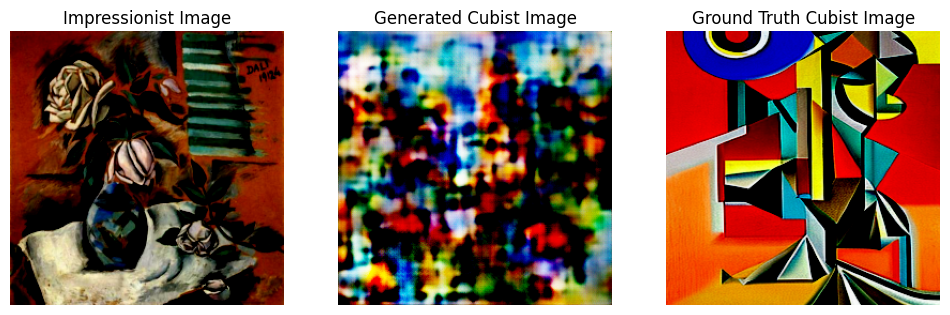

3it [00:00,  4.29it/s]



0.4998734235585782


0.6111906269698784


0.6018997883210907




0.6008601752436519


0.48505429049752163


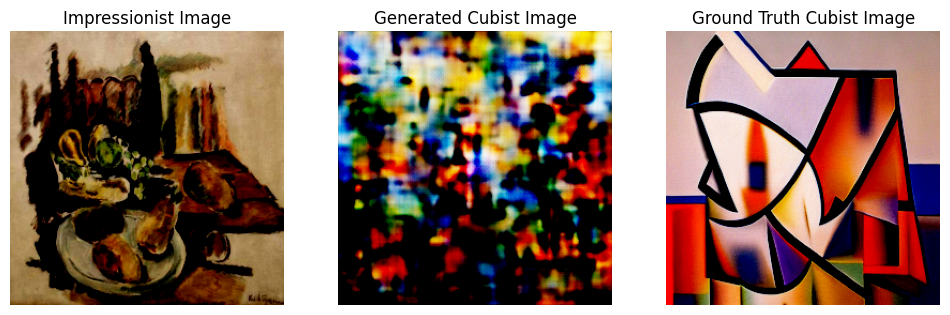

9it [00:01,  7.64it/s]



0.7005765604247971


0.9037866545359823


0.4950307607126363


0.41225306348964796




0.5753524880426998


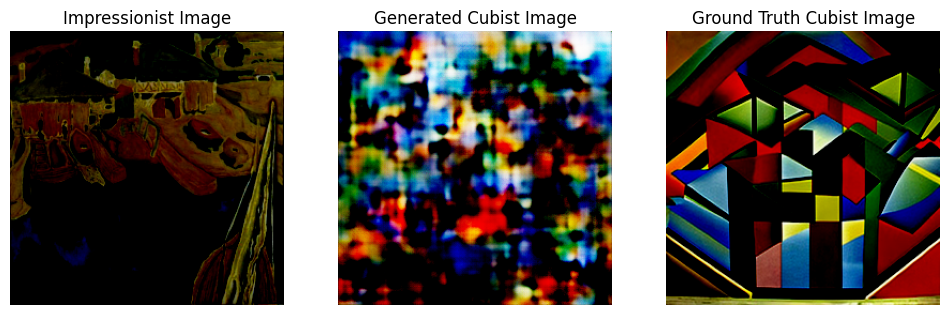

13it [00:02,  7.55it/s]



0.513677565885501


0.608229378908719


0.42479334023049653


0.43827394340425097




0.4964216308136729


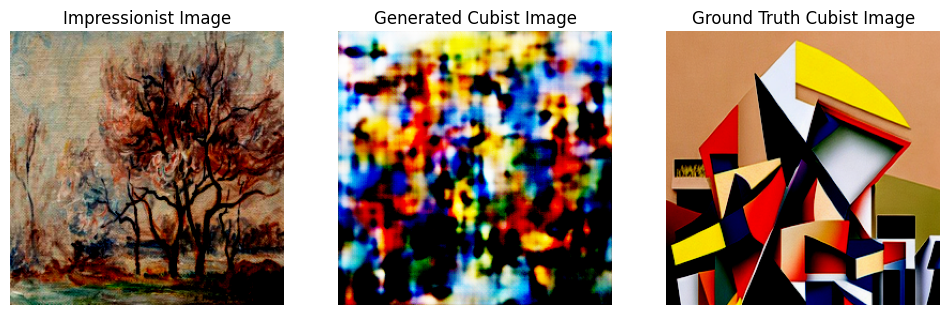

20it [00:02,  6.90it/s]



0.6481191088264494


0.5531801013431658


0.5945960900608409


0.5612215634917093




In [23]:
# Test

for i, (cubist_images, impressionist_images) in tqdm(enumerate(test_dataloader)):
    cubist_images=cubist_images.to(device)
    impressionist_images=impressionist_images.to(device)
    generated_images=generator(impressionist_images)
    generated_images_np = generated_images[0].cpu().detach().numpy().transpose((1, 2, 0))
    generated_images_pil = transforms.ToPILImage(generated_images_np)
    cubist_images_np = cubist_images[0].cpu().detach().numpy().transpose((1, 2, 0))
    cubist_images_pil = transforms.ToPILImage(cubist_images_np)
    generated_images_gray=cv2.cvtColor(generated_images_np, cv2.COLOR_BGR2GRAY)
    cubist_images_gray=cv2.cvtColor(cubist_images_np, cv2.COLOR_BGR2GRAY)
    mse = mean_squared_error(generated_images_gray, cubist_images_gray)
    print(mse)
    if i%5==0:
      fig,axs = plt.subplots(1, 3, figsize=(12, 4))
      axs[0].imshow(impressionist_images[0].cpu().detach().permute(1, 2, 0))
      axs[0].set_title('Impressionist Image')
      axs[1].imshow(generated_images_np)
      axs[1].set_title('Generated Cubist Image')
      axs[2].imshow(cubist_images_np)
      axs[2].set_title('Ground Truth Cubist Image')
      for ax in axs:
        ax.axis('off')
      plt.show()
    print('\n')